# ALeRCE API retrieval examples

Load libraries

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os, sys

import requests
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import pandas as pd
import seaborn as sns
#from pandas.io.json import json_normalize

#from collections import OrderedDict

from astropy.time import Time
from datetime import datetime
from IPython.display import HTML

import astropy.units as u
from astropy import coordinates

#from astroquery.ned import Ned
#from astroquery.simbad import Simbad
#from astropy.time import Time

#import json

from alerce.api import AlerceAPI

#!pip install psycopg2-binary
import psycopg2

from io import StringIO

In [3]:
import time
from astropy.time import Time

In [4]:
now = Time(datetime.utcnow(), scale='utc').datetime
now_mjd = Time(datetime.utcnow(), scale='utc').mjd

# Get fresh list of SNe sent to TNS by ALeRCE

In [5]:
def dourl(searchweb, searchoptions):
    url = searchweb
    for key in searchoptions.keys():
        url = "%s&%s=%s" % (url, key, searchoptions[key])
    return url

In [28]:
def get_tns_df(searchoptions):
    urlpage = dourl(searchweb,searchoptions)
    print(urlpage)
    s = requests.Session()
    response = s.get(urlpage)
    response.close()
    df = pd.read_csv(StringIO(response.text))
    urls = [f"http://alerce.online/object/{oid}" for oid in df['Disc. Internal Name']]
    df['url'] = urls
    return df

In [29]:
searchweb = "https://wis-tns.weizmann.ac.il/search?"
searchoptions = {
    "reporting_groupid[]": 74, # ALeRCE
    #"groupid": 74,
    #"discovery_data_source_id" : "48", # ZTF
    "num_page" : 500,  # 500 number of rows per page
    "format" : "csv",
    "display[remarks]":1,
}

In [30]:
all_alerce = []
page = 0
while True:
    print("Loading TNS page %i..." % page)
    searchoptions["page"] = page
    temp = get_tns_df(searchoptions)
    all_alerce.append(temp)
    if temp.shape[0] < 500:
        break
    page += 1
all_alerce = pd.concat(all_alerce)

Loading TNS page 0...
https://wis-tns.weizmann.ac.il/search?&reporting_groupid[]=74&num_page=500&format=csv&display[remarks]=1&page=0
Loading TNS page 1...
https://wis-tns.weizmann.ac.il/search?&reporting_groupid[]=74&num_page=500&format=csv&display[remarks]=1&page=1
Loading TNS page 2...
https://wis-tns.weizmann.ac.il/search?&reporting_groupid[]=74&num_page=500&format=csv&display[remarks]=1&page=2
Loading TNS page 3...
https://wis-tns.weizmann.ac.il/search?&reporting_groupid[]=74&num_page=500&format=csv&display[remarks]=1&page=3


In [31]:
all_alerce.shape

(1575, 25)

In [32]:
list(all_alerce)

['ID',
 'Name',
 'RA',
 'DEC',
 'Obj. Type',
 'Redshift',
 'Host Name',
 'Host Redshift',
 'Reporting Group/s',
 'Discovery Data Source/s',
 'Classifying Group/s',
 'Associated Group/s',
 'Disc. Internal Name',
 'Disc. Instrument/s',
 'Class. Instrument/s',
 'TNS AT',
 'Public',
 'End Prop. Period',
 'Discovery Mag',
 'Discovery Mag Filter',
 'Discovery Date (UT)',
 'Sender',
 'Remarks',
 'Ext. catalog/s',
 'url']

In [33]:
sent = list(all_alerce["Disc. Internal Name"].values)

In [34]:
retracted = pd.read_csv("retracted.txt").oid.to_list()

### Remove retracted

In [35]:
all_alerce = all_alerce[~all_alerce["Disc. Internal Name"].isin(retracted)]

In [36]:
all_alerce.to_pickle("all_alerce.pkl")

In [37]:
classified_mask = ~(all_alerce["Classifying Group/s"].isna())

In [40]:
np.sum(classified_mask)

212

In [41]:
all_alerce.head()

ID       Name            RA           DEC Obj. Type  Redshift  \
0  52302  AT 2020xr  06:28:22.171  +21:38:47.75       NaN       NaN   
1  52301  AT 2020xq  09:02:11.872  +14:43:09.68       NaN       NaN   
2  52300  AT 2020xp  09:06:44.796  +42:51:08.74       NaN       NaN   
3  52299  AT 2020xo  03:06:34.910  +74:38:22.59       NaN       NaN   
4  52298  AT 2020xn  03:06:53.677  -12:10:34.91       NaN       NaN   

                   Host Name  Host Redshift Reporting Group/s  \
0  WISEA J062821.96+213847.8            NaN            ALeRCE   
1   SDSS J090211.84+144310.6          0.101            ALeRCE   
2   SDSS J090644.67+425108.8          0.134            ALeRCE   
3  WISEA J030635.22+743821.9            NaN            ALeRCE   
4  WISEA J030653.77-121033.6            NaN            ALeRCE   

  Discovery Data Source/s  ... TNS AT Public End Prop. Period Discovery Mag  \
0                     ZTF  ...      1      1              NaN       19.4181   
1                     ZTF  ...      1      1              NaN       19.4215   
2                     ZTF  ...      1      1              NaN       19.5351   
3                     ZTF  ...      1      1              NaN       20.2251   
4                     ZTF  ...      1      1              NaN       19.8406   

  Discovery Mag Filter  Discovery Date (UT)  Sender  Remarks  \
0                r-ZTF  2020-01-14 08:28:31  ALeRCE      NaN   
1                r-ZTF  2020-01-14 08:02:10  ALeRCE      NaN   
2                r-ZTF  2020-01-14 07:55:55  ALeRCE      NaN   
3                r-ZTF  2020-01-14 04:54:31  ALeRCE      NaN   
4                g-ZTF  2020-01-14 03:26:19  ALeRCE      NaN   

                               Ext. catalog/s  \
0                                         NaN   
1                                         NaN   
2                                         NaN   
3  TESS-active sector/s (19,20);TESS-Sector19   
4                                         NaN   

                                        url  
0  http://alerce.online/object/ZTF20aafgbrf  
1  http://alerce.online/object/ZTF20aafjmdg  
2  http://alerce.online/object/ZTF20aafjjnm  
3  http://alerce.online/object/ZTF20aaffcse  
4  http://alerce.online/object/ZTF20aafdupr  

[5 rows x 25 columns]

In [49]:
all_alerce[classified_mask]["Obj. Type"].value_counts()


SN Ia              144
SN II               33
SN IIn               6
SN IIP               5
SN Ib                4
SN Ia-91T-like       4
SN Ic                3
SN IIb               3
Galaxy               2
SN                   2
SN Ic-BL             1
SN Ia-91bg-like      1
TDE                  1
SN Ia-pec            1
Name: Obj. Type, dtype: int64

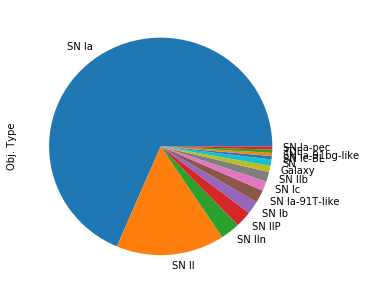

In [52]:
df_SN = all_alerce[classified_mask]["Obj. Type"].value_counts()
df_SN.plot.pie(y="count", figsize=(5, 5))

In [53]:
all_alerce.loc[classified_mask][(all_alerce[classified_mask]["Obj. Type"] == 'SN IIb')]

ID        Name            RA           DEC Obj. Type  Redshift  \
274  49753  SN 2019xct  00:38:50.125  -08:19:04.40    SN IIb   0.03000   
307  49720  SN 2019xbm  13:07:13.988  +58:08:03.35    SN IIb   0.02600   
240  44660  SN 2019pqo  15:41:30.333  +15:47:03.30    SN IIb   0.01413   

                    Host Name  Host Redshift   Reporting Group/s  \
274  SDSS J003849.83-081859.1       0.029000  ALeRCE, ATLAS, ZTF   
307                 UGC 08205       0.027713         ALeRCE, ZTF   
240                  NGC 5980       0.013649       ALeRCE, ATLAS   

    Discovery Data Source/s  ... TNS AT Public End Prop. Period Discovery Mag  \
274              ZTF, ATLAS  ...      1      1              NaN       18.7863   
307                     ZTF  ...      1      1              NaN       19.5441   
240              ZTF, ATLAS  ...      1      1              NaN       18.6697   

    Discovery Mag Filter  Discovery Date (UT)  Sender  Remarks  \
274                g-ZTF  2019-12-19 03:01:22  ALeRCE      NaN   
307                g-ZTF  2019-12-19 13:22:25  ALeRCE      NaN   
240                r-ZTF  2019-09-07 05:05:53  ALeRCE      NaN   

     Ext. catalog/s                                       url  
274             NaN  http://alerce.online/object/ZTF19aczmnqy  
307             NaN  http://alerce.online/object/ZTF19acyjjni  
240             NaN  http://alerce.online/object/ZTF19abxqppy  

[3 rows x 25 columns]

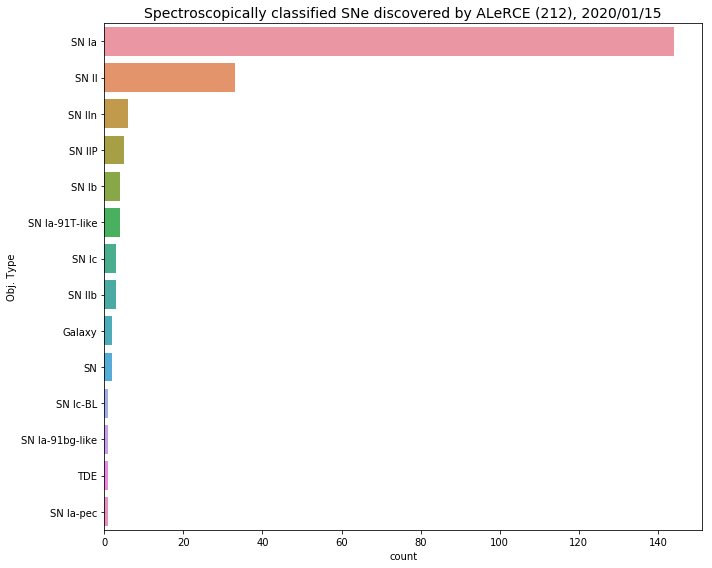

In [60]:
fig, ax = plt.subplots(figsize=(10, 8))
#sns.set(style="darkgrid")
counts = all_alerce[classified_mask]["Obj. Type"].value_counts()
sns.countplot(ax=ax, y="Obj. Type", data=all_alerce[classified_mask], order=counts.index)#cl[n.argsort()[::-1]])
ax.set_title("Spectroscopically classified SNe discovered by ALeRCE (%i), %s/%02i/%02i" % 
             (classified_mask.sum(), now.year, now.month, now.day), fontsize=14)
#ax.axvline(2.5, c = 'gray')
plt.tight_layout()
plt.savefig("plots/SN_types.png")
plt.savefig("plots/SN_types.pdf")

In [61]:
classified_oids = all_alerce[classified_mask]["Disc. Internal Name"].tolist()

In [62]:
oids = [oid for oid in sent if oid not in retracted]
oids = np.array(oids, dtype = str)

# Optional, use all SNe found, not just those in TNS

In [63]:
mode="tns" #'tns' 'all'
if mode == "all":
    oids = []
    for file in os.listdir("candidates"):
        if file[-3:] == 'txt':
            for oid in open("candidates/%s" % file, 'r').readlines():
                oids.append(oid[:-1])
    oids = np.array(oids)
    oids = np.unique(oids)
    oids = [oid for oid in oids if oid not in retracted]
    oids = np.array(oids, dtype = str)
elif mode=="tns":
    oids = [oid for oid in sent if oid not in retracted]
    oids = np.array(oids, dtype = str)

# Run all these cells if you want to update the results

In [64]:
alerce = AlerceAPI()

In [65]:
import json
credentials_file = "../usecases/alercereaduser_v2.json"
with open(credentials_file) as jsonfile:
    params = json.load(jsonfile)["params"]

In [66]:
conn = psycopg2.connect(dbname=params['dbname'], user=params['user'], host=params['host'], password=params['password'])

In [67]:
query = "select tablename from pg_tables where schemaname='public';"
tables = pd.read_sql_query(query, conn)
tables.sort_values(by="tablename")

tablename
9                    asassn
18                    class
10                crtsnorth
12                crtssouth
4                detections
23  early_classification_v2
16                 features
22              features_v2
2               features_v3
24      ingestion_timestamp
1                insert_tmp
25     late_class_timestamp
5     late_probabilities_v2
0     late_probabilities_v3
14                   linear
19                   magref
20           non_detections
3                   objects
15            probabilities
11     stamp_classification
7                 tax_class
6                  taxonomy
8                temp_probs
21               temp_table
17                      tns
13                   xmatch

In [68]:
alltabs = []
for tab in sorted(tables.tablename):
    cols = pd.DataFrame()
    query = "select column_name, data_type from information_schema.columns where table_name = '%s';" % tab
    results = pd.read_sql_query(query, conn)
    results["table"] = tab
    alltabs.append(results)
dftab = pd.concat(alltabs)
pd.options.display.max_rows = 999
display(dftab[["table", "column_name", "data_type"]])
pd.options.display.max_rows = 101

table                     column_name  \
0                     asassn                    ASAS-SN Name   
1                     asassn                     Other Names   
2                     asassn                            LCID   
3                     asassn                              ra   
4                     asassn                             dec   
5                     asassn                       Mean VMag   
6                     asassn                       Amplitude   
7                     asassn                          Period   
8                     asassn                            Type   
9                     asassn                             Url   
10                    asassn                       Reference   
11                    asassn                            Dist   
12                    asassn                        Parallax   
13                    asassn                  Parallax Error   
14                    asassn                            Gmag   
15                    asassn                           Bpmag   
16                    asassn                           Rpmag   
17                    asassn                            Jmag   
18                    asassn                            Hmag   
19                    asassn                            Kmag   
20                    asassn                           W1mag   
21                    asassn                           W2mag   
22                    asassn                           W3mag   
23                    asassn                           W4mag   
24                    asassn                           BP-RR   
25                    asassn                             J-K   
26                    asassn                           W1-W2   
27                    asassn                           W3-W4   
28                    asassn                  Sllk Statistic   
29                    asassn             RF Regression Score   
30                    asassn      Classification Probability   
31                    asassn                     Epoch (HJD)   
0                      class                              id   
1                      class                            name   
0                  crtsnorth             Catalina_Surveys_ID   
1                  crtsnorth                    Numerical_ID   
2                  crtsnorth                         V_(mag)   
3                  crtsnorth                   Period_(days)   
4                  crtsnorth                       Amplitude   
5                  crtsnorth                      Number_Obs   
6                  crtsnorth                        Var_Type   
7                  crtsnorth                              ra   
8                  crtsnorth                             dec   
0                  crtssouth                          SSS_ID   
1                  crtssouth                    Numerical_ID   
2                  crtssouth                              ra   
3                  crtssouth                             dec   
4                  crtssouth                          Period   
5                  crtssouth                           V_CSS   
6                  crtssouth                            Npts   
7                  crtssouth                           V_amp   
8                  crtssouth                            Type   
0                 detections                             oid   
1                 detections                          candid   
2                 detections                             mjd   
3                 detections                             fid   
4                 detections                      diffmaglim   
5                 detections                          magpsf   
6                 detections                           magap   
7                 detections                        sigmapsf   
8                 detections                        sigmagap   
9                 detections                           

In [69]:
query='''
select objects.oid, objects.firstmjd, objects.nobs, objects.meanra, objects.meandec
from objects
where objects.oid in (%s)
''' % ",".join(["'%s'" % oid for oid in oids])
SNe = pd.read_sql_query(query, conn)
SNe.set_index('oid', inplace=True)
SNe.head()

firstmjd  nobs      meanra    meandec
oid                                                    
ZTF17aaaeqnb  58778.136979     1   19.895777  32.180523
ZTF17aabbxwa  58726.502940    13   80.039303 -17.944233
ZTF17aacqdhh  58846.554456     1  195.458248  43.968051
ZTF17aaddzyk  58803.209572     1    9.765071 -18.608218
ZTF18aaavffc  58789.514595    15  187.979863  32.544494

In [70]:
query='''
select oid, candid, mjd, fid, magpsf, sigmapsf, magpsf_corr, sigmapsf_corr
from detections
where detections.oid in (%s)
''' % ",".join(["'%s'" % oid for oid in oids])
all_detections = pd.read_sql_query(query, conn)
all_detections.set_index('candid', inplace=True)
all_detections.head()

oid           mjd  fid     magpsf  sigmapsf  \
candid                                                                     
937419020215015009  ZTF19abizkzh  58691.419028    2  20.113478  0.189476   
936169913315015012  ZTF19abiijfy  58690.169919    2  19.698338  0.136072   
936192433315015010  ZTF19abiijfy  58690.192431    1  19.795248  0.122960   
937371221415015020  ZTF19abiovio  58691.371227    2  20.146393  0.212616   
937419471915015004  ZTF19abgqruu  58691.419479    2  20.143616  0.171262   

                    magpsf_corr  sigmapsf_corr  
candid                                          
937419020215015009    20.113478       0.189476  
936169913315015012    19.698338       0.136072  
936192433315015010    19.795248       0.122960  
937371221415015020    19.115045       0.108332  
937419471915015004    20.143616       0.171262

In [71]:
query='''
select oid, fid, diffmaglim, mjd
from non_detections
where non_detections.oid in (%s)
''' % ",".join(["'%s'" % oid for oid in oids])
all_non_detections = pd.read_sql_query(query, conn)
all_non_detections.set_index('mjd', inplace=True)
all_non_detections.head()

oid  fid  diffmaglim
mjd                                        
58661.191424  ZTF19abiiitl    2   20.485901
58660.232801  ZTF19abiijfy    2   20.829399
58663.190648  ZTF19abiijfy    2   20.358101
58661.212743  ZTF19abiiitl    1   20.479099
58663.211806  ZTF19abiijfy    1   20.739300

# Histogram of cadences

In [72]:
dts = []
dts_1st = []
dts_fid = []
for oid in all_detections.oid.unique():
    mask = (all_detections.oid == oid)
    times = np.sort(np.array(all_detections.loc[mask].mjd.unique()))
    if mask.sum() > 1:
        dts.append(times[1:] - times[:-1])
        dts_1st.append([times[1] - times[0]])
    for fid in [1, 2]:
        mask = (all_detections.oid == oid) & (all_detections.fid == fid)
        times = np.sort(np.array(all_detections.loc[mask].mjd.unique()))
        if mask.sum() > 1:
            dts_fid.append(times[1:] - times[:-1])
dts = np.concatenate(dts)
dts_1st = np.concatenate(dts_1st)
dts_fid = np.concatenate(dts_fid)

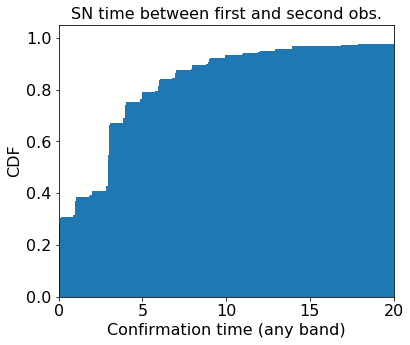

In [73]:
fig, ax = plt.subplots(figsize=(6,5))
ax.hist(dts_1st, bins=1000, cumulative=True, density=True);
ax.set_xlim(0, 20)
ax.set_xlabel("Confirmation time (any band)", fontsize=16)
ax.set_ylabel("CDF", fontsize=16)
ax.set_title("SN time between first and second obs.", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.savefig("plots/SNconfirmation_any_%s.png" % mode)

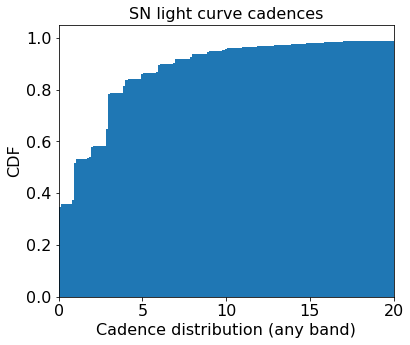

In [74]:
fig, ax = plt.subplots(figsize=(6,5))
ax.hist(dts, bins=1000, cumulative=True, density=True);
ax.set_xlim(0, 20)
ax.set_xlabel("Cadence distribution (any band)", fontsize=16)
ax.set_ylabel("CDF", fontsize=16)
ax.set_title("SN light curve cadences", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.savefig("plots/SNcadence_any_%s.png" % mode)

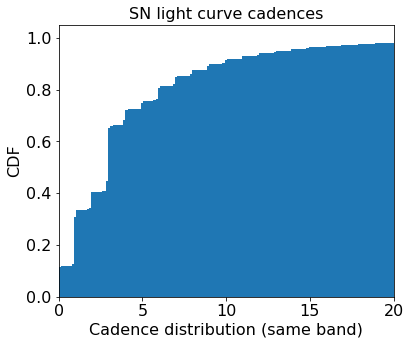

In [75]:
fig, ax = plt.subplots(figsize=(6,5))
ax.hist(dts_fid, bins=1000, cumulative=True, density=True);
ax.set_xlim(0, 20)
ax.set_xlabel("Cadence distribution (same band)", fontsize=16)
ax.set_ylabel("CDF", fontsize=16)
ax.set_title("SN light curve cadences", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.savefig("plots/SNcadence_same_%s.png" % mode)

# Extract relevant features

In [76]:
nobs = []
dts = []
dt2s = []
dmags = []
dts_fid = []
dmags_fid = []
dmdt_fid = []
first_mjds = []
first_det_mags = []
max_mags = []
max_mjds = []
dt_first_max = []
dmag_first_max = []
ras = []; decs = []
for SN in oids:#["ZTF19abpsana"]:
    stats = SNe.loc[SN]
    stats.dropna(inplace=True)
    detections = all_detections[all_detections.oid == SN]
    non_detections = all_non_detections[all_non_detections.oid == SN]
    nobs.append(int(stats.nobs))
    
    
    first_det_idx = detections.mjd.idxmin()
    first_det_mjd = float(detections.loc[first_det_idx].mjd)
    first_det_fid = int(detections.loc[first_det_idx].fid)
    first_det_mag = float(detections.loc[first_det_idx].magpsf)
    first_det_mags.append(first_det_mag)
    ras.append(stats.meanra)
    decs.append(stats.meandec)
    first_mjds.append(first_det_mjd)
    max_mjds.append(detections.loc[detections.magpsf.idxmin()].mjd)
    max_mags.append(detections.loc[detections.magpsf.idxmin()].magpsf)
    dt_first_max.append(max_mjds[-1] - first_mjds[-1])
    dmag_first_max.append(first_det_mags[-1] - max_mags[-1])
    
    mask = non_detections.index < first_det_mjd
    if np.sum(mask) > 0:
        last_non_det_mjd = np.array(non_detections.index[mask]).max()
        last_non_det_mag = non_detections.loc[last_non_det_mjd].diffmaglim
        if last_non_det_mag.shape != ():
            last_non_det_mag = last_non_det_mag.unique()[0]
        dts.append(first_det_mjd - last_non_det_mjd)
        dmags.append(last_non_det_mag - first_det_mag)
    else:
        dts.append(None)
        dmags.append(None)

    mask = (non_detections.index < first_det_mjd) & (non_detections.fid == first_det_fid)
    if np.sum(mask) > 0:
        last_non_det_fid_mjd = non_detections.index[mask].max()
        last_non_det_fid_mag = non_detections.loc[last_non_det_fid_mjd].diffmaglim
        if last_non_det_fid_mag.shape != ():
            last_non_det_fid_mag = last_non_det_fid_mag.unique()[0]
        dts_fid.append(first_det_mjd - last_non_det_fid_mjd)
        dmags_fid.append(last_non_det_fid_mag - first_det_mag)
        dmdt_fid.append(dmags_fid[-1] / dts_fid[-1])
    else:
        dts_fid.append(None)
        dmags_fid.append(None)
        dmdt_fid.append(None)
    
    if nobs[-1] > 1:
        second_det_mjd = detections.mjd[detections.mjd > first_det_mjd].min()
        dt2s.append(second_det_mjd - last_non_det_mjd)
    else: 
        dt2s.append(None)
        
    print(SN, nobs[-1], dts[-1], dt2s[-1], dmags[-1], dmags_fid[-1], dt_first_max[-1])

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF20aafgbrf 1 1.1434606000038912 None 0.014005661010699555 0.014005661010699555 0.0
ZTF20aafjmdg 1 6.895763900094607 None 0.6379528045654013 0.5285530090331996 0.0
ZTF20aafjjnm 2 1.979988399798458 1.9827198999992106 -0.41072463989249997 -0.41072463989249997 0.0
ZTF20aaffcse 1 0.07380779999948572 None 0.3312854766846023 -0.677314758300799 0.0
ZTF20aafdupr 1 0.916712899801496 None -0.521415710449201 -0.6610164642333984 0.0
ZTF20aafdnms 1 1.9272684997995384 None -0.9241333007812997 -0.7680339813231996 0.0


/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF20aafdmpp 1 2.960983700097131 None -0.6400489807129013 -0.6969490051268998 0.0
ZTF20aafdmfp 1 2.9727662001969293 None -0.9158229827881001 -0.7445220947266016 0.0
ZTF20aafdmpa 1 2.9589698999989196 None 0.1827239990234979 0.6551246643066975 0.0
ZTF20aafdlmo 1 2.9682059999977355 None -0.5968990325928019 -0.40340042114259944 0.0
ZTF20aafdkyg 1 2.9618518998031504 None -0.1636772155762003 -0.09597778320310013 0.0
ZTF20aafdhqm 3 0.9332985997971264 0.9545369999977993 -0.37201690673830257 -0.5025177001954013 0.08645830030582147
ZTF20aafdfvn 1 1.9345716997995623 None -1.0298843383788991 -0.6000843048095987 0.0
ZTF20aafdeza 1 2.957083299799706 None 0.42903518676759944 0.21303558349610086 0.0


/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF20aafdarv 1 2.934363399799622 None 0.2949256896972976 0.1699256896972976 0.0
ZTF20aafdbbb 1 2.955046299895912 None -0.43682098388669743 -0.43682098388669743 0.0
ZTF20aafcmfi 1 7.979039399906469 None 1.283494949340799 1.283494949340799 0.0
ZTF20aafclqz 1 6.95789350020641 None 1.5980148315428977 1.5980148315428977 0.0
ZTF20aafcljq 1 4.938715299998876 None 1.6710300445556996 1.6599292755126989 0.0
ZTF20aafclxb 1 4.984027799902833 None 2.7701778411864986 3.3931770324706996 0.0


/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF20aafcjln 1 4.920127300196327 None 2.974504470825199 2.974504470825199 0.0
ZTF20aaezglg 1 6.978958299900114 None -0.3918800354004013 -0.47838020324709873 0.0
ZTF20aaezmvb 2 6.958194399805507 6.980266200000187 -1.2182006835937997 -0.9004993438720987 0.0
ZTF20aaezggc 1 0.0054630000013276 None 0.7920970916747976 0.7920970916747976 0.0
ZTF20aaeyzuw 1 6.9843402999977116 None -0.15108489990239704 -0.9938850402831996 0.0
ZTF20aaezacd 2 6.975787000199489 6.986597199895186 -0.035400390625 -0.035400390625 0.0
ZTF20aaexoxs 4 0.11575230019661831 0.9884259997998015 -0.20415306091310015 -0.20415306091310015 0.0
ZTF20aaewevn 1 6.021516199805774 None 0.1610202789306001 0.1610202789306001 0.0
ZTF20aaewaxu 2 5.976030099896889 9.005266200001643 -0.283935546875 -0.6946353912352983 0.0
ZTF20aaevmbg 1 3.9379050000934512 None 1.5983524322508984 1.5983524322508984 0.0
ZTF20aaevlau 1 2.939502299799642 None 1.0356941223143998 0.570095062255799 0.0
ZTF20aaeundp 1 6.823576399998274 None 1.6714115142823012 1.67

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

 1 0.0947917000958114 None -0.21378517150879972 0.1139163970947017 0.0
ZTF20aaesypc 5 0.07966439979645656 0.11424770019948483 -0.11735153198240056 0.6502494812012003 1.9599190001026727
ZTF20aaesxky 1 0.048460700098075904 None -0.06302261352539773 0.5660762786865021 0.0
ZTF20aaeswiy 6 0.055648100198595785 0.09281249999912689 -0.3187370300293004 0.023561477661100838 1.9806481999985408
ZTF20aaesjfs 1 2.9579166999974404 None 0.18603324890129969 0.007633209228497861 0.0
ZTF20aaetqwv 9 2.9628355998938787 3.061215299894684 0.5345001220703018 0.3829994201660014 3.177685200200358
ZTF20aaetrle 7 5.961724500200944 6.0840046000957955 -0.014699935913100148 0.49709892272950285 4.080405099695781
ZTF20aaerxkn 3 0.014965299800678622 2.9375347000022884 0.23016357421870026 0.31146240234370026 6.857002300195745
ZTF20aaervup 1 0.01758110010268865 None -0.1240234375 -0.7580223083496023 0.0
ZTF20aaertpj 3 3.0310995998006547 3.0474652998018428 0.8981113433837997 0.8981113433837997 6.895763900203747
ZTF20aaert

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF20aaerrhb 1 1.0518171001021983 None 0.30675888061519885 0.30675888061519885 0.0
ZTF20aaerqbx 2 3.0134838002049946 3.0319907001030515 0.8968105316162003 0.8968105316162003 0.0
ZTF20aaerpoj 1 3.008044000103837 None 0.382818222045902 0.382818222045902 0.0
ZTF20aaervyn 2 3.0071412000979763 3.0260880001005717 -0.3289012908935014 -0.3289012908935014 0.01894680000259541
ZTF20aaervoa 2 3.0071412000979763 3.0260880001005717 -0.3757991790771982 -0.3757991790771982 0.01894680000259541
ZTF18acydrro 1 3.0374306001031073 None 0.9944534301758026 0.9944534301758026 0.0
ZTF20aaeqxtc 3 2.8975578001045506 6.894953700204496 1.2985935211181001 0.43809318542480113 6.982777799894393
ZTF20aaeqmjl

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

 2 2.874444399996719 8.907476800100994 1.2022037506104013 0.06430435180670102 6.033032400104275
ZTF20aaeoqqd 6 1.9585415998008102 2.016747600202507 0.4115200042725 0.35992050170900214 6.003009300198755
ZTF20aaelulu 3 2.995891199898324 6.934849500197743 3.241920471191399 3.241920471191399 3.9389583002994186
ZTF20aaenizt 1 0.028252300100575667 None 1.1804790496825994 1.1467800140380966 0.0
ZTF20aaenkwk 2 3.017986099803238 3.0353818998046336 0.29660034179689987 0.29660034179689987 0.0173958000013954
ZTF20aacbnya 1 1.0040740998010733 None -0.6251659393311009 -0.6251659393311009 0.0
ZTF20aaemdib 1 0.9838194001058582 None -0.22401618957520242 -0.22401618957520242 0.0
ZTF20aaemvms 1 0.9802083001995925 None -0.443895339965799 -0.443895339965799 0.0
ZTF20aaekkuv 4 2.923888900098973 3.023912099895824 1.0840148925781001 1.0840148925781001 6.980891199797043


/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF20aaekiti 1 2.9198841998004355 None 1.8104343414306996 1.8104343414306996 0.0
ZTF20aaebiae 1 0.7347222001990303 None 2.9256744384766016 2.626274108886701 0.0
ZTF20aaebbeg 1 0.7177662001995486 None 1.7780704498291016 1.2530708312988033 0.0
ZTF20aaeacby 5 2.9974537000016426 2.997905099997297 -0.53098487854 -1.2272853851318004 5.031446800101548
ZTF20aadzwnu 4 2.986087900098937 9.008506900099746 0.41618919372560015 0.6737899780273011 9.000729200000933
ZTF20aadzwqa 4 2.986087900098937 9.008506900099746 -0.5542545318604013 -0.5732555389405007 8.983576399696176
ZTF20aadwsbp 1 0.05765049979527248 None 0.001646041870099424 -2.69775390625 0.0
ZTF20aadvpyk 1 2.998020899904077 None -0.4258747100830007 -0.18177604675290127 0.0


/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF20aadymod 1 2.9668287001986755 None 4.997043609619201 4.997043609619201 0.0
ZTF20aadylyh 1 2.979467600096541 None -0.45993804931639914 -0.45993804931639914 0.0
ZTF20aadxwkc 1 0.9573495001968695 None -0.014755249023401973 -0.3525562286377024 0.0
ZTF20aadxtze 2 2.961261499898683 10.958275399796548 -0.010101318359399869 -0.010101318359399869 7.9970138998978655
ZTF20aadxrsu 3 3.018784699801472 3.0621064998049405 -0.1818943023681996 -0.8965950012206996 3.0369792003984912
ZTF20aadwzgp 1 0.06560190019808942 None 0.06386756896980117 -0.3001308441162003 0.0
ZTF20aadvsdj 2 2.998020899904077 12.878356499997608 -0.5559940338134979 -0.4962940216063991 9.880335600093531
ZTF20aadvjvq 1 0.981597300095018 None 0.21342277526860087 0.21342277526860087 0.0
ZTF19adcbanf 5 2.978715299796022 3.0105439999024384 0.04940605163579903 0.04940605163579903

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

 8.919166700405185
ZTF20aadtagj 1 2.9840972001984483 None -0.46895599365229756 -0.46895599365229756 0.0
ZTF20aaddano 1 0.036979099895688705 None 0.6258411407470987 None 0.0
ZTF20aadczqe 1 0.03270830000110436 None -0.0009384155274005934 None 0.0
ZTF20aadcygw 1 0.02765049989830004 None 0.3998928070068004 -0.584806442260799 0.0
ZTF20aadcxll 1 0.026643500095815398 None -0.06296920776360082 -1.2160682678222017 0.0
ZTF19acyjisf 1 0.01655099979689112 None 0.6512870788574006 0.11428833007810013 0.0
ZTF20aadcqkx 3 0.010844900003576186 2.9714814999024384 1.0951976776122976 -1.14280128479 6.931875000198488
ZTF20aadcmit 1 None None None None 0.0


/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF20aadcitq 12 0.001018499802739825 0.012372699799016118 0.7663192749023011 0.7663192749023011 9.94590280020202
ZTF20aadcjdr 2 5.983067099798063 8.955046300099639 0.5520191192626989 0.5520191192626989 0.0
ZTF20aadcirh 8 5.983067099798063 5.99442129979434 0.25236892700189983 0.25236892700189983 9.94590280020202
ZTF20aadcigi 5 5.982523199803836 6.0139352001060615 1.0409240722656001 1.0409240722656001 9.94230320029601
ZTF20aadcfva 8 5.97412039990013 5.989710600100807 0.9476242065429012 0.9476242065429012 9.875567100003536
ZTF20aadceoq 7 0.11325229989597574 3.0117128998972476 -0.002273559570301842 -0.8479728698730007 8.936898100204417
ZTF20aadccel 3 None 0.14557870009593898 None None 0.03843750010128133
ZTF20aaddbem 2 None 0.14557870009593898 None None 0.03843750010128133
ZTF20aadccez 2 None 0.14557870009593898 None None 0.03843750010128133
ZTF19aczkjxn 5 None 0.10805549989891006 None None 0.03607639999972889
ZTF20aadccer 3 None 0.14557870009593898 None None 0.03843750010128133
ZTF19acxqa

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF20aadcbux 3 14.975659700103279 15.013553199802118 0.12289237976080258 0.12289237976080258 0.03789349969883915
ZTF20aadcbqs 3 14.975208299794758 14.975671299798705 -0.7144699096679012 -0.7144699096679012 0.03924770000594435
ZTF20aaaygjx 1 0.07975689989689272 None 0.3681182861327983 0.34941864013680046 0.0
ZTF20aadblvr 2 14.955983799896785 14.998425899997528 -0.5719184875488992 -0.5719184875488992 0.0
ZTF20aacyzzp 1 2.9954050997985178 None 0.165288925170902 0.165288925170902 0.0
ZTF20aaczcob 2 2.0208448997946107 2.9991087999005686 -0.3943061828613992 -2.060205459594801 0.9782639001059579
ZTF20aadclfe 2 0.971967600096832 1.0689815001969691 -0.3847999572754013 -0.3847999572754013 0.09701390010013711
ZTF20aacxhsj 1 2.956319399898348 None -0.418138504028299 -0.704738616943402 0.0
ZTF20aacvyjx 2 0.9084028001016122 1.924629700006335 -0.15977287292480113 0.020326614379900576 0.0
ZTF20aacewyh 6 14.890578799895593 14.930463000193413 0.8731384277343004 None 0.0
ZTF20aacexgb 4 14.895069500096724

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF20aacctdf 1 None None None None 0.0
ZTF20aaccity 2 13.978530100204807 14.021678200100723 0.13369941711419742 -0.20890045166020244 0.04314809989591595
ZTF19adaqnob 3 0.9749073998027598 1.9711689000978367 -0.7598628997802983 -0.7598628997802983 0.996261500295077
ZTF20aacalzt 1 13.210069499902602 None -0.556396484375 0.39550399780269885 0.0
ZTF20aabqwsh 3 None 13.339594900098746 None None 2.006145900093543
ZTF20aabqwtz 3 None 13.339594900098746 None None 2.006145900093543
ZTF20aabqwzn 3 None 13.339594900098746 None None 0.0
ZTF20aabqxeg 3 19.443495300103677 20.444432800097275 0.570121765136701 0.570121765136701 0.0
ZTF20aabqvqp 4 0.03424770000128774 0.03472219999821391 -0.20075798034660153 0.44404220581060017 0.0
ZTF20aabquhf 1 0.04068289989663754 None -0.13737869262689983 -1.0994796752930007 0.0
ZTF20aabqtxg 1 0.04068289989663754 None 0.28031921386710223 -0.5865802764893004 0.0
ZTF20aabqroo 1 0.020393499900819734 None 0.6044368743897017 1.1922359466553019 0.0
ZTF20aabqqpj 17 3.9602315

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF20aabqlhm 4 1.0186340659856796e-10 12.977662000004784 -0.19950103759769888 -0.19950103759769888 0.0
ZTF20aabqzcn 5 3.949953700095648 3.975949099898571 0.4296989440918004 0.4296989440918004 3.004988499902538
ZTF20aabqvea 5 3.964803200098686 3.9953935000958154 1.0065002441406001 -1.9409008026123011 0.030590299997129478
ZTF20aabqjht 8 3.944861200201558 3.9763774001039565 0.27326202392580257 0.27326202392580257 12.93736109980091
ZTF20aabqvri 4 11.958101899901521 11.992349600004673 -1.8306007385254013 -1.8306007385254013 0.0
ZTF20aabqwan 6 11.95532409990119 11.992835700097203 -1.3059005737305007 -1.3059005737305007 6.058391199898324
ZTF20aabqiti 11 None 11.980069500001264 None None 4.988587900101265
ZTF19aaujqrd

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

 4 11.95532409990119 11.992835700097203 -1.6702995300293004 -1.6702995300293004 3.0222916998973233
ZTF20aabqiwz 2 21.955162100101006 24.001909799902933 -0.7194728851317969 None 0.0
ZTF20aabqiqd 11 21.955162100101006 21.998981500102673 -0.4364662170411009 None 4.065636499799439
ZTF20aabqiou 7 13.994594900002994 14.040266199997859 0.257583618164098 0.257583618164098 6.058044000099471
ZTF20aabqvvw 5 11.953391200004262 11.992349600004673 -2.1067008972168004 -2.1067008972168004 0.03895840000041062
ZTF20aabqilc 5 13.993692200194346 14.040266199997859 0.16799163818360086 0.16799163818360086 0.0
ZTF20aabqiiy 7 13.944999999803258 13.99247679990367 0.22940635681149857 -0.13979339599610086 10.981412000001
ZTF20aabqimd 2 11.952476899896283 14.999247699801344 -1.9233474731444993 -1.9233474731444993 0.0
ZTF20aabqiav 6 13.99097219989926 14.041608800194808 1.4759368896485014 1.4759368896485014 10.99674770009733
ZTF20aabqibc 4 13.99097219989926 14.041608800194808 0.014093399047801825 0.0140933990478018

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF20aabqbxm 6 11.921053300204221 11.978622700102278 -0.6810588836669993 -0.6810588836669993 3.0931249997011037
ZTF20aabqbvs 4 11.921053300204221 11.978622700102278 -1.7527503967285014 -1.7527503967285014 6.057314799596497
ZTF20aabqadb 3 11.937511599804566 11.995046300100512 -2.0024604797362997 -2.0024604797362997 0.0
ZTF20aabpmlx 4 11.956770799901278 12.022835600102553 -0.6588230133057031 -0.6588230133057031 0.0
ZTF20aabcpcs 7 0.0576735998984077 3.039282400000957 -1.3925971984862997 0.43630218505860086 11.040312500204891
ZTF20aabcopd 1 0.05767359990568366 None -1.1465568542481002 0.7437419891356996 0.0
ZTF20aabcouv 11 0.05361110020021442 5.993055599799845 0.18300056457520242 -1.8711986541747976 9.99930559979839
ZTF20aabbcvk 1 3.8755209000009927 None 0.5346450805663991 0.5346450805663991 0.0
ZTF20aaayrpo 8 None 4.256921299798705 None None 1.0055670998990536
ZTF20aaayrmp 5 10.988506900001084 14.017106499901274 -0.7353420257568004 -2.744041442871101 6.049675900103466
ZTF18aawdbcu 4 10.98

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF20aaaxcoe 2 2.9972685001048376 6.022858799798996 0.849821090698299 0.849821090698299 0.0
ZTF20aaaxakx 1 2.995879600101034 None 0.5262355804443999 0.5262355804443999 0.0
ZTF20aaaymqt 6 2.9902199002026464 3.0379628997980035 0.07390022277830255 0.07390022277830255 6.06771989959816
ZTF20aaawfzb 16 10.871365700098977 10.946504599996842 -1.1256065368652983 -1.1256065368652983 5.0212499996996485
ZTF20aaawbxl 7 10.921828700200422 10.975370400097745 0.25106430053710227 0.25106430053710227 5.93329859989899
ZTF20aaawbkz 7 10.921828700200422 10.975370400097745 -0.021450042724598717 -0.021450042724598717 6.033321799695841
ZTF20aaavzur 3 10.953286999800184 10.989687500004948 -1.5548648834227983 -1.9056644439697017 0.0
ZTF20aaavzup 8 10.953286999800184 10.989687500004948 -1.3668651580809978 -1.7176647186279013 6.034224500399432
ZTF20aaacxwz 1 0.01989589990262175 None 0.5633811950683025 0.1264801025390021 0.0
ZTF20aaactgu 8 0.04531249990395736 3.0580903001027764 0.39252662658689985 -0.1248722076416

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF20aaabsib 8 2.999108800198883 10.023344900000666 0.3849124908447976 0.0197124481201989 10.091793999999936
ZTF20aaaboph 6 0.039919000104418956 1.073680600100488 1.2490425109862997 0.33114242553710227 6.971273200098949
ZTF20aaaakav 3 2.945173600099224 4.030752300197491 -0.30361557006839845 -4.7896156311035 7.09855329990387
ZTF20aaaaiha 6 0.0064004001978901215 1.0737614997997298 0.11898612976069955 -0.230415344238299 4.04406249980093
ZTF19adcgvpb 1 8.995324100003927 None 2.436670303344698 2.436670303344698 0.0
ZTF18acekgln 1 6.9780787001000135 None -1.4004898071288991 -1.4380893707275995 0.0
ZTF19adcgidk 1 8.949537099797453 None 0.020856857299801135 -0.2335433959960973 0.0
ZTF19acqxgzo 1 0.020439800100575667 None 0.8238201141356996 -1.9042797088623011 0.0
ZTF19aakzqbz 5 9.990972299900022

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

 15.962766200202168 0.027986526489300445 0.027986526489300445 12.810335600304825
ZTF19adcgaer 11 9.0546875 9.070949100001599 0.9662284851074006 0.9662284851074006 4.973611100198468
ZTF19adcfzyu 10 9.993240699899616 14.963692100100161 1.0958080291748011 1.0958080291748011 5.988784800298163
ZTF18aaizerg 18 7.997453700001643 8.014571699903172 -0.23890304565430043 -0.5428028106688991 10.016724499801057
ZTF19adcfvzl 1 7.997453700001643 None -1.5287685394287003 -1.7892684936524006 0.0
ZTF17aacqdhh 1 8.000625000204309 None -1.381380081176701 -0.633279800415 0.0
ZTF19adakigh 4 7.999699099796999 13.982766199798789 -1.8000354766846023 -1.5823345184325994 5.994421299998066
ZTF19adcfvvp 4 7.998761600203579 13.993182900201646 -1.6973266601562003 -1.7765274047850994 5.994421299998066
ZTF19adcfwhd 4 7.998761600203579 13.981284799803689 -0.7669544219969993 -0.9025535583496023 0.0
ZTF19adcfvyt 10 7.998761600203579 13.981284799803689 -1.7518348693847976 -1.7013359069824006 15.848888899599842
ZTF19adcfvl

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF19adcftjl 1 7.999189899899648 None -2.2566432952881 -2.2029418945312003 0.0
ZTF19adcftlo 1 7.975416699904599 None -2.750991821289002 -2.1716918945312003 0.0
ZTF19adcftgn 7 8.000092599904747 11.970462900098937 -1.830385208129897 -1.5608844757079972 10.012916599895107
ZTF19adcftgt 5 8.000092599904747 8.020509200097877 -1.8351726531981996 -1.5066738128662003 4.01806710009987
ZTF19adcftfd 1 7.9758565000011 None -2.144142150878899 -1.0930423736571981 0.0
ZTF19adcgemg 2 7.974050900003931 7.994930599903455 -2.590499877929698 -1.2080993652343999 0.020879699899523985
ZTF19adcfsqb 1 7.998726800098666 None -2.4462947845458984 -2.3226947784424006 0.0
ZTF19adcgdwa 4 7.998726800098666 8.020057899899257 -4.191699981689499 -1.9191989898681996 0.02133109980059089
ZTF19adcfssx 6 7.998726800098666 8.020057899899257 -1.6385231018066015 -1.0527229309081996 6.976261599898862
ZTF19adcfrhc 5 7.977696799898695 10.935138900094898 -1.9420051574706996 -0.6088047027587997 6.000208300101804
ZTF19adcfpyn 1 7.9524

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF19adceoey 3 0.029791600201861 2.9844212999014417 -0.09036445617670097 -1.5667648315429012 2.9546296996995807
ZTF19adcejnq 24 6.984409700096876 7.002476800196746 -2.849016189575199 -3.7969160079956 9.850867999703041
ZTF19adccsjp 7 6.99030089990265 7.024155099905329 -3.537616729736399 0.125583648681598 2.959618100001535
ZTF19adcfjmv 2 0.04290510019927751 0.07685189980111318 -0.07970046997069957 -0.07970046997069957 0.033946799601835664
ZTF19adcednr 6 9.91694439999992 9.960451399900194 -0.06671905517569954 -0.20101737976069955 6.020231499795045
ZTF19adcecxf 15 7.952361099800328 8.046249999999418 -0.316608428955103 -0.316608428955103 6.086296300403774
ZTF19adcdzjm 10 7.889942100206099 7.943449099904683 -1.8417701721191015 -1.8417701721191015 13.908379699998477
ZTF19adcdxiq 10 7.9417129000939894 11.024317099792825 -0.8215656280518004 -0.8215656280518004 15.061990799898922


/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF19adcdrho 5 9.910810200104606 9.952742999899783 0.05004692077639916 -0.3334522247314986 0.0
ZTF19adcdrng 9 9.910810200104606 9.952742999899783 0.5079002380371023 0.3750991821289027 9.023067099995387
ZTF19adcbxkw 8 0.041365800199855585 0.08569449999777135 1.5482254028320028 1.5482254028320028 7.0276735997977084
ZTF19adccckb 5 0.031388900002639275 0.07706020009936765 0.4124507904052983 0.4124507904052983 0.04567130009672837
ZTF19adcdggs 15 6.959907399999793 7.005590300097538 -2.859167098999098 0.914731979370103 0.045682900097745005
ZTF19adccruw 15 8.93395829990186 8.967557900097745 -0.1645603179931001 -0.26956176757810013 8.098136600099679
ZTF19adccogc 9 7.917499999799475 7.955694399999629 -0.7457275390625 -0.7457275390625 3.0110763999982737
ZTF19adcbnty 9 8.928900400205748 11.94429389990546 1.6861553192138992 1.8371562957763992 3.0531481997968513
ZTF19adcbiqg 8 7.954259300204285 7.983993100104271 -0.6249389648437003 -1.0936393737793004 8.919583299699298
ZTF19adcawri 3 8.9264815002024

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF19adbrfza 20 9.747847200102115 9.790636600198923 -0.059741973876899834 -0.7953414916991974 7.929756999903475
ZTF19adbpulv 13 0.08365739999862853 3.038090300098702 -0.08352279663079898 -3.0599231719969993 12.955694399795902
ZTF19adbpxoz 4 9.999016200199549 10.08450229979644 0.7133007049561009 0.02770042419430041 0.0
ZTF19adbmgiv 3 7.981400499898882 7.992754699902434 -0.9697837829589986 -0.9697837829589986 0.0
ZTF19adbmftz 7 6.9923033000013675 7.003645799901278 -1.5150356292725 -1.5150356292725 6.053749999999127
ZTF19adbmeva 7 7.968958399898838 12.02874999980122 -0.2179946899414027 -0.2179946899414027 7.043472200202814
ZTF19adbmdxy 1 7.9685185000053025 None -0.8822441101074006 -0.8822441101074006 0.0
ZTF19adbmdnz 3 7.967175899895665 8.01582169989706 -0.5291042327881001 -0.5291042327881001 3.05314810010168
ZTF19adbmdsa 5 7.967175899895665 8.01582169989706 -0.4033966064454013 -0.4033966064454013 9.108506900200155
ZTF19adbfhal 5 5.018900399903941 17.004363399806607 0.42673492431639914 0.

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF19adbewtd 1 0.04384260000369977 None -0.4941215515137003 1.8180770874023011 0.0
ZTF19adazgzy 1 0.0023611000942764804 None 0.47829627990719814 0.47829627990719814 0.0
ZTF19adaymon 1 1.0252199000969995 None 0.016508102417002846 0.016508102417002846 0.0
ZTF19adaylfn 1 2.9749305001969333 None 0.19374656677240054 -0.4125518798827983 0.0
ZTF19adaykkr 1 2.970405100102653 None -0.5084743499756001 -0.9509754180908025 0.0
ZTF19adaxzax 7 3.0065972000011243 17.02246529990225 0.34634780883789773 0.34634780883789773 22.052916700100468
ZTF19adaxyba 1 2.9639815002010437 None -0.7970561981200994 -0.8799552917480007 0.0
ZTF19adawqog 21 0.06245380019390723 8.980949099895952 -0.44330024719229755 -0.01830101013180041 17.026631899600034
ZTF19adavzum 1 0.8957753998984117 None 0.9113140106200994 -0.33848571777350145 0.0
ZTF19adawqkl 24 2.9426503997965483 3.0051042001941823 -0.6115989685058985 -0.6115989685058985 9.005636600297294
ZTF19adawhnt 3 5.894004599802429 5.93656250010099 -0.5086002349852983 -0.1016

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF19adaloum 1 3.885995299802744 None -0.5731506347657032 -0.3295497894287003 0.0
ZTF19adalouc 6 3.9173148000991205 17.916689800200402 0.10664749145509944 0.6476478576660014 13.999375000101281
ZTF19adalnxj 5 1.9802198998004314 2.997847200000251 -0.5420646667481002 -0.5420646667481002 9.001458300299419
ZTF19adakxsg 1 3.9662384000985185 None -0.23657989501950283 -0.7893810272216015 0.0
ZTF19adakpgc 4 7.876504699801444 7.899652800100739 -2.7993230819702006 -2.7993230819702006 0.0
ZTF19adakrfj 3 7.876504699801444 7.899652800100739 -1.2312774658203018 -1.2312774658203018 17.0224884003037
ZTF19aczlotp 1 3.000057899800595 None 0.295070648193402 0.295070648193402 0.0
ZTF19aczmnqy 7 3.0414467000955483 20.00159719990188 1.1427497863770029 0.23964881896980117 17.001041700103087
ZTF19aczmnng 1 4.981666699903144 None -0.8163013458252024 -0.8163013458252024 0.0
ZTF19aczmncb 1 0.036342600200441666 None -0.5743179321289027 -0.11041831970210225 0.0
ZTF19aczmhhe 14 0.03313660000276286 10.032152800202311

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF19adakhdd 5 0.04778939990501385 13.99278939980286 0.34687232971189985 -0.46852874755860086 0.0
ZTF19aczkhah 15 2.9053473001986276 2.9349306002040976 -0.553615570068299 -0.553615570068299 0.0
ZTF19adagtuz 1 2.93496529989352 None -0.7431278228758984 -0.12742805480949926 0.0
ZTF19adahoen 1 2.9369212999008596 None -1.0338726043700994 -1.1438713073730007 0.0
ZTF19adahzma 1 None None None None 0.0
ZTF19acxxyys 6 0.964456000001519 10.902442100101325 0.22347259521480112 0.06937217712400212 19.83495370019955
ZTF19adaiomg 6 5.025243000200135 5.092268500098726 -0.0770263671875 -0.0770263671875 9.980752399598714
ZTF19adaispy 1 2.9360648002038943 None -0.8726940155029013 -0.5530948638916016 0.0
ZTF19adaitsb 11 2.9601620000976254 12.949050899900612 -0.8334102630616016 -0.6385097503662003 18.878518499899656
ZTF19adaiujb 16 2.95335649990011 3.920289300098375 -1.0629520416260014 -0.6616516113281001 23.863449000295077
ZTF19adajcnc 1 1.975486100098351 None -1.1593761444091975 -1.1593761444091975 0.0
Z

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF19adakacw 1 0.04587960020580795 None -0.015821456909201004 -1.4422225952149006 0.0
ZTF19acyjjni 11 0.04974540020339191 0.06392359990422847 0.5741863250731996 -0.49171257019040127 16.01706019970152
ZTF19acyjgtv 1 1.0746528000963735 None -0.7576141357422017 -0.6484146118165022 0.0
ZTF19aczjlnw 6 0.9260532002008404 0.9993981000006897 -0.4416217803955007 -0.4416217803955007 0.0
ZTF19aczildx 1 2.0364815001012175 None 1.0860366821288991 1.0860366821288991 0.0
ZTF19aczjytt 5 None 2.138715300199692 None None 14.999641199603502
ZTF19acyjzco 9 1.9246874999953434 1.9648611000011442 0.4444580078125 None 2.0150115001015365
ZTF19acxyrzw 11 12.923703699998441 12.942141200102924 -3.5394620895384996 0.7838382720948012 0.06493060009961482
ZTF19acyiqnw 25 21.035416700105998 21.094224599801237 3.1635341644287003 2.2071342468262003 5.002986100000271
ZTF19acytcsg 19 1.8833679999006563 5.893877299895394 0.8340415954590021 0.669242858886701 25.84369220019289
ZTF19acyszeb 2 2.851134300195554 15.890300999795

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

 -1.7929172515868999 -1.7929172515868999 3.9755208999995375
ZTF19acypxgo 5 3.9091318999999203 3.952847200103861 -2.3101997375487997 -4.0359992980957 0.043715300103940535
ZTF19acyoqkh 6 9.830624999995052 9.874340300098993 -2.606704711914002 -2.606704711914002 0.043715300103940535
ZTF19acyqfkm 4 1.9412846999039175 2.0203588000003947 -1.5503997802735014 -1.5503997802735014 0.0790741000964772
ZTF19acyogvo 21 1.9607638999004848 1.9982291998021537 -0.09233474731449931 -0.09233474731449931 15.974340300104814
ZTF19acyoaxb 3 3.9632060997973895 3.9999075000960147 -1.8665218353272017 -0.13722229003910158 0.0
ZTF19acynvrp 10 3.935173599900736 3.962766200202168 -1.5390071868896023 -1.9988079071043998 0.0
ZTF19acxolxz 15 4.81818279989966 5.0126157001941465 0.013668060302698848 -1.5608310699462997 2.325358800095273
ZTF19acynrxg 7 2.927500000099826 5.907384300000558 -0.5548114776611008 -0.5548114776611008 3.9483332996969693
ZTF19acynqub 3 4.0320834002050105 7.999236100098642 -0.7257976531981996 -0.725

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

-1.5170516967774006 -1.5170516967774006 0.0
ZTF19acykkoh 1 1.9881944999942789 None -0.5584259033204013 -0.427925109863299 0.0
ZTF19acyndsy 8 None 6.391875000095752 None None 3.92326389990194
ZTF19acyndsh 8 None 7.411412000095879 None None 0.0
ZTF19acymzwh 14 None 6.389155099997879 None None 6.923321799804398
ZTF19acyndrl 4 None 8.446122699795524 None None 0.0
ZTF19acyndpl 8 None 21.401041699995403 None None 18.99539350019768
ZTF19acxqaot 4 None 23.418182900095417 None None 30.013194399900385
ZTF19acyncwv 1 0.00046300009853439406 None -0.04940986633300071 -0.04940986633300071 0.0
ZTF19acynclu 1 0.10297450009966269 None -0.27009201049810017 -0.05029296875 0.0


/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF19acyncyx 15 3.008159799799614 3.0231365998042747 0.10459899902350145 0.10459899902350145 0.11637730020447634
ZTF19acyksfd 19 2.97901619989716 2.9983912000025157 -0.7112579345702983 0.3580417633056001 15.004189800005406
ZTF19acykvmi 2 0.9003818999990472 0.922071700100787 -0.479598999023402 -1.0811004638672017 0.02168980010173982
ZTF19acykmde 1 0.8157292001997121 None -0.5330123901366974 -0.5330123901366974 0.0
ZTF19acyklny 1 0.8143403001013212 None -0.686943054199201 -0.686943054199201 0.0
ZTF19acykjey 1 2.957962999898882 None -3.1050834655761967 -3.1050834655761967 0.0
ZTF19acykjcg 1 2.8826967999048065 None -1.0842723846434978 -1.0842723846434978 0.0
ZTF19acykjcw 17 2.8826967999048065 2.9020601999000064 0.6481513977050994 0.6481513977050994 15.024560199999542
ZTF19acykiow 3 2.9579630000007455 2.9970255000007455 -1.5276031494141016 -1.5276031494141016 0.0
ZTF19acykivs 3 2.9579630000007455 2.9970255000007455 -1.6770038604736008 -1.6770038604736008 7.008611099801783
ZTF19acykiez 5 2.9

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF19acyigib 13 2.9875811001984403 9.04074079990096 -0.10199928283689985 -0.10199928283689985 19.009849499896518
ZTF19acyiqem 13 3.033460699894931 3.1376735999947414 -0.17590141296390271 -0.17590141296390271 2.9702198999002576
ZTF19acyistq 2 3.0181828997956472 3.105601899798785 -0.05084800720210225 -0.05084800720210225 0.08741900000313763
ZTF19acyitga 12 3.019097199801763 3.1065046001967858 0.10174560546879974 0.10174560546879974 6.089421300297545
ZTF19acyftxe 9 0.06291660020360723 1.0419096999030444 -0.28650474548339844 -2.7926044464110973 2.931041699797788
ZTF19acyfqme 1 0.05694449979637284 None -0.03083419799800069 -2.5870342254637997 0.0
ZTF19acyflhv 8 6.8637383998939185 6.967719899897929 -1.0884552001953018 -0.10965347290040128 0.10398150000401074
ZTF19acyfkbf 14 2.0818750000034925 2.9776041998993605 -0.46841049194330253 -0.46841049194330253 15.921064800095337
ZTF19acyfezi 22 1.0656365999020636 1.0661110998989898 -0.651456832885799 -0.651456832885799 6.924560200000997
ZTF19acyfatb

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF19acxnhts 3 3.9066550997958984 5.016574100198341 -0.5938186645508026 -2.743818283081101 0.0
ZTF19aafwrhf 14 6.781655099795898 6.878460600200924 -2.8763189315795987 1.0573806762694993 11.106168900201737
ZTF19acxnexi 9 3.80299759979971 3.9270254001021385 -3.1114292144775 -3.1114292144775 0.0
ZTF19acxndsk 39 3.889953799902287 4.011134299798869 0.4469833374024006 -1.4503154754637997 12.164270800101804
ZTF19acxndoh 29 0.0014468001027125865 3.8895022998040076 -0.9137001037598012 -0.9137001037598012 9.903448999895772


/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF19acdrmqj 13 8.025266200194892 17.158113499994215 1.3782711029053019 1.3782711029053019 35.90112269989913
ZTF19acwxtfk 16 0.001817200201912783 7.0518287000013515 -0.5361995697021982 -0.5361995697021982 13.064594899704389
ZTF19acxmhxk 14 7.066458400098782 7.919236100002308 -0.6357784271241016 -1.0645790100098012 2.8743980997023755
ZTF19acxlylb 16 10.960405099998752 14.884456000101636 2.7910232543945988 2.8143234252930007 7.041597200099204
ZTF19acxlddi 13 11.001990799995838 14.87797459979629 2.584302902221701 2.584302902221701 6.983888899900194
ZTF19acxlcdz 31 3.189629699802026 7.077801000101317 -1.1229476928711009 -1.1229476928711009 3.9914236004042323
ZTF19acxhkvc 24 0.05673610019584885 7.0824536999934935 -0.08721542358399859 -0.08721542358399859 8.104536999999254
ZTF19acxgwvo 14 8.934050899901194 8.974062499997672 2.2264003753662003 2.076200485229503 10.962083300102677
ZTF19acxguqy 5 0.03986110020196065 10.996620399797393 -1.1838188171387003 -0.9819183349609979 10.956759299595433
Z

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF19acvgcvc 4 7.934861099995032 7.963715300196782 -0.030069351196303273 0.22323036193849788 18.980752300005406
ZTF19acvgbqr 2 5.966713000001619 5.998298599799455 0.05554580688480115 0.05554580688480115 0.03158559979783604
ZTF19acvfvjt 1 7.036331000097562 None -0.09986877441409803 -0.09986877441409803 0.0
ZTF19acvfryu 7 7.001666599899181 7.002117999800248 0.6387443542480007 0.7065448760986008 8.046666699898196
ZTF19acvfmnq 2 6.916574100199796 6.953043999797956 -0.7213783264160014 -0.4117774963379013 0.03646989959815983
ZTF19acudlxq 6 6.001620400100364 6.998715300003823 0.5270061492919993 0.5270061492919993 0.997094899903459
ZTF19acudiph 12 5.999513900103921 6.000416599905293 1.0780792236327983 1.0780792236327983 17.98348379969684
ZTF19acudgtb 2 8.0130670997969 11.019664300198201 -3.176801681518498 -0.1275024414061967 0.0
ZTF19acucnhh 2 1.0151737000996945 5.9395023998004035 -0.38560676574699926 -0.6756057739256995 0.0
ZTF19acubzpp 1 3.9451388997986214 None -0.6027889251708984 -0.5416889

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

5.911215300198819
ZTF19acttzmx 10 0.04943289990478661 4.964456100104144 0.32566070556639914 -0.7811393737793004 7.9199653003015555
ZTF19acttzmh 2 0.05214119989977917 5.984004600097251 -1.5204162597656001 -0.6422157287597017 0.0
ZTF19actttlk 1 0.021261599904391915 None 0.5924949645995987 0.127494812011701 0.0
ZTF19acttynh 5 2.9740741001005517 7.89186350019736 -1.6786193847656001 -1.6786193847656001 4.917789400096808


/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF19acttwge 1 0.03245369989599567 None 0.31884956359860084 -1.5780506134033985 0.0
ZTF19acttifj 4 2.921307800199429 2.976261500203691 -0.06208229064939985 -0.8055820465087997 0.1481597997044446
ZTF19acttdyp 1 2.9384375002046 None -1.8963108062743999 -2.0450115203856996 0.0
ZTF19actslfg 4 2.962615700198512 3.0212963002049946 -0.40127754211430045 -0.40127754211430045 5.970810199600237
ZTF19actnymv 2 None 25.347210599800746 None None 0.0
ZTF19actnymc 16 2.982905099794152 10.006886600196594 -0.2513332366943004 -0.2513332366943004 28.018483800406102
ZTF19actnybi 1 2.969710700097494 None 0.7558479309081996 0.7558479309081996 0.0
ZTF19actnyae 17 2.967430500095361 9.997141199899488 0.3987216949462997 0.3987216949462997 32.997835699999996
ZTF19actnwtn 22 1.0194906998003717 1.036932800001523 0.17926025390620026 0.17926025390620026 21.935393500200007
ZTF19actnwlw 3 1.013067099804175 2.057164299803844 -0.2909526824950994 -0.2909526824950994 0.0
ZTF19actnrlh 4 3.247604100004537 10.071562500204891 

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF19acsuqzf 3 1.0339930998015916 3.9423380000007455 -2.1891899108887003 -0.7817897796631001 2.908344900199154
ZTF19acstpgu 1 0.041469900199444965 None -0.6340503692626989 0.8588504791260014 0.0
ZTF19acstodq 2 0.05857630020182114 0.05903929979831446 -0.36084175109860084 -0.8892421722412003 0.0004629995964933187
ZTF19acstkvb 7 0.02550929989956785 0.9635416997989523 -0.9335613250731996 0.5122375488281996 8.906203700302285
ZTF19acstirm 4 0.05913190010323888 3.0035995001017 -0.26246643066399855 -0.06166648864740054 2.9789698999011307
ZTF19acstjeh 2 17.981435200199485 20.96041660010087 0.5940303802491016 0.5940303802491016 0.0
ZTF19acssnul 1 2.936539400201582 None 1.1936759948730007 0.9540748596191015 0.0
ZTF17aaddzyk 1 2.936539400201582 None 1.6211318969725994 1.4418315887450994 0.0
ZTF19acshkft 20 7.942152799900214 9.835752299797605 0.826198577880799 0.826198577880799 11.855856500100344


/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF19aaetsvm 1 0.10204859979421599 None -2.3090400695800994 0.2719612121581996 0.0
ZTF19acsrtvt 1 0.9558911999993143 None 0.7551975250243999 0.7551975250243999 0.0
ZTF19acspfcb 13 4.013518499901693 6.9645369999998366 0.22690963745119674 1.0313091278075994 11.962060199999542
ZTF19acspeug 2 3.0609723002053215 6.0358101999008795 -0.2784767150879013 0.7935218811034979 2.974837899695558
ZTF19acspepj 8 3.056354100102908 6.038367999899492 0.5965805053711009 1.3578796386718999 10.008321799803525
ZTF18aamsrqv 1 3.0563656997983344 None 0.09019279479980113 0.9437923431395987 0.0
ZTF19acspcch 2 1.1154514000954805 10.012187499996799 -0.10033798217780188 1.285760879516598 8.896736099901318
ZTF19acsjyxy 4 5.964583299799415 5.96548610010359 -0.059137344360301825 -0.059137344360301825 9.999189800102613
ZTF19acshnvx 1 1.0079513999953633 None 0.792671203613299 0.792671203613299 0.0
ZTF19acsgdqk 1 4.088437500104192 None 0.6786193847656001 1.0105190277099005 0.0
ZTF19acsfvog 9 2.979016200195474 12.93592589

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF19acrzcgx 2 0.10023149979679147 0.10068290019989945 -0.41062736511230113 0.01427268981930041 0.00045140040310798213
ZTF19acrzbwl 1 0.10068289979972178 None 0.2867221832275 1.5391216278075994 0.0
ZTF19acryynr 1 0.0077198999060783535 None -0.3825035095214986 -0.3825035095214986 0.0
ZTF19acrywgb 1 0.06362269980309065 None -0.15200805664060013 -0.170707702636701 0.0
ZTF19acrxflk 4 7.0361920999057475 10.947661999904085 0.7356262207031001 0.4812259674072017 6.946562500197615
ZTF19acrwyyb 8 6.976736100201379 8.022662000097625 1.5052604675292969 1.5052604675292969 1.0626619998001843
ZTF19acrwyaq 1 6.949224499803677 None 0.8938503265381001 0.4184494018555007 0.0
ZTF19acrwxfn 15 3.952685200201813 8.988414399900648 0.5376853942871023 0.5376853942871023 13.065960699699644
ZTF19acrwxfb 1 3.952673600098933 None 0.8477916717530007 0.8477916717530007 0.0
ZTF19acrwwzy 1 6.945578700098849 None 1.3196563720702983 1.137657165527397 0.0
ZTF19acrwvao 20 2.9227083001023857 5.9888194000013755 0.56680870056

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF19acrubhl 3 6.004976900207112 10.018495399905078 1.5547218322754013 0.9701213836669993 0.0
ZTF19acrtwcp 11 3.9822684997998294 8.881481500000518 0.8329467773437997 0.9523468017579013 4.899213000200689
ZTF19acojwoe 1 4.009166699994239 None 0.5008945465087002 0.6673946380614986 0.0
ZTF19acruddp 2 7.044699099897116 14.005995399798849 0.5170516967773011 0.8670520782470028 6.961296299901733
ZTF19acrddcz 5 3.0009837998004514 8.045347199797106 -0.009527206420898438 -0.009527206420898438 14.998414399997273
ZTF19acrdcwh 4 2.9798495998984436 8.024687499797437 -0.265428543090799 -0.265428543090799 14.962407400300435
ZTF19acrcmvw 4 0.9310879998010932 7.954814799799351 -0.07631111145019887 0.5674877166748011 14.047430500402697
ZTF19acqzsdo 1 3.9271990999986883 None 0.5953960418700994 0.5953960418700994 0.0
ZTF19acrbyzj 16 3.0281480999983614 5.95918979979615 1.5321369171143004 1.5321369171143004 9.933830999798374
ZTF19acrbzau

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

 3 7.005833300099766 40.913449100000435 0.20592880249029832 0.20592880249029832 33.90761579990067
ZTF19acqyvbu 1 0.06127310010197107 None -0.636198043823299 0.4579010009765021 0.0
ZTF19acqxoll 22 3.0026852000009967 3.0728587998019066 0.240716934204098 0.240716934204098 18.002476899899193
ZTF19acqupbp 7 6.927627300203312 10.857245399900421 0.9980659484862997 0.6509647369385014 3.929618099697109
ZTF19acqssza 1 0.018425899899739306 None 0.3125934600830007 0.3125934600830007 0.0
ZTF19acqrses 2 0.039282399899093434 16.94725700019626 0.18467712402339842 0.6305770874022976 0.0
ZTF19acqomnn 1 5.9214351997943595 None 0.5519466400145987 0.8185482025145987 0.0
ZTF19acqnroy 4 0.03869210020639002 1.0617013999071787 0.8835525512695988 1.1601524353027983 8.975578699697508
ZTF19acqnabu 1 5.873958299998776 None 0.07559776306149857 0.07559776306149857 0.0
ZTF19acqeaiz 1 7.020439800195163 None -0.3880538940430007 -0.8304538726806996 0.0
ZTF19acqebwl 1 3.045092599801137 None -0.07045936584479762 -0.948160

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF19acozllq 1 0.9367014001036296 None 0.17439842224120028 0.17439842224120028 0.0
ZTF19acmywjc 15 0.02844909989653388 10.038298599800328 0.8521251678466975 0.08672523498539775 10.009849499903794
ZTF19aaacdto 1 None None None None 0.0
ZTF19acoyubh 1 7.022986100098933 None -0.15491867065430043 None 0.0
ZTF19acoymrd 1 3.000636600103462 None 0.15008163452149859 0.03738212585449929 0.0
ZTF19acoymzz 5 2.9793171002020244 3.0155438998990576 0.3869972229004013 0.3869972229004013 11.997719899700314
ZTF19acouhpm 1 1.0710301001963671 None -0.1600685119628018 0.057430267333998586 0.0
ZTF19acouclc 1 0.008530099803465419 None 1.0431537628174006 0.7821540832518998 0.0
ZTF19acotweu 1 1.0074190001978423 None 0.25653839111330257 0.6636390686035014 0.0
ZTF19acoqxag 1 0.9781249997977284 None 0.305833816528299 0.028833389282201694 0.0
ZTF19acopyaq 1 7.019131900196953 None 0.5850582122802983 0.5850582122802983 0.0
ZTF19acopvmc 3 2.9861689999015653 11.973032400201191 0.26030540466310015 0.26030540466310015 8

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

 8 2.9996180999005446 23.89640049990703 -0.10020256042480113 -0.8864021301269993 54.883634200305096
ZTF19acoknzg 9 4.985173600194685 14.028240700194146 -0.7234306335449006 None 9.043067099999462
ZTF19acokfaj 19 2.9719213000062155 6.001041700103087 0.04513931274409799 0.04513931274409799 35.94415509979444
ZTF19acokacv 2 4.9783680998007185 18.01994219989865 -1.9522743225096981 None 13.041574100097932
ZTF19acojxzo 31 2.95731479999813 2.9678009999988717 0.11664962768550069 0.11664962768550069 12.997361199901206
ZTF19acojuex 16 0.0050116002021241 3.0504861001027166 0.356397628784201 0.356397628784201 7.054641199698381
ZTF19acocoaq 18 0.046458300203084946 3.0043286998043186 1.3084964752197976 0.7356967926025995 2.9578703996012337
ZTF19acobsvp 1 0.8603818999035866 None 0.21195602417000003 0.6803569793701989 0.0
ZTF19acoagda 1 2.9376967002026504 None -0.022388458251899834 -0.022388458251899834 0.0
ZTF19acoahps 1 0.021030099902418442 None 0.08432960510259946 0.08432960510259946 0.0
ZTF19acnkeji

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF19acnwelq 9 2.898090299895557 2.964479199894413 0.35919189453129974 0.35919189453129974 7.013634200200613
ZTF19acnwcbl 15 2.939386600002763 5.923669000003429 0.9684810638426988 1.136081695556598 23.00605319999886
ZTF19acnvnrb 1 0.8974420997983543 None 0.07066726684569957 0.07066726684569957 0.0
ZTF19acokzjy 17 2.9965624999967986 3.000092599999334 0.4671821594238992 0.4671821594238992 9.026770799900987
ZTF19acnqqhl 1 0.001400399996782653 None 0.36793327331540127 0.36793327331540127 0.0
ZTF19acnqiwk 1 0.04182870020304108 None -0.7542934417724005 -1.0312919616699006 0.0
ZTF19acnqbby 6 1.9927545999962604 2.9965624999967986 0.23935890197749998 0.23935890197749998 10.00944449990493
ZTF19acnpwsd 2 5.985960600199178 10.003900400100974 -0.5496425628662003 -0.5496425628662003 0.0
ZTF19acnpuem 6 2.994953699904727 3.025011499899847 -0.03694152832029829 -0.03694152832029829 0.03005779999512015
ZTF19acnpuhp 2 2.994953699904727 6.002777699803119 -0.5750808715819993 -0.5750808715819993 0.0
ZTF19acn

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF19acjrknv 2 1.977060199897096 2.9924073998990934 -0.026161193847599407 -0.7980613708495987 0.0
ZTF19acnjftp 4 2.927025499899173 8.947800900001312 0.39486503601069955 0.39486503601069955 6.0207754001021385
ZTF19acnixfm 7 0.9362614999045036 1.9456944002013188 0.3148784637450994 0.3148784637450994 4.032199100096477
ZTF19acniisb 1 0.08978000010392861 None 0.0876426696777024 0.32234191894530184 0.0
ZTF19acnfzpc 15 1.9595139001030475 2.879733800102258 0.5384216308593999 0.5384216308593999 7.004455999900529
ZTF19acnfjyw 71 0.002835700099240057 0.9680902998006786 0.23827552795410156 0.23827552795410156 16.079432800004724
ZTF19achtlra 1 2.9958796002028976 None -1.5157909393311009 -1.5157909393311009 0.0
ZTF19acmwmip 1 4.002060099795926 None 0.2963008880616016 None 0.0
ZTF19acmwnhv 1 4.002060099795926 None 1.0234661102295028 None 0.0
ZTF19acmwkul 17 2.9706944999998086 2.9715972002013586 -2.0184535980225 -1.1519527435302983 14.986122599802911
ZTF19achtifr 17 2.9706944999998086 5.97136580009828

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

 2.985416699804773 0.577949523925799 0.7894496917725 65.91626160030137
ZTF19acllegk 4 6.975347199804673 8.991481500102964 0.09467315673829901 0.09467315673829901 2.0161343002982903
ZTF19aclklzo 5 1.000902800100448 2.029537000002165 -0.5876026153564027 -0.5876026153564027 0.0
ZTF19ackxfak 1 4.0059259000991005 None 0.9977092742919993 0.910108566284098 0.0
ZTF19aclezai 1 2.925370299803035 None 0.17753219604490056 0.6752319335937003 0.0
ZTF19aclhnlz 1 0.08059030000003986 None -0.341669082641598 -0.8709697723388992 0.0
ZTF19aclhnkd 12 3.0298957999038976 6.014618000204791 -0.00598716735840199 -0.025485992431601545 7.0204398002970265
ZTF19acklckg 1 2.91398150009627 None -0.3408775329589986 -1.3989772796631001 0.0
ZTF19ackkurt 2 7.873506899901258 11.851828699902399 -0.4018592834472017 0.4061412811279972 3.97832180000114
ZTF19ackktju 1 0.026770900200062897 None 0.0006446838378018072 0.4191455841064027 0.0
ZTF19ackkqcz 11 1.0069328997997218 3.0001851999986684 0.24890899658199928 0.24890899658199

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF19ackjmge 14 9.000462900003185 12.993425900203874 1.3031196594238992 1.3031196594238992 3.992963000200689
ZTF19ackjlzk 4 6.003240700199967 66.92376149990014 -0.26216697692879976 -0.8629665374756001 0.0
ZTF19ackjlxt 1 5.995439799895394 None -0.11396217346189985 -0.5071620941162003 0.0
ZTF19aceqvzi 3 5.994988399899739 12.992222199995012 0.7128658294677983 0.24256515502930043 0.0
ZTF19ackjloo 8 None 9.99659720010095 None None 0.0
ZTF18aatjmcx 19 5.9936341999055 9.995659699801763 0.7199192047118999 0.4514198303222017 6.976747699998668
ZTF19ackimmi 9 5.957083299894293 9.003263900194725 0.5254821777343999 0.5254821777343999 0.0
ZTF19acjidwq 28 5.954236100100388 5.994594900002994 1.4802722930908985 1.4802722930908985 3.04812499970285
ZTF19acjjwsy 15 6.083229099800519 6.194166600202152 0.6889724731446023 0.49337196350100143 13.881365800298227
ZTF19ackbepo 16 0.00043990009726257995 2.9292476998016355 -0.07632255554199929 -0.07632255554199929 8.973888799999258
ZTF19acjxccj 1 4.039236099997652

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF19acjtpmm 6 4.002858800202375 8.011805599802756 0.8277549743651988 0.8277549743651988 6.994594899901131
ZTF19acjtplk 2 4.0243403002023115 11.018935200103442 -0.4637737274169993 0.43222618103019883 6.994594899901131
ZTF19acjtkha 15 2.98070599980565 3.005370299804781 2.2371273040771023 2.2371273040771023 11.995544000099471
ZTF19acjtgxj 3 2.85939819990017 5.870243100100197 0.6085872650146023 0.05298805236819959 3.010844900200027
ZTF19acjjjub 3 5.981041599799937 12.111909699902753 0.06331253051759944 -0.03248596191399855 26.96004630020616
ZTF19acdajld 6 0.9879050999006722 4.998564800196618 -0.5504074096678977 -0.5504074096678977 13.019282400098746
ZTF18aaexyql 14 5.999120300097275 6.021284699898388 1.5943393707275 0.9637393951416016 5.999236099902191
ZTF19acjduan 18 3.0254977000004146 5.941018499797792 0.7341442108154013 0.7341442108154013 5.981400399898121
ZTF19acjdufa 15 5.955960699902789 8.917835699903662 0.5924987792968004 0.5924987792968004 2.961875000000873
ZTF19acjljwl 1 2.892997

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

 0.1368961334229013 0.0
ZTF19acigmvc 18 0.9990856001022621 2.000289300100121 -0.4662265777587997 -0.4662265777587997 6.000902799896721
ZTF19acigjpl 1 3.992303199796879 None 0.19202995300290127 0.43322944641110084 0.0
ZTF18aaedrgt 3 3.001377300002787 10.019965300001786 0.9907302856446023 0.9907302856446023 0.0
ZTF18acywyuo 2 0.01817129980190657 78.79770840010315 0.5980319976806001 -2.967567443847699 0.0
ZTF19achzpvw 1 2.9903124999036663 None 2.6697463989258026 2.6697463989258026 0.0
ZTF19achvsey 10 7.015532500205154 11.119560199898842 0.5242061614989986 -0.4837932586669993 4.104027699693688
ZTF19achvqyk 1 4.011342599900672 None 0.0110530853270987 -0.7469463348388992 0.0
ZTF19acifefg 3 2.989606500195805 10.966481499897782 -0.5723495483399006 -0.6560497283936009 9.052141199797916


/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF19acgxbwo 30 3.104965300000913 6.995775499999581 0.4703998565674006 0.4703998565674006 7.881955999895581
ZTF19acicqny 5 3.0206829000017024 11.959421300096437 -0.48106193542480113 -0.28836250305180045 8.973159700195538
ZTF19acicplk 1 0.013414399894827511 None -0.2903232574462997 -0.2903232574462997 0.0
ZTF19achznks 1 2.9930670999965514 None 3.3648719787597017 3.3648719787597017 0.0
ZTF19achwdtj 4 7.048923599999398 11.015775400199345 -0.07208251953120026 -0.07208251953120026 4.002141199998732


/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF19acfzxms 6 7.01598379999632 11.012141199797043 0.21804809570310013 -0.9038505554199006 0.0
ZTF19achundo 1 3.992905100196367 None 0.19827842712409804 0.23197937011719816 0.0
ZTF19achtixf 1 3.0638078999036225 None -0.3634147644043004 -0.3634147644043004 0.0
ZTF19achtfqa 2 0.004629700204532128 13.020324100005382 0.06598663330080257 0.06598663330080257 13.01569439980085
ZTF19achtfhz 3 2.9702777999991667 8.975335699797142 -0.5056819915771982 -0.5056819915771982 0.0
ZTF19achteyl 2 8.973252300100285 17.999699099804275 -0.44351005554200285 -0.44351005554200285 0.0
ZTF19achtewn 13 3.000416699796915 4.961411999996926 0.49042892456060017 0.2865276336669993 1.9609953002000111
ZTF19achteya 2 3.021747700200649 9.043576400101301 -0.4578018188475994 -0.2246017456053977 0.0
ZTF19achtfio 7 2.9684606001974316 8.926701399803278 -0.35165405273439987 -0.35165405273439987 5.9920485996990465
ZTF19achtehz 3 8.040092600196658 14.007453699799953 -0.8507957458497017 0.054304122924801135 5.967361099603295
ZTF1

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

1 0.02193289999559056 None -0.017457962036100838 0.5072422027587997 0.0
ZTF19achaspq 8 2.9761920999008 6.004282399902877 0.5266075134277983 -3.442192077636701 14.013738499896135
ZTF19achaqju 9 2.9684606001974316 8.926701399803278 0.015830993652301117 0.015830993652301117 11.99479170000268
ZTF19acdlakc 1 0.02635419979924336 None -0.4088230133056996 None 0.0
ZTF19achamsv 11 0.02635419979924336 7.0219212998999865 -0.3462696075439986 None 0.0
ZTF19achammg 6 0.04032410010404419 11.87358799980575 -0.16373443603519888 -0.20853424072269888 11.96137729990005
ZTF19achajpi 5 8.993344899805379 15.948495400203683 -0.2540245056152983 -0.2540245056152983 6.982222300001013
ZTF19acgzzea 26 3.0735994998030947 6.053159700000833 0.7292385101318999 0.7292385101318999 9.00365740020061
ZTF19achahlz 1 1.963286999904085 None 0.09347915649419747 0.11977767944339845 0.0
ZTF19achagst 23 3.0626042000949383 3.085335699899588 -0.15144729614259944 -0.20994758605959873 11.989317100102198
ZTF19acgzviy 2 3.0398033001984

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

 3.9820949002023553
ZTF19acgkbde 1 6.028321700003289 None -0.3964080810545987 -0.8843078613281001 0.0
ZTF19acgkbou 1 2.9109259999968344 None 0.057811737060600166 0.06141090393069959 0.0
ZTF19acekkts 6 None 5.311527800098702 None None 0.0


/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF19acdkzxk 8 None 11.311354200202913 None None 0.0
ZTF19acgjosf 45 None 11.311354200202913 None None 22.965891200103215
ZTF19acdlami 5 None 11.30817129999923 None None 0.0
ZTF19acdlafk 7 None 11.30817129999923 None None 0.0
ZTF19acfrntd 13 None 5.310462999899755 None None 8.99818290030089
ZTF19acgjnjx 7 None 5.309097300101712 None None 0.0
ZTF19acgjnig 3 None 11.301828699899488 None None 0.0
ZTF19acgjnis 19 None 5.307731500201044 None None 0.0
ZTF19acgjnjm 21 None 5.307731500201044 None None 22.98131949960225
ZTF19acgjnie 1 None None None None 0.0
ZTF19acgjspz 13 6.021597200000542 8.00157399980526 -0.46364974975589845 -0.46364974975589845 16.986539300000004
ZTF19acgjnrd 3 5.980115699901944 20.97798609990423 -0.39484596252439985 -0.36234664916990056 18.018344900097873
ZTF19acezdxx 5 2.9838541999997688 11.975833399905241 -2.623085021972699 -2.623085021972699 8.991979199905472
ZTF19acftude 36 2.99907409989828 5.989317200001096 -0.38892173767089844 -0.38892173767089844 21.944537000301352

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

-0.4534263610839986 37.03783570000087
ZTF19acfwlhy 5 0.0284722999058431 0.9997917001019232 0.46784973144530184 -1.2255496978760014 2.9719096998960595
ZTF19acfwivd 5 0.028368100101943128 0.9997800998971798 -0.16567993164060013 -1.1852798461913991 1.9718054998957086
ZTF19acfwfij 36 0.02833339980134042 0.99978010020277 0.2683067321778019 0.10490798950199931 9.99947910010087
ZTF19acfvqmd 1 0.9716319002036471 None -0.3798675537108984 -0.7840671539306001 0.0
ZTF19acfvqie 21 0.9997222000019974 1.0281712999058072 -0.5030727386475 -0.5030727386475 10.000011600001017
ZTF19acfvlyj 25 0.9997105998991174 1.0280439998023212 0.11417961120610087 0.11417961120610087 8.000301000203763
ZTF19acfvkrq 2 4.009328699896287 7.005185100002564 -0.6858673095703018 -0.6858673095703018 2.995856400106277
ZTF19acfvjeu 1 0.020046299796376843 None 0.06445121765139916 -0.10004806518550069 0.0
ZTF19acfvadz 1 2.9777546002005693 None -0.2954559326172017 0.18864440917969816 0.0
ZTF19acfuzwh 3 3.98328699979902 10.99837960000

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF19acewhje 2 10.998900499900628 16.998530099896016 0.5991497039795028 0.8015499114990021 0.0
ZTF19acewhhp 2 2.913900500003365 5.909444500000973 -0.893539428710902 -0.893539428710902 0.0
ZTF19acetypv 1 0.9706250000963337 None -0.6644668579100994 -0.6714668273925 0.0
ZTF19acetyox 1 0.9706250000963337 None -0.6275558471680007 -0.7186565399169993 0.0
ZTF19acetxvq 60 0.9707407000023522 1.9709259000010206 -0.586086273193402 -0.3168869018555007 11.02702549980313
ZTF18abcimar 1 6.90148150009918 None -0.1631107330322017 0.6283893585206002 0.0
ZTF19acetvyb 6 2.980266200094775 2.9908448999995016 0.049806594848700314 0.049806594848700314 7.016655100102071
ZTF19acetvuq 5 0.8978355998988263 4.898622700202395 -0.7926635742187003 -0.7926635742187003 0.0
ZTF19aceshib 20 1.0926041997954599 2.947893599899544 -0.2215061187744034 -0.4775066375733026 25.96415510030056
ZTF19aceqlxc 24 1.0116204000951257 7.047754599894688 0.3334369659424006 0.9189376831055007 24.02574069990078
ZTF19aceqjqw 9 1.0193056000935

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF19acelcan 13 3.918067099803011 6.994895799805818 0.4104843139648011 1.2794857025146023 17.038298600396956
ZTF19abtfplj 6 0.9705902999994578 39.02788200000214 -0.2350101470947017 -0.31641006469730115 0.0
ZTF19acekrfo 1 3.924525500202435 None -0.1917591094971023 0.7222404479979971 0.0
ZTF19acekret 6 3.9236226997963968 10.900370399802341 -0.39637565612790127 0.5502243041993005 6.976747700005944
ZTF19acekeec 7 2.9800230998007464 11.969479100094759 0.8682804107666016 0.8682804107666016 8.989456000294012
ZTF19acekcws 2 2.979097299903515 14.012106500202208 0.28539466857910156 0.28539466857910156 11.033009200298693
ZTF19acekbyz 15 2.9763078999021673 5.947939799800224 0.83154296875 0.83154296875 12.016539300297154
ZTF19acekaku 4 2.9753472000011243 10.913518500099599 0.7627811431884979 0.7627811431884979 11.022569499895326
ZTF19aceilrk 7 7.065439800200693 10.972708399800467 1.4416828155518004 1.4416828155518004 0.0
ZTF19aceihlv 1 0.9678935000993079 None 0.7611103057861008 0.6283092498779013 0

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF19acdqntr 1 0.035844899801304564 None 0.7152347564696981 0.34773635864259944 0.0
ZTF19acdrkbh 1 3.9788888999974006 None 0.02377319335939987 -0.26502799987790127 0.0
ZTF19acdrner 1 5.05505789979361 None 0.04127502441399855 0.04127502441399855 0.0
ZTF19acdtipi 1 2.9814699001944973 None -0.304512023925799 -0.304512023925799 0.0
ZTF19acbvdxt 1 2.988321800105041 None 0.2142200469971023 0.2142200469971023 0.0
ZTF19acdtnzc 2 15.96263879990147 15.98563650000142 -0.7854137420654013 -0.5620136260986008 0.022997700099949725
ZTF19acdtmwh 11 3.9729860998049844 6.980080999899656 0.2721118927000994 0.2721118927000994 12.02954860029422
ZTF19acdtnex 10 15.9630903001962 15.985636599994905 -0.8964805603026988 -0.5635795593262003 70.96126159979758
ZTF19acdtxrs 3 0.02344910010288004 6.041134300205158 0.17731857299810017 -0.09358215332030184 6.017685200102278
ZTF19acdtzps 1 3.9982406999042723 None -0.1474857330322017 -0.166286468505902 0.0
ZTF19acduadq 1 0.022546299805981107 None -0.24810791015629974 -0.

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

3.9316318997953204 None 1.7932777404784979 1.5044784545898011 0.0
ZTF18aamyyjf 1 1.00126159980573 None 0.16973686218259942 0.16973686218259942 0.0
ZTF19acdbtdc 15 2.0265856999030802 3.0041551001995686 0.3446540832519034 0.5138549804687003 12.003217600198695
ZTF18acsxlqa 1 0.02877309990435606 None 0.5364933013916016 0.5061931610108026 0.0
ZTF19acdbflp 1 0.9709837998016155 None 0.8313751220703018 0.7712764739989986 0.0
ZTF19accwxlx 2 0.9709721998005989 14.954837899997074 0.024696350097599407 0.07159614562990058 0.0
ZTF19accuxwo 1 3.976863400101138 None 0.084276199340799 0.40277671813960225 0.0
ZTF19acdabwd 2 2.9784606998000527 5.959930600198277 0.40657997131350143 0.40657997131350143 2.981469900398224
ZTF19acbprgg 2 2.9762962999011506 53.85167819989874 0.5254211425781001 0.22882080078129974 50.87538189999759
ZTF19acctlmx 1 11.98935180020635 None 0.6154289245605007 0.11832809448240056 0.0
ZTF19acctjqn 1 0.008738399999856483 None -0.29681015014650214 -0.2027091979980007 0.0
ZTF19acctkwy 2 

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF19accmcrg 1 1.9637036999047268 None 0.2412109375 0.013111114502002863 0.0
ZTF19accmcjj 2 11.01760419979837 15.982326400102465 0.9142665863037003 0.9142665863037003 4.964722200304095
ZTF19accmcjt 2 11.004838000095333 15.976840300099866 0.4388179779052983 0.4388179779052983 4.972002300004533
ZTF19accedxz 4 5.86850700010109 9.853599599999143 0.32863044738769887 0.32863044738769887 6.985185099802038
ZTF19acbpjqd 6 9.86709490010253 9.951979200006463 0.08715248107910156 0.08715248107910156 5.995000000097207
ZTF19accgnyo 1 2.9551966998988064 None 0.20424461364740054 0.029645919799801135 0.0
ZTF19acchjdg 1 2.959132000200043 None 0.2437648773193999 -0.028034210204999965 0.0
ZTF19acchkgn 1 0.9335301001992775 None 0.39153289794919743 -0.007467269897500017 0.0
ZTF19accjerb 15 0.8993634001017199 0.9846528002017294 -0.03911018371580255 0.15548896789549715 17.053865799694904
ZTF19acckedh 5 2.9730093001999194 6.974213000205054 0.0415401458741016 -0.3572597503662003 4.001203700005135
ZTF19acckjsj 2 

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF19acbteoj 1 0.9255440000997623 None 0.5769481658936009 0.13524818420410156 0.0
ZTF19acbtaeb 1 8.0038425997991 None 0.4122467041016016 0.27614593505860086 0.0
ZTF19acbszpa 1 3.1505323997989763 None -0.4986534118652024 -0.232353210449201 0.0
ZTF19acbszsl 1 6.96418979990267 None 0.03549194335940342 0.0890922546387003 0.0
ZTF19acbsyow 1 0.002708299900405109 None -0.11302185058590197 -0.11302185058590197 0.0
ZTF19acbswwh 1 8.002939900194178 None 0.6637134552001989 0.5085144042968999 0.0
ZTF19acbstlq 3 7.887986099900445 10.917905100206553 0.17110824584960227 0.3983078002930007 3.0299190003061085
ZTF19acbsuek 1 3.0311805999008357 None 0.48775672912600143 0.5096569061279013 0.0
ZTF19acbspuf 1 8.026793999997608 None -0.02712631225579898 -0.02712631225579898 0.0
ZTF19acbsgkb 2 3.022928200000024 5.9936110998969525 0.5414447784424006 0.15164375305180045 2.9706828998969286
ZTF19acbrzzr 31 3.0029744999992545 6.002719900199736 1.1446781158447017 1.3639793395995987 39.81174770000507
ZTF19acbryhd 1 

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF19acbmqpu 28 5.957060199994885 6.0234838000978925 1.2650394439697017 1.1047401428222017 11.019386599800782
ZTF19acbmojx 17 5.9428702998993685 5.982800900099392 0.28052330017089844 0.14482307434089847 16.08427090010082
ZTF19acbmokh 2 5.941064900202036 6.003020900199772 -0.061113357544002156 -0.3585128784180007 0.06195599999773549
ZTF19aagwzph 2 5.976481499899819 13.017997700095293 -0.1800632476806996 -0.28346252441399855 0.0
ZTF19acbmddl 16 4.921064799804299 7.936365699999442 0.5006446838378977 0.8066444396972976 15.955127300294407
ZTF19abwtbdd 1 4.92107639999449 None -0.03807067871089842 -0.2096710205077983 0.0
ZTF19acbmahd 1 5.954884299993864 None -0.3152160644530966 -0.2507152557372976 0.0
ZTF19acblzux 8 5.955775500100572 6.018148199902498 0.38638305664060013 0.6461830139160014 2.95451389990194
ZTF19acblzud 3 9.89729170010105 12.85180560000299 -0.4986763000487997 -0.4986763000487997 0.0
ZTF19acblwzr 8 7.110763900098391 7.117175899998983 0.6529502868651988 0.24004936218259942 6.959

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF19acazaug 84 0.9691897997981869 0.9976273001957452 0.17219924926759944 0.04840087890629974 14.98618060030276
ZTF19acbiwjk 57 2.971169000098598 6.980104200200003 0.151144027709897 0.022443771362297582 15.017800899702706
ZTF19acbjdoc 1 2.9683332998974947 None -0.12463760375969812 -0.29493904113769887 0.0
ZTF19acbizbz 1 2.971145899799012 None 0.12201309204100141 -0.204685211181598 0.0
ZTF19acbivyj 6 2.993506899998465 9.99766199989972 0.162359237670902 0.162359237670902 16.060590299799514
ZTF19acbivuw 2 5.992685199998959 12.996840299900214 0.18376731872560015 0.18376731872560015 7.004155099901254
ZTF19acahxrp 5 0.0681829001987353 5.058669000100053 -0.0327816009520987 0.19201850891110084 4.990486099901318
ZTF19acbickf 1 0.10694450019946089 None 1.7828884124756001 1.5479888916016016 0.0
ZTF19acbiadk 1 0.06517360010184348 None -0.04961013793949931 -0.27680969238289777 0.0
ZTF19acbiabg 1 3.021435200200358 None -0.6811408996581996 -0.6811408996581996 0.0
ZTF19acbhvny 2 0.009120299895585049 5

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF19acbateq 1 0.0851504001984722 None 0.006940841674801135 0.08803939819340201 0.0
ZTF19acbatbl 2 2.8958912001980934 8.893692099802138 -0.09034919738770242 -0.09034919738770242 5.997800899604044
ZTF19acbasxm 5 2.959143500200298 3.0651620002026903 -0.3641548156737997 -0.8431549072266016 0.1060185000023921
ZTF19acazsun 1 2.961932899997919 None -0.10716819763180041 -0.10716819763180041 0.0
ZTF19acazqmz 12 2.9811690000933595 2.9816203999944264 -0.32907104492189987 -0.32907104492189987 0.00045139990106690675
ZTF19acazsno 1 2.981157400099619 None 0.06693458557120024 0.06693458557120024 0.0
ZTF19acazrnh 3 5.811527700199804 5.89668980010174 -0.7495861053466015 -0.4369869232177024 0.0
ZTF19acazowm 1 2.896620399900712 None 2.2033882141114027 2.2033882141114027 0.0
ZTF19acazonb 1 2.896620399900712 None 0.159254074096701 0.159254074096701 0.0
ZTF19acaxbjt 14 0.028738399800204206 2.9996759001005557 0.8477001190185014 0.8077011108398011 2.9997916003048886
ZTF19acaennw 8 0.0284491002021241 2.9996065

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

 -0.7762737274169993 -0.7762737274169993 0.0
ZTF19acaniow 1 0.023391200200421736 None 0.13238334655759942 -0.5678157806396023 0.0
ZTF19acanhbx 5 0.023391200200421736 8.026793999997608 0.37541198730469816 -0.23398780822759946 8.003402799797186
ZTF19abzyrtp 1 2.9159374999944703 None -0.19462585449219816 -0.7618255615234979 0.0
ZTF19acamxdx 1 2.8418517997997697 None -0.68483543396 -0.7665367126464986 0.0
ZTF19acamsrp 1 2.9156135001030634 None -0.504442214965799 -1.4253425598144993 0.0
ZTF19acamrvh 3 0.9369674998961273 0.9612847001990303 -0.060329437255898455 -0.060329437255898455 0.0
ZTF19acamppc 1 2.902812500098662 None -0.369527816772397 -1.1051273345946981 0.0
ZTF19acammiy 6 2.9005440002001706 2.9248494998028036 -0.5447521209716015 -1.2648525238037003 15.083391199805192
ZTF19acamlgj 2 2.900544000098307 2.9244097999981022 -0.5268135070800994 -1.0267143249512003 0.0
ZTF19acamkpb 1 0.9329050999003812 None -0.20293045043939983 -0.20293045043939983 0.0
ZTF19acamhlw 7 5.91518509999878 5.9385

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF19acaiyky 2 2.97121530000004 10.990844899999502 -0.3000373840331996 -0.09233665466310015 8.019629599999462
ZTF19acahyvj 1 3.9293403001938714 None -0.39018630981439983 -0.553886413574201 0.0
ZTF19acahxel 4 0.979201400099555 9.056747700000415 -0.07555580139159801 -0.07555580139159801 8.07754629990086
ZTF19acahjmg 5 1.882118000103219 2.8010531998006627 0.4491863250733026 0.31198692321780186 0.0
ZTF19acahelz 1 0.12343749980209395 None -0.8107166290283025 -0.7250156402587997 0.0
ZTF19acagxbt 6 4.9822800999027095 5.904560200098786 -1.1788520812987997 -0.6932525634766016 11.975486100200214
ZTF19acagodm 3 2.849594900100783 5.8962384999977075 -1.0012187957763992 -0.6396179199218999 3.0466435998969246
ZTF19abzppdb 6 0.05784730000596028 0.10842599990428425 0.4851474761962997 -0.5461521148682031 0.9875461998963146
ZTF19abzzhvj 1 2.971284699997341 None 0.09757423400879972 0.14437294006350143 0.0
ZTF19abzzhgx 44 2.9597684999971534 2.972384200198576 0.2332954406737997 0.05599594116210227 12.028275

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

 2.936944399996719 3.0202314001944615 -0.18534469604490056 -0.39274597167969816 0.0
ZTF19abzwlte 6 0.045069400206557475 6.997974500001874 0.8168926239013992 1.0311927795410014 12.951701399797457
ZTF19abzwhka 1 0.025509300103294663 None 0.559293746948299 -1.0327072143554012 0.0
ZTF19abzwcbb 6 4.15054400000372 7.134525499903248 0.4099464416504013 0.4099464416504013 6.978194400195207
ZTF19abzwakz 1 3.8894328997994307 None -1.4846286773681001 -1.4846286773681001 0.0
ZTF19abzwadn 5 3.8894328997994307 6.873888900197926 -0.8094196319580007 -0.8094196319580007 6.978703699998732
ZTF19abzvvaz 1 2.9088425998052116 None -0.4083156585693999 -0.4083156585693999 0.0
ZTF19abzvwfy 1 2.9079397999012144 None 0.5744762420654013 0.5744762420654013 0.0
ZTF19abzvldi 4 13.95479169979808 16.973888899898157 0.10117340087889914 0.5002746582031001 13.9514352003971
ZTF19abzukkc 1 0.9753356001019711 None -0.10643768310549717 -0.10643768310549717 0.0
ZTF19abzojuq 7 0.975590299902251 1.974710600101389 -0.131090164184

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF19abzktwi 9 3.024085699900752 5.932928299800551 -0.6472225189208984 -0.6472225189208984 23.83004630029609
ZTF19abzkrcj 4 3.1546063999048783 6.064814800200111 -0.7323627471924006 -0.6068630218506001 2.9102084002952324
ZTF19abzkoif 1 4.0026967997982865 None -0.9581699371337002 -0.9581699371337002 0.0
ZTF19abzizfw 30 0.029051000106846914 1.0000348001049133 0.6868553161621982 0.31495475769050074 9.969733799793175
ZTF19abziycs 1 0.029062500201689545 None 0.8346176147461009 0.451118469238299 0.0
ZTF19abzispu 1 0.970463000201562 None -0.8061008453368999 -0.9430007934569993 0.0
ZTF19abzipsg 1 0.9873147999023786 None -1.0597038269043004 -2.3691043853760014 0.0
ZTF19abzhxfs 1 3.001747699905536 None 0.14542961120610087 -0.12367057800290127 0.0
ZTF19abzhdfb 1 4.013622700200358 None -0.04862976074220171 -0.04862976074220171 0.0
ZTF19abzhdcs 1 4.013622700200358 None 0.14457321166990056 0.14457321166990056 0.0
ZTF19abzffgo 7 6.040937499805295 9.981782399801887 -0.347587585449201 -0.096387863159101

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF18aamubvi 1 0.9703010002049268 None 0.71169090271 1.012090682983402 0.0
ZTF19abytufp 6 2.958807900096872 2.99385419999453 0.5173892974852983 0.5173892974852983 0.03504629989765817
ZTF19abyqytr 1 0.9707639002008364 None 0.648389816284098 0.4888896942137997 0.0
ZTF19abyrajk 1 0.9535764000029303 None 0.8183689117431001 0.7307701110840021 0.0
ZTF19abyqliz 2 6.082731499802321 19.070729100101744 0.45576858520509944 0.5057678222656996 0.0
ZTF19abymvlu 1 0.9959144001986715 None 0.5235538482666016 0.6888542175293004 0.0
ZTF19abymvfy 8 2.9811920998981805 10.961192099901382 -0.561008453369098 -0.561008453369098 7.980000000003201
ZTF19abymhad 10 3.97563659989828 11.995636599902355 0.753688812255902 0.523288726806701 11.000300900101138
ZTF19abylleu 7 4.0480903002026025 13.008113399802824 1.4772930145263992 1.4772930145263992 0.0
ZTF19abyfbik 11 2.9981365999992704 5.932465300000331 0.32003784179689987 1.0575370788574006 9.941400399904524
ZTF19abyixmc 1 2.977708300197264 None -0.6357250213622976 -

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF19abvisqv 1 7.9980671000957955 None 2.1399402618408985 2.1399402618408985 0.0
ZTF19abvimhc 1 8.011493100100779 None 0.9898052215575994 1.2386035919189986 0.0
ZTF19abxwhxm 1 10.99559029989905 None 2.3952026367186967 2.3952026367186967 0.0
ZTF19abvimho 1 7.988067100101034 None 1.3433361053466975 1.3433361053466975 0.0
ZTF19abxwhte 1 7.985335600198596 None 1.4916286468506001 1.4916286468506001 0.0
ZTF19abxvxkn 1 0.023148200001742225 None 0.16001701354979758 -0.13208198547360084 0.0
ZTF19abxvqtc 4 0.023969899804797024 3.0186920999040012 0.39275741577150214 0.6583576202393004 5.957025400399289
ZTF19abxqppy 7 9.026400500006275 12.942511600005673 1.8923835754393998 1.8441848754881995 15.900740699798916
ZTF19abvvpoh 9 9.026400500006275 12.942511600005673 2.4010791778564986 2.312078475952198 11.921805499994662
ZTF19abxrlbw 2 2.974155099997006 3.9754283000002033 0.4943828582764027 0.25588226318360086 1.0012732000031974
ZTF19abxrnwd 3 7.983460599796672 21.938252299798478 0.6423683166504013 0.6

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF19abxtflm 2 5.924004699802026 8.99730329990416 -0.6688060760497976 -0.6688060760497976 3.0732986001021345
ZTF19abwsphn 3 7.979317100100161 8.003275399896665 0.5930252075196023 0.531425476074201 0.0
ZTF19abxpfvp 1 6.000810200101114 None -0.2165908813475994 -0.2165908813475994 0.0
ZTF19abxpfxx 5 0.061759200201777276 1.047222200104443 -0.017581939697198123 0.4673194885254013 11.9626272996029
ZTF19abxphdh 15 0.07777780009928392 3.0404977001962834 0.5745391845703018 0.4693393707275 14.956319499797246
ZTF19abwsagv 33 7.004143499900238 9.963229199995112 1.6124610900878977 1.6124610900878977 14.959027800199692
ZTF19abxnycf 34 4.966215199994622 7.924641200093902 0.5913352966308985 0.5913352966308985 17.98174769990146
ZTF19abxmuso 1 0.08465280009841081 None 1.6972770690918004 1.4006767272949006 0.0
ZTF19abwting 5 6.97666660019604 7.019120299897622 0.5786476135253977 0.5786476135253977 6.063611099903937
ZTF19abxjprf 2 6.939872700000706 9.990034700102115 0.4301643371582031 0.34246444702150214 0

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF19abxigfc 9 5.9807176002068445 8.971574100003636 0.46721649169930046 0.46721649169930046 10.959236099799455
ZTF19abxgozb 1 5.038009199801309 None 0.15036201477049715 0.15036201477049715 0.0
ZTF19abxglgp 7 2.0222685000044294 2.9981480998030747 0.09727668762199926 0.40377616882319955 8.863437499894644
ZTF19abxdybz 27 0.023205999801575672 0.023715300099866 0.30201911926269887 0.19341850280759942 5.893379700399237
ZTF19abxgatn 11 1.9745601999966311 1.9982755000964971 -0.05920600891119676 -0.17770576477049715 12.88282410010288
ZTF19abxdpwz 36 1.9745485999956145 1.9982753999938723 0.31674957275389914 -0.13835144042969816 7.922777699801372
ZTF19abvpzse 1 0.08594910019746749 None 0.06899070739740054 0.6767921447754013 0.0
ZTF19abwsxwh 1 0.050439800004824065 None 0.7087993621825994 0.8380985260010014 0.0
ZTF19abwswjw 3 0.07541670009959489 3.0444792001944734 0.48817253112790127 0.8252735137938991 5.98458329999994
ZTF19abwstko 4 0.06855329979589442 2.9973843001935165 0.6682567596436009 0.98685

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

 0.010902699999860488
ZTF19abutjvu 1 2.9656828001025133 None 0.42929077148429684 -0.5530090332032032 0.0
ZTF19abussea 4 3.0025463002020842 11.00581019980018 0.5017738342284979 0.5017738342284979 38.97891209970112
ZTF19abusknz 3 8.015821800101548 15.019965299899923 -0.5817680358887003 -0.5817680358887003 7.004143499798374
ZTF19abusdmt 1 0.9999537001058343 None 0.17657852172850141 0.17657852172850141 0.0
ZTF19aburhpb 3 5.980810100205417 7.959490700101014 -0.3255805969237997 -0.4240818023681001 0.0
ZTF19abrmrxx 3 11.928564799898595 16.941979099894525 -1.0750217437743999 -1.0750217437743999 5.0134142999959295
ZTF19abupddz 7

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

 4.037233799994283 8.999757000099635 -2.3597488403319993 -0.12674903869629972 8.007175900005677
ZTF19abuonnx 13 3.0095602002038504 7.986388900098973 0.4569301605225 -1.0166702270508026 11.053703699697508
ZTF19abuoexn 7 3.0001736002013786 5.984548600201379 0.07886695861820314 -0.054933547973597285 20.02057869969576
ZTF19abunrdp 1 0.021863399902940728 None -0.17516708374019885 -0.26936721801759944 0.0
ZTF19abulpwm 2 0.9516551000997424 1.9776042001030874 0.3144912719726989 0.3561916351318999 0.0
ZTF19abulrfa 59 0.9504977001997759 0.9762962999011506 0.5882167816162003 0.5811157226563033 5.025798599701375
ZTF19abtsskw 2 3.0597684997992474 6.016689800198947 -4.110774993896499 -0.7952747344970987 0.0
ZTF19abukynk 1 0.03232629999547498 None 0.24662399291990056 -0.7174758911133026 0.0
ZTF19abrelog 13 2.992812500000582 2.993275399901904 -1.1015377044677983 0.29176139831540127 2.9909259000996826
ZTF19abuenmw 11 3.012534799905552 3.012986100206035 -2.3968620300293004 0.1533393859862997 7.983657400

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF19abtzizh 9 2.9867824998000287 7.006701400197926 -0.010948181152400593 -0.010948181152400593 51.815555500295886
ZTF19abtydmi 92 0.0027314999024383724 2.980358800101385 0.1221084594725994 0.1221084594725994 26.837118000199553
ZTF19abrpkgy 7 8.834988499897008 8.981504700001096 -0.30286979675290127 0.06973075866699929 44.939999999900465
ZTF19abtukyd 14 2.0303935998963425 3.0038542000984307 -2.811481475830103 -2.811481475830103 10.956863400002476
ZTF19absfopz 16 4.991585700001451 8.949942100000044 1.4052333831787003 1.4052333831787003 17.089560099899245
ZTF19abtuiqi 7 4.99820610020106 7.980949099903228 0.418281555175799 0.418281555175799 14.020613399799913
ZTF19abtuigb 3 3.001666599899181 6.010543900098128 0.7922554016113992 0.7922554016113992 10.996041700200294
ZTF19abtuifj 3 3.001655100102653 6.013275500103191 0.5705699920653977 0.5705699920653977 10.99695600009727
ZTF19abttstb 12 0.025856499902147334 3.027037099796871 0.0792465209960973 -0.8109531402588033 11.004455999995116
ZTF19abt

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF19absfxww 28 0.9536688998996397 1.9795253998963744 0.4025287628174006 0.2501296997069993 13.99872690020129
ZTF19abrbmvt 68 4.01560180009983 6.986284700098622 1.3687877655029013 0.5552883148193004 22.7683218000966
ZTF19abrbmwa 16 4.01560180009983 6.986284700098622 0.532699584960902 -0.058900833129900576 5.902870399899257
ZTF19abrnwbe 11 3.0058564997962094 5.978356499996153 -0.2603874206543004 -0.2603874206543004 9.982245400104148
ZTF19abrtsrs 1 2.999826399900485 None -0.33636093139650214 -0.33636093139650214 0.0
ZTF19abrtjsf 11 2.9301273000019137 5.915104199797497 1.0390720367431996 1.0390720367431996 5.9792245998978615
ZTF19abrnpst 21 2.9117245997986174 5.914444499903766 0.310546875 0.310546875 10.032314800206223
ZTF18abfbsbx 12 0.02387730009650113 0.02438659990002634 0.186820983886701 -0.016477584838899162 4.002580999796919
ZTF19abrpkpb 2 2.8644791000988334 6.018553199901362 0.26337432861330257 0.5317745208740021 0.0
ZTF19abrpfnn 3 0.02615739990142174 2.993368000097689 -0.154916763

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

 0.6512165069580007 0.20991706848140268 0.0
ZTF19abrebzp 1 2.940914400096517 None -0.41129302978510296 -0.09679412841790125 0.0
ZTF19abqsigp 2 2.8550809998996556 7.847581000103673 -0.48416328430180045 0.04783630371089842 4.992500000204018
ZTF19abrefys 1 4.024571699999797 None 0.359333038330103 0.359333038330103 0.0
ZTF19abrefoy 3 5.9374305001983885 12.92918980000104 0.009614944458000707 0.061613082885699555 6.991759299802652
ZTF18aaiwhxd 3 3.002662099999725 8.000682899801177 0.7878761291502983 0.7878761291502983 7.997835599802784
ZTF18aahxxtv 1 3.9383101999992505 None -0.6243667602539027 -0.6243667602539027 0.0
ZTF19abrdznp 3 0.012523100100224838 6.011805499801994 0.04305076599120028 0.14444923400879972 6.01606479990005
ZTF19abrdyfn 3 6.86936339980457 15.862245400101529 -0.6352519989012997 -0.6087512969969993 0.0
ZTF19abrdiny 1 0.07104170019738376 None 0.04082298278810015 -0.017875671386700986 0.0
ZTF19abrctbt 9 4.97899299999699 7.945104099897435 -0.2616539001464986 -0.1968536376952983

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF19abqviuy 29 3.974363400200673 5.073402800197073 0.46973991394040127 0.46973991394040127 10.071863499899337
ZTF19abqwcnj 1 4.161111100103881 None -0.9264507293700994 -0.85915184021 0.0
ZTF19abpxxrd 2 2.938206000100763 13.920682899995882 -2.1636543273925994 -0.3265533447266016 0.0
ZTF19abpxntu 6 2.9162500000966247 6.922175899897411 -0.5020885467530007 -2.6132888793945988 7.028900399796839
ZTF19abqsfxk 4 14.990000000194414 18.99560180019762 -1.0931930541991974 1.1401062011718999 9.992986099801783
ZTF19abqsfoo 1 0.005972199796815403 None -0.13212013244629972 -0.4129199981688991 0.0
ZTF19abqsjtk 3 0.005972200204269029 4.007534700103861 0.487075805664098 0.9393749237060973 4.001562499899592
ZTF19abqsemq 1 23.950277800002368 None 0.8245334625243999 -1.9566669464111008 0.0
ZTF19abqrtmn 5 2.9569791998001165 5.996226899798785 -0.3155288696289986 -0.048128128051800445 0.0
ZTF19abqrhvt 29 4.997604099895398 5.081157400200027 2.0001831054687997 2.0001831054687997 2.9952547001012135
ZTF19abqqmyv 

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond


ZTF19abpkuqt 1 0.03611110000201734 None 0.054712295532201694 -0.413887023925799 0.0
ZTF19abpklwq 1 0.04105319979862543 None 0.33577346801759944 0.01987457275399862 0.0
ZTF19abpknlr 7 3.0000346997985616 12.958993100197404 -0.4190788269043004 -0.4190788269043004 9.958958400398842
ZTF19abpjpfm 11 2.9553239999950165 6.936724499995762 -0.14064216613770242 0.2061576843262003 10.021111099900736
ZTF19abpjium 1 5.959687499998836 None -2.2097568511962997 -0.18085670471189985 0.0
ZTF19ablzgqq 2 0.03180560009786859 29.970520900198608 0.5323600769043004 0.36105918884280186 0.0
ZTF19abpbbxx 18 2.9874536999996053 5.904467599895725 0.4598617553710973 0.614862442016598 11.95724540019728
ZTF19abpfazr 10 0.03873849989759037 9.979051000002073 -0.22818183898930045 -0.10668182373050072 17.99657400000433
ZTF19abnqzgf 5 6.060046299899113 9.078310200100532 1.1287250518799006 1.1287250518799006 5.922395899899129
ZTF18abvwlnr 2 2.9410069001023658 45.840231499903894 0.2944488525391016 0.21774864196780186 42.8992

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

ZTF19abovszu 4 3.9970602000976214 6.997430600094958 -0.8213081359862997 -0.8213081359862997 3.000370399997337
ZTF19abovsys 5 6.957407400106604 15.95589120000659 -1.5703544616699006 -0.008853912353501414 8.998483799899986
ZTF19abovaap 1 0.05763889999798266 None 0.06475830078129974 0.17385864257810013 0.0
ZTF19aborrfb 22 2.9842014000023482 5.959699099803402 -3.9414482116699006 -3.9441471099852983 12.123344900101074
ZTF18abfdylm 1 2.9842014000023482 None -4.1040859222412 -4.106784820556598 0.0
ZTF19aborbfw 1 0.054155100202478934 None 1.396945953369098 1.6230449676512997 0.0
ZTF19abnhnmq 3 0.03965279999829363 3.0186806002020603 0.44583702087409804 0.49723815917969816 20.937870399997337
ZTF19abjqmvm 1 2.9564699000984547 None 0.1376438140869034 -0.32805633544919743 0.0
ZTF19abooete 1 0.03553239999746438 None 0.4489116668700994 -0.7910881042480007 0.0
ZTF19aboocab 2 9.049189799901797 12.03740739999921 0.9961986541747976 0.9961986541747976 2.988217600097414
ZTF19abomiel 20 0.026608799802488647

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

 2 6.041180500098562 10.03658559989708 -0.6179561614989986 -0.6179561614989986 3.9954050997985178
ZTF19abnozgb 1 2.973993000203336 None 0.06566619873040125 0.18146514892569954 0.0
ZTF19abnpeja 2 5.9433216997931595 12.008449099994323 0.6928272247314986 0.6928272247314986 0.0
ZTF19abnobkg 1 5.992013899900485 None -1.156669616699201 0.8567314147949006 0.0
ZTF19abnmqtw 6 2.025277800101321 3.0288657998971757 -1.2818393707275995 -0.2513389587403019 8.889421299994865
ZTF19abnmwxd 66 1.99627319980209 1.9967708999975002 -4.7307376861572 -4.7307376861572 10.933171300195681
ZTF19abnktvx 1 2.9727084000987816 None 1.8191089630127024 1.6995086669922017 0.0
ZTF19abnktws 11 5.965358800101967 10.951446699800726 0.9578857421875 0.8063869476318999 10.974340200002189
ZTF19abmzqaj 2 3.006203699798789 9.074791700099013 0.3023834228516016 0.3023834228516016 6.068588000300224
ZTF19abmzlxe 1 3.014988399896538 None 0.6387615203856996 0.6387615203856996 0.0
ZTF19abmylzu 1 0.02829859999474138 None 0.5038356781006

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

11 0.06920140009606257 3.0669445000967244 0.5211772918701989 0.8705768585206002 12.000578699698963
ZTF19ablybsj 1 1.9418287000007695 None 0.33784103393560017 0.33784103393560017 0.0
ZTF19ablwlib 1 3.041562499900465 None 0.8039054870606002 0.8039054870606002 0.0
ZTF19abljkau 5 0.026504599896725267 3.006006900097418 0.297431945800799 -0.09606742858889916 7.897013900299498
ZTF19ablumqx 1 0.026504699904762674 None 1.4788093566894993 1.7142086029052983 0.0
ZTF19ablsehq 1 0.03180560010514455 None 1.7251586914062997 1.8468589782714986 0.0
ZTF19ablscwg 1 0.027222200194955803 None 1.1772708892823012 1.2516708374024006 0.0
ZTF19ablrtvs 1 5.99688660009997 None 0.23644256591799717 0.23644256591799717 0.0
ZTF19ablrjqv 11 2.9458449001031113 2.975810200201522 0.7472572326659979 0.6842575073241974 10.984606499798247
ZTF19ablkqgm 1 0.007233799798996188 None 3.0109481811524006 3.0109481811524006 0.0
ZTF19ablkoti 28 0.01203700000041863 1.0049536999940756 -0.45638847351069955 -0.45638847351069955 7.957963

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

 10 2.9385647999006324 5.916377300098247 -0.4769592285156996 -0.24435806274420102 12.012569400001667
ZTF19abiyzzf 2 2.9385647999006324 8.945347199900425 -0.2712020874023011 -0.035102844238302566 0.0
ZTF19abizkzh 4 3.008171300200047 5.973437500004366 -0.23237800598150216 -0.23237800598150216 5.99942129990086
ZTF19abjaqai 8 0.0807174999063136 3.0020137997998972 0.33805847167969816 -0.24794197082520242 8.983472300198628
ZTF19abjaqvv 15 3.0505555997951888 5.977511600096477 -0.17177963256829898 -0.5665798187256001 2.9269560003012884
ZTF19abjcfbp 2 3.0386227000999497 15.973460600202088 -1.5381126403808025 0.9155883789062997 0.0
ZTF19abjiqfw 1 1.0635533000022406 None -1.384393692016598 -0.25289344787600143 0.0
ZTF19abjklyz 3 6.858507000004465 9.953101900100592 -0.5424842834471981 -0.5424842834471981 3.0945949000961264
ZTF19abjobyp 1 2.9372800998971798 None -0.1007919311524006 -0.04549217224120028 0.0
ZTF19abjppqv 11 2.9940624997980194 5.975821700099914 0.3059635162354013 0.3059635162354013 10

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
/home/fforster/anacond

In [77]:
len(oids), len(nobs), len(dts), len(dt2s), len(dmags), len(dts_fid), len(dmags_fid), len(first_mjds), len(dt_first_max)

(1554, 1554, 1554, 1554, 1554, 1554, 1554, 1554, 1554)

In [78]:
df = {'oid': oids, 'nobs': nobs, 'dt': dts, 'dt2': dt2s, 'dmag': dmags, 'dt_fid': dts_fid, 
      'dmag_fid': dmags_fid, 'first_mjd': first_mjds, 'first_det_mag': first_det_mags, 
      'ra': ras, 'dec': decs, 'dt_first_max': dt_first_max, 'dmag_first_max': dmag_first_max,
      'mag_at_max': max_mags, 'dmdt_fid': dmdt_fid}#      }
df = pd.DataFrame(df)
df.head()

oid  nobs        dt      dt2      dmag    dt_fid  dmag_fid  \
0  ZTF20aafgbrf     1  1.143461      NaN  0.014006  1.143461  0.014006   
1  ZTF20aafjmdg     1  6.895764      NaN  0.637953  6.974525  0.528553   
2  ZTF20aafjjnm     2  1.979988  1.98272 -0.410725  1.979988 -0.410725   
3  ZTF20aaffcse     1  0.073808      NaN  0.331285  2.008866 -0.677315   
4  ZTF20aafdupr     1  0.916713      NaN -0.521416  3.017187 -0.661016   

      first_mjd  first_det_mag          ra        dec  dt_first_max  \
0  58862.353148      19.418095   97.092378  21.646598           0.0   
1  58862.334850      19.421547  135.549466  14.719356           0.0   
2  58862.330498      19.535124  136.686650  42.852429           0.0   
3  58862.204537      20.225115   46.645457  74.639607           0.0   
4  58862.143287      19.840616   46.723653 -12.176363           0.0   

   dmag_first_max  mag_at_max  dmdt_fid  
0             0.0   19.418095  0.012248  
1             0.0   19.421547  0.075783  
2             0.0   19.535124 -0.207438  
3             0.0   20.225115 -0.337163  
4             0.0   19.840616 -0.219084

In [79]:
df.to_pickle("summary_%s.pkl" % mode)

# Start from here if you want to use available results

In [81]:
mode = 'tns' #'tns'
df = pd.read_pickle("summary_%s.pkl" % mode)
df.set_index("oid", inplace=True)
df.head()

nobs        dt      dt2      dmag    dt_fid  dmag_fid  \
oid                                                                   
ZTF20aafgbrf     1  1.143461      NaN  0.014006  1.143461  0.014006   
ZTF20aafjmdg     1  6.895764      NaN  0.637953  6.974525  0.528553   
ZTF20aafjjnm     2  1.979988  1.98272 -0.410725  1.979988 -0.410725   
ZTF20aaffcse     1  0.073808      NaN  0.331285  2.008866 -0.677315   
ZTF20aafdupr     1  0.916713      NaN -0.521416  3.017187 -0.661016   

                 first_mjd  first_det_mag          ra        dec  \
oid                                                                
ZTF20aafgbrf  58862.353148      19.418095   97.092378  21.646598   
ZTF20aafjmdg  58862.334850      19.421547  135.549466  14.719356   
ZTF20aafjjnm  58862.330498      19.535124  136.686650  42.852429   
ZTF20aaffcse  58862.204537      20.225115   46.645457  74.639607   
ZTF20aafdupr  58862.143287      19.840616   46.723653 -12.176363   

              dt_first_max  dmag_first_max  mag_at_max  dmdt_fid  
oid                                                               
ZTF20aafgbrf           0.0             0.0   19.418095  0.012248  
ZTF20aafjmdg           0.0             0.0   19.421547  0.075783  
ZTF20aafjjnm           0.0             0.0   19.535124 -0.207438  
ZTF20aaffcse           0.0             0.0   20.225115 -0.337163  
ZTF20aafdupr           0.0             0.0   19.840616 -0.219084

### Histogram of UT times of first detection

In [82]:
df["first_UT"] = df.apply(lambda row: float(Time(row["first_mjd"], format='mjd').datetime.hour) + float(Time(row["first_mjd"], format='mjd').datetime.minute) / 60., axis=1)

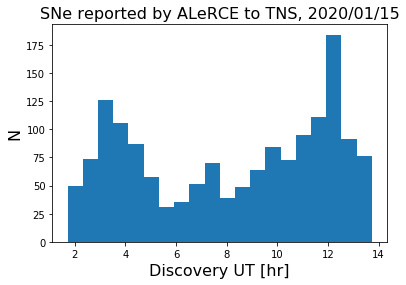

In [83]:
fig, ax = plt.subplots()
ax.hist(df.first_UT, bins=20)
ax.set_xlabel("Discovery UT [hr]", fontsize=16)
ax.set_ylabel("N", fontsize=16)
if mode=="tns":
    ax.set_title("SNe reported by ALeRCE to TNS, %i/%02i/%02i" % 
                 (now.year, now.month, now.day), fontsize = 16)
elif mode=="all":
    ax.set_title("SNe identified by ALeRCE, %i/%02i/%02i" % 
                 (now.year, now.month, now.day), fontsize = 16)
plt.savefig("plots/discovery_UT.png")


### Histogram of RA DEC coordinates

In [84]:
import ephem

In [85]:
df["ecl_lat"] = df.apply(lambda row: np.rad2deg(ephem.Ecliptic(ephem.Equatorial('%s' % (row.ra / 15.), '%s' % row.dec, epoch=ephem.J2000)).lat), axis=1)

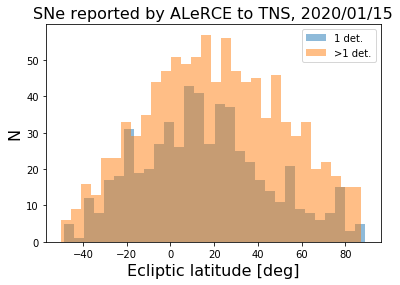

In [86]:
fig, ax = plt.subplots()
mask = df.nobs == 1
ax.hist(df.ecl_lat[mask], bins=30, label="1 det.", alpha=0.5)
ax.hist(df.ecl_lat[~mask], bins=30, label=">1 det.", alpha=0.5)
ax.legend()
ax.set_xlabel("Ecliptic latitude [deg]", fontsize=16)
ax.set_ylabel("N", fontsize=16)
if mode=="tns":
    ax.set_title("SNe reported by ALeRCE to TNS, %i/%02i/%02i" % 
                 (now.year, now.month, now.day), fontsize = 16)
elif mode=="all":
    ax.set_title("SNe identified by ALeRCE, %i/%02i/%02i" % 
                 (now.year, now.month, now.day), fontsize = 16)
plt.savefig("plots/discovery_ecl_lat.png")


### Cumulative distribution of MJD times

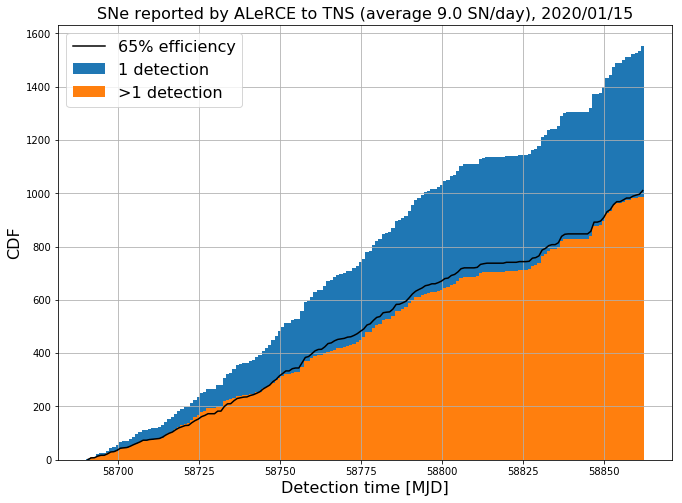

In [87]:
fig, ax = plt.subplots(figsize = (11, 8))
x, y, _ = ax.hist(df.first_mjd, bins = np.linspace(df.first_mjd.min(), df.first_mjd.max(), df.first_mjd.max() - df.first_mjd.min() + 1), cumulative = True, label="1 detection")
ax.set_xlabel("Detection time [MJD]", fontsize = 16)
ax.grid(which='both')
ax.set_ylabel("CDF", fontsize = 16)
if mode=="tns":
    ax.set_title("SNe reported by ALeRCE to TNS (average %.1f SN/day), %i/%02i/%02i" % 
                 (len(oids) / (df.first_mjd.max() - df.first_mjd.min()), now.year, now.month, now.day), fontsize = 16)
elif mode=="all":
    ax.set_title("SNe identified by ALeRCE (average %.1f SN/day), %i/%02i/%02i" % 
                 (df.shape[0] / (df.first_mjd.max() - df.first_mjd.min()), now.year, now.month, now.day), fontsize = 16)
efficiency = 0.65
plt.savefig("plots/firstmjd.png")
ax.hist(df[df.nobs > 1].first_mjd, bins = np.linspace(df.first_mjd.min(), df.first_mjd.max(), df.first_mjd.max() - df.first_mjd.min() + 1), cumulative = True, label=">1 detection")
ax.plot((y[:-1] + y[1:]) / 2, x * efficiency, c = 'k', label="%i%% efficiency" % (efficiency * 100.))
ax.legend(fontsize=16)
plt.savefig("plots/firstmjd_efficiency_%s.png" % mode)
plt.savefig("plots/firstmjd_efficiency_%s.pdf" % mode)

# Do mosaic of stamps

In [88]:
def plot_stamp(self, oid, candid=None):
    'plot stamp in a notebook given oid. It uses IPython HTML.'

    # if candid is None, get minimum candid                                                                                                                                                                    
    if candid is None:
        candid = min(self.get_detections(oid).index)

    science = "http://avro.alerce.online/get_stamp?oid=%s&candid=%s&type=science&format=png" % (oid, candid)
    images="""                                                                                                                                                                                                 
    <div>ZTF oid: %s, candid: %s</div>                                                                                                                                                                         
    <div>&emsp;&emsp;&emsp;&emsp;&emsp;                                                                                                                                                                        
    Science                                                                                                                                                                                                    
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;                                                                                                                                   
    Template                                                                                                                                                                                                   
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;                                                                                                                                   
    Difference                                                                                                                                                                                                 
    <div class="container">                                                                                                                                                                                    
    <div style="float:left;width:20%%"><img src="%s"></div>                                                                                                                                                    
    <div style="float:left;width:20%%"><img src="%s"></div>                                                                                                                                                    
    <div style="float:left;width:20%%"><img src="%s"></div>                                                                                                                                                    
    </div>                                                                                                                                                                                                     
    """ % (oid, candid, science, science.replace("science", "template"), science.replace("science", "difference"))
    display(HTML(images))


# Distribution of number of detections

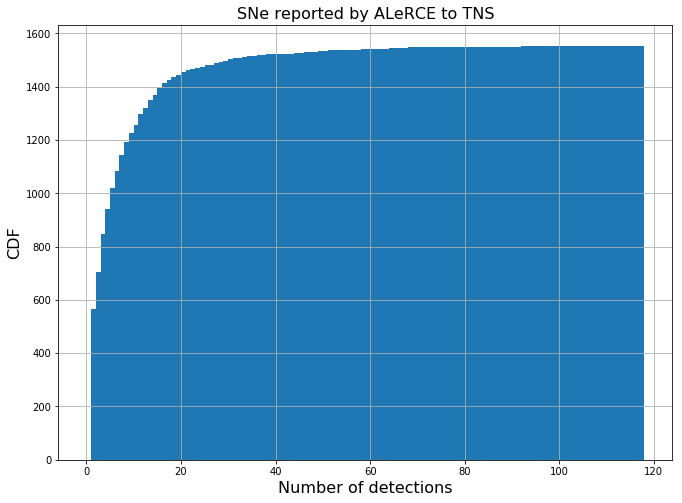

In [89]:
fig, ax = plt.subplots(figsize = (11, 8))
ax.hist(df.nobs, bins = np.linspace(0, df.nobs.max(), df.nobs.max() + 1), cumulative = True)
ax.set_xlabel("Number of detections", fontsize = 16)
ax.grid(which='both')
ax.set_ylabel("CDF", fontsize = 16)
ax.set_title("SNe reported by ALeRCE to TNS", fontsize = 16)
plt.savefig("plots/nobs.png")

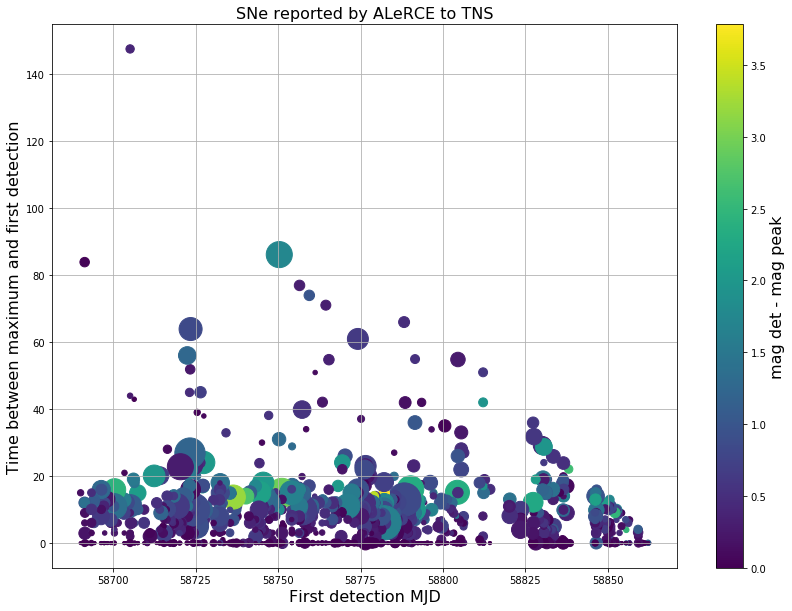

In [90]:
fig, ax = plt.subplots(figsize = (14, 10))
sc = ax.scatter(df.first_mjd, df.dt_first_max, s = 10 * df.nobs, c = df.dmag_first_max)
cbar = fig.colorbar(sc)
cbar.set_label("mag det - mag peak", fontsize=16)
ax.set_xlabel("First detection MJD", fontsize = 16)
ax.grid(which='both')
ax.set_ylabel("Time between maximum and first detection", fontsize = 16)
ax.set_title("SNe reported by ALeRCE to TNS", fontsize = 16)
plt.savefig("plots/dt_first_max_firstMJD.png")

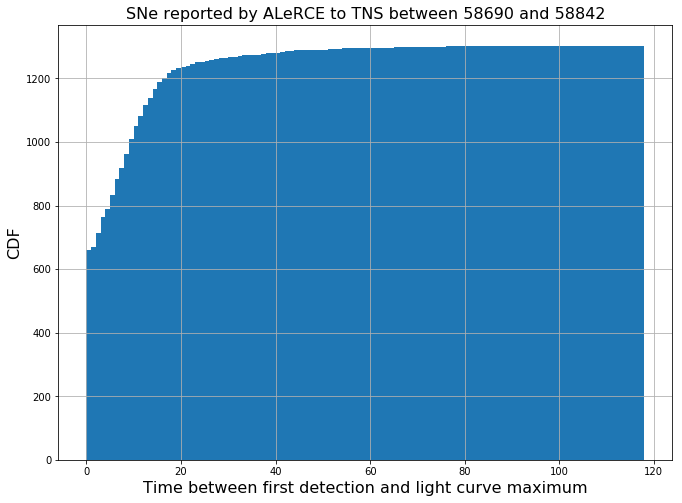

In [91]:
fig, ax = plt.subplots(figsize = (11, 8))
ax.hist(df.dt_first_max[df.first_mjd < df.first_mjd.max() - 20], bins = np.linspace(0, df.nobs.max(), df.nobs.max() + 1), cumulative = True)
ax.set_xlabel("Time between first detection and light curve maximum", fontsize = 16)
ax.grid(which='both')
ax.set_ylabel("CDF", fontsize = 16)
ax.set_title("SNe reported by ALeRCE to TNS between %i and %i" % (df.first_mjd.min(), df.first_mjd.max() - 20), fontsize = 16)
plt.savefig("plots/dt_first_mag.png")

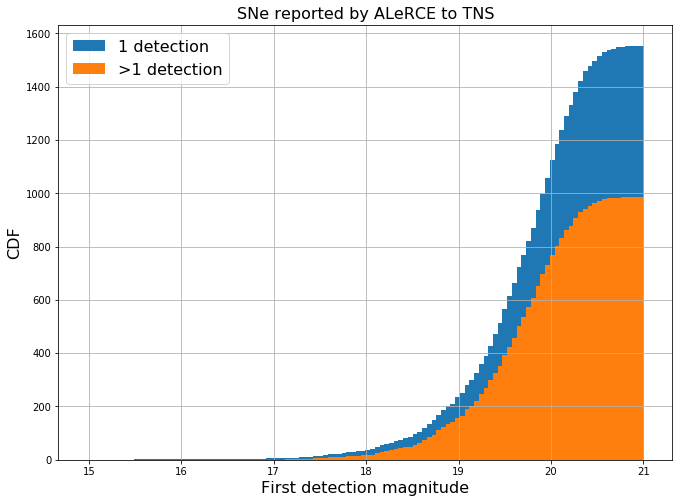

In [92]:
fig, ax = plt.subplots(figsize = (11, 8))
ax.hist(df.first_det_mag, bins = np.linspace(df.first_det_mag.min(), df.first_det_mag.max(), df.nobs.max() + 1), cumulative = True, label="1 detection")
ax.hist(df[df.nobs > 1].first_det_mag, bins = np.linspace(df.first_det_mag.min(), df.first_det_mag.max(), df.nobs.max() + 1), cumulative = True, label=">1 detection")
ax.legend(fontsize=16)
ax.set_xlabel("First detection magnitude", fontsize = 16)
ax.grid(which='both')
ax.set_ylabel("CDF", fontsize = 16)
ax.set_title("SNe reported by ALeRCE to TNS", fontsize = 16)
plt.savefig("plots/mags.png")

1554 SNe reported (excluding 21 retracted)
Average number of detections: 10
Median number of detections: 6
Fraction of candidates with >1 detections: 0.635135
SNe with time between 1st detection and last non-detection < 1 day: 206
SNe with time between 2nd detection and last non-detection < 1 day: 53
Median time between 1st detection and last non-detection:  nan [days]
Median time between 2nd detection and last non-detection: 6.95 [days]


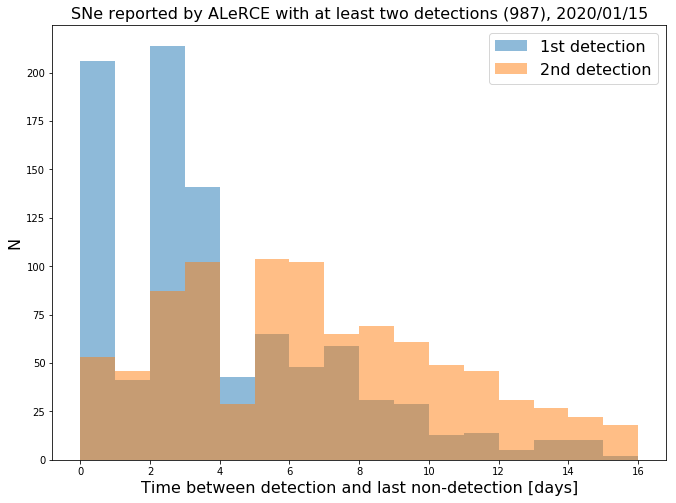

In [93]:
fig, ax = plt.subplots(figsize = (11, 8))
ax.hist(df.dt[df.nobs > 1], alpha = 0.5, bins = np.linspace(0, 16, 17), label = "1st detection" )
ax.hist(df.dt2[df.nobs > 1], alpha = 0.5, bins = np.linspace(0, 16, 17), label = "2nd detection")
ax.set_xlabel("Time between detection and last non-detection [days]", fontsize = 16)
print("%i SNe reported (excluding %i retracted)" % (df.nobs.shape[0], len(retracted)))
print("Average number of detections: %i" % np.average(df.nobs[df.nobs > 1]))
print("Median number of detections: %i" % np.median(df.nobs[df.nobs > 1]))
print("Fraction of candidates with >1 detections: %f" % (np.sum(df.nobs > 1) / df.nobs.shape[0]))
print("SNe with time between 1st detection and last non-detection < 1 day: %i" % np.sum(df.dt[df.nobs > 1] < 1))
print("SNe with time between 2nd detection and last non-detection < 1 day: %i" % np.sum(df.dt2[df.nobs > 1] < 1))
print("Median time between 1st detection and last non-detection: %4.2f [days]" % np.median(df.dt[df.nobs > 1]))
print("Median time between 2nd detection and last non-detection: %4.2f [days]" % np.median(df.dt2[df.nobs > 1]))
ax.set_ylabel("N", fontsize = 16)
ax.legend(fontsize = 16)
if mode=="tns":
    ax.set_title("SNe reported by ALeRCE with at least two detections (%i), %i/%02i/%02i" % (np.sum(df.nobs > 1), now.year, now.month, now.day), fontsize = 16)
elif mode=="all":
    ax.set_title("SNe identified by ALeRCE with at least two detections (%i), %i/%02i/%02i" % (np.sum(df.nobs > 1), now.year, now.month, now.day), fontsize = 16)
plt.savefig("plots/TimeSinceDetection_%s.png" % mode)
plt.savefig("plots/TimeSinceDetection_%s.pdf" % mode)

# Show number of SNe with a lower non-detection in the same filter within the last 25 hr

Index(['ZTF19adcbxkw', 'ZTF19abvdgqo', 'ZTF19abueupg'], dtype='object', name='oid')


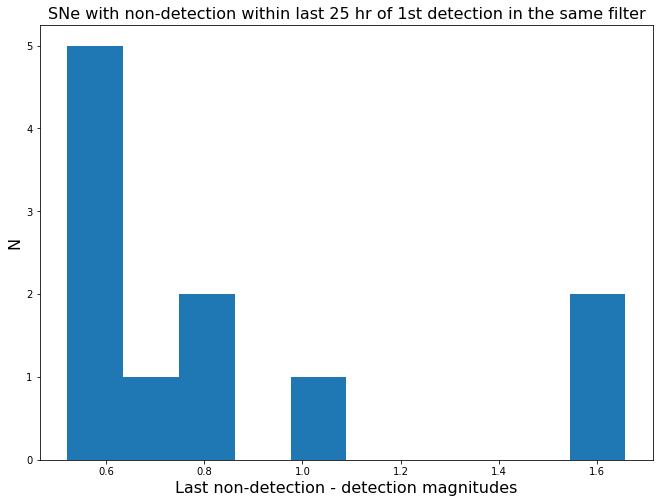

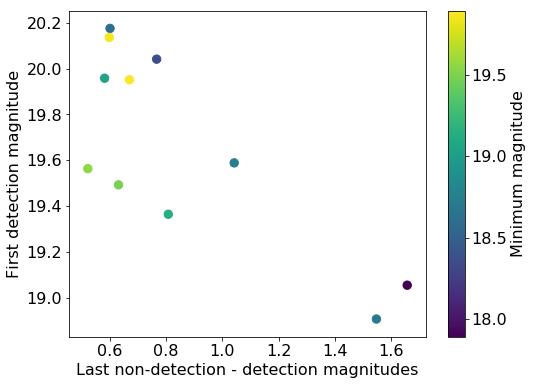

In [109]:
fig, ax = plt.subplots(figsize = (11, 8))
lasthr = 25.
mask = (df.dmag_fid.notna())  & (df.dmag_fid > 0.5) & (df.dt_fid <= lasthr / 24.) & (df.nobs > 1)
ax.hist(df.dmag_fid[mask], alpha = 1, bins=10)# cumulative=True)#,
        #label = "%s SNe @ %i/%02i/%02i" % (mask.sum(), now.year, now.month, now.day))#, cumulative=True)
#ax.set_xlabel("Time between detection and last non-detection [days]", fontsize = 16)
#print("%i SNe reported (excluding %i retracted)" % (df.nobs.shape[0], len(retracted)))
#print("Average number of detections: %i" % np.average(df.nobs[df.nobs > 1]))
#print("Median number of detections: %i" % np.median(df.nobs[df.nobs > 1]))
#print("Fraction of candidates with >1 detections: %f" % (np.sum(df.nobs > 1) / df.nobs.shape[0]))
#print("SNe with time between 1st detection and last non-detection < 1 day: %i" % np.sum(df.dt[df.nobs > 1] < 1))
#print("SNe with time between 2nd detection and last non-detection < 1 day: %i" % np.sum(df.dt2[df.nobs > 1] < 1))
#print("Median time between 1st detection and last non-detection: %4.2f [days]" % np.median(df.dt[df.nobs > 1]))
#print("Median time between 2nd detection and last non-detection: %4.2f [days]" % np.median(df.dt2[df.nobs > 1]))
ax.set_xlabel("Last non-detection - detection magnitudes", fontsize = 16)
ax.set_ylabel("N", fontsize = 16)
ax.set_title("SNe with non-detection within last %i hr of 1st detection in the same filter" % (lasthr), fontsize = 16)
#ax.legend(fontsize=16, loc = 1)
plt.savefig("plots/Deltamag.png")
plt.savefig("plots/Deltamag.pdf")
print(df.loc[mask & (df.dmag_fid > 1)].index)


fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(df.dmag_fid[mask], df.first_det_mag[mask], c = df.mag_at_max[mask], s=70)
cbar = fig.colorbar(sc, ticks =[18, 18.5, 19, 19.5, 20])
cbar.set_label('Minimum magnitude', fontsize=16)
cbar.ax.tick_params(which='major',labelsize=16)
ax.set_xlabel("Last non-detection - detection magnitudes", fontsize = 16)
ax.set_ylabel("First detection magnitude", fontsize = 16)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.savefig("plots/mag_dmag.png")

for oid in mask[mask].index:
    display(HTML("<a href='http://alerce.online/object/%s'> %s <a>" % (oid, oid)))

15


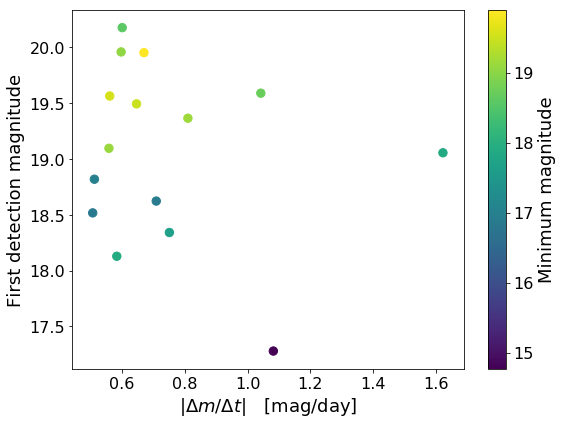

In [95]:
mask =  (df.dmdt_fid.notna()) & (df.dmdt_fid > 0.5) & (df.dmdt_fid < 20) & (df.dmag_fid > 0.5)  & (df.nobs>1)
print(mask.sum())

fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(df.dmdt_fid[mask], df.first_det_mag[mask], c = df.mag_at_max[mask], s=70)
cbar = fig.colorbar(sc)#, ticks =[17, 17.18, 18.5, 19, 19.5, 20])
cbar.set_label('Minimum magnitude', fontsize=18)
cbar.ax.tick_params(which='major',labelsize=16)
ax.set_xlabel(r"$|\Delta m/ \Delta t|$   [mag/day]", fontsize = 18)
ax.set_ylabel("First detection magnitude", fontsize = 18)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.tight_layout()
plt.savefig("plots/dmdt.png")

for oid in mask[mask].index:
    display(HTML("<a href='http://alerce.online/object/%s'> %s <a>" % (oid, oid)))

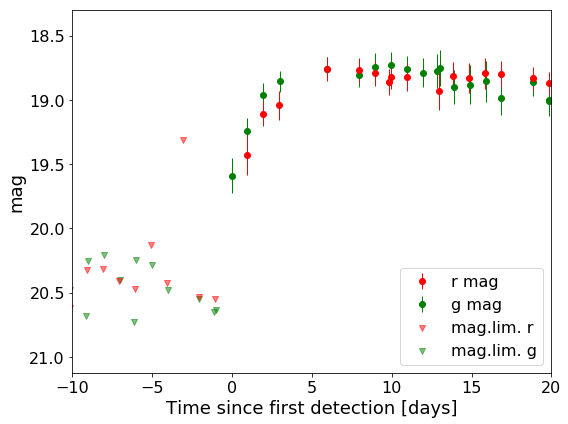

In [96]:
oid = 'ZTF19abueupg'#'ZTF19abvdgqo'
det = alerce.get_detections(oid, format='pandas')
nondet = alerce.get_non_detections(oid, format='pandas')
fig, ax = plt.subplots(figsize=(8,6))
colors = {1: 'g', 2: 'r'}
mjd0 = det.mjd.min()
for fid in [1, 2]:
    mask = det.fid == fid
    ax.errorbar(det.mjd[mask] - mjd0, det.magpsf[mask], yerr=det.sigmapsf[mask], marker='o', lw=0, elinewidth=1, c=colors[fid], label="%s mag" % colors[fid])
    mask = (nondet.fid == fid) & (nondet.index < det.mjd.min())
    ax.scatter(nondet.index[mask] - mjd0, nondet.diffmaglim[mask], marker='v', c=colors[fid], alpha=0.5, label="mag.lim. %s" % colors[fid])
ax.set_ylim(ax.get_ylim()[1], 18.3)
ax.set_xlim(-10, 20)
ax.tick_params(axis='both', which='major', labelsize=16)
#ax.tick_params(axis='y', which='major', labelsize=16)
ax.set_xlabel("Time since first detection [days]", fontsize=18)
ax.set_ylabel("mag", fontsize=18)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], fontsize=16, loc=4)
plt.tight_layout()
plt.savefig("BestSN.png")

# Find distribution of time between detection and 5th detection in the same band

In [97]:
mask = (df.nobs > 5)
dt_5th = {}
for oid in df[mask].index:
    mask = all_detections.oid == oid
    for fid in all_detections[mask].fid.unique():
        mask = (all_detections.oid == oid) & (all_detections.fid == fid)
        if mask.sum() == 0:
            continue
        fid_mjds = all_detections[mask].mjd.values
        if len(fid_mjds) > 4:
            if oid in dt_5th.keys():
                dt_5th[oid] = min(dt_5th[oid], fid_mjds[4] - df.loc[oid].first_mjd)
            else:
                dt_5th[oid] = fid_mjds[4] - df.loc[oid].first_mjd

4.00064586011722
14.938032399797521
38.95493516008136


429

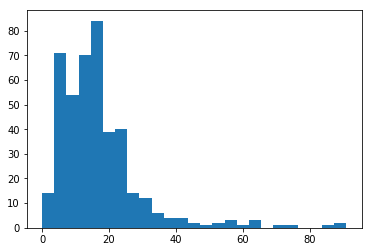

In [98]:
fig, ax = plt.subplots()
ax.hist(dt_5th.values(), bins=25)
print(np.percentile(np.array(list(dt_5th.values())), 5))
print(np.median(np.array(list(dt_5th.values()))))
print(np.percentile(np.array(list(dt_5th.values())), 95))
len(dt_5th)

In [99]:
mask = (df.nobs > 5) & (df.dmag_fid > 0) & (df.dt_fid <= lasthr / 24.)
ax.hist(df.dmag_fid[mask].dropna(), alpha = 0.5, bins=20, label = "%s SNe @ %i/%02i/%02i" % (mask.sum(), now.year, now.month, now.day))
#ax.set_xlabel("Time between detection and last non-detection [days]", fontsize = 16)
#print("%i SNe reported (excluding %i retracted)" % (df.nobs.shape[0], len(retracted)))
#print("Average number of detections: %i" % np.average(df.nobs[df.nobs > 1]))
#print("Median number of detections: %i" % np.median(df.nobs[df.nobs > 1]))
#print("Fraction of candidates with >1 detections: %f" % (np.sum(df.nobs > 1) / df.nobs.shape[0]))
#print("SNe with time between 1st detection and last non-detection < 1 day: %i" % np.sum(df.dt[df.nobs > 1] < 1))
#print("SNe with time between 2nd detection and last non-detection < 1 day: %i" % np.sum(df.dt2[df.nobs > 1] < 1))
#print("Median time between 1st detection and last non-detection: %4.2f [days]" % np.median(df.dt[df.nobs > 1]))
#print("Median time between 2nd detection and last non-detection: %4.2f [days]" % np.median(df.dt2[df.nobs > 1]))
ax.set_xlabel("Last non-detection - detection magnitudes", fontsize = 16)
ax.set_ylabel("N", fontsize = 16)
ax.set_title("Rising SNe reported by ALeRCE, non-det. within last %i hr of 1st det. in same filter" % (lasthr), fontsize = 16)
ax.legend(fontsize=16, loc = 1)
plt.savefig("plots/Deltamag.png")
plt.savefig("plots/Deltamag.pdf")
print(df.loc[mask & (df.dmag_fid > 1)].index)

Index(['ZTF19adcbxkw', 'ZTF19abvdgqo', 'ZTF19abueupg'], dtype='object', name='oid')


<Figure size 432x288 with 0 Axes>

In [100]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.models import ColumnDataSource, OpenURL, TapTool

output_notebook()

Loading BokehJS ...

In [101]:
df["nobs_t"] = 5 + df.nobs
df["dmdt"] = df.dmag_fid / df.dt_fid

In [110]:
from bokeh.palettes import Spectral10
from bokeh.palettes import Viridis256
from bokeh.transform import linear_cmap


p = figure(
    plot_width = 800,
    plot_height = 600,
    tools=('pan, wheel_zoom, box_zoom, reset, tap')
)
p.add_tools(HoverTool(tooltips="""
<div>
    <div><span style='font-size: 12px'>oid: @oid</span></div>    
    <div><span style='font-size: 12px'>nobs: @nobs</span></div>    
    <div><span style='font-size: 12px'>dt: @dt</span></div>    
    <div><span style='font-size: 12px'>dt2: @dt2</span></div>    
    <div><span style='font-size: 12px'>dt_fid: @dt_fid</span></div>
    <div><span style='font-size: 12px'>dmag_fid: @dmag_fid</span></div>
    <div><span style='font-size: 12px'>first_mjd: @first_mjd</span></div>
    <div><span style='font-size: 12px'>dmdt: @dmdt</span></div>

</div>
"""))

taptool = p.select(type = TapTool)
url = "http://dev.alerce.online/vue/object/@oid"
taptool.callback = OpenURL(url=url)

color_col = 'first_mjd'
mapper = linear_cmap(field_name=color_col, palette=Viridis256,low=df.first_mjd.min(), high=df.first_mjd.max())

x_col = 'dt_fid'
y_col = 'dmag_fid'
size_col = 'nobs_t'
p.circle(
    x_col,
    y_col,
    source = df,
    color = mapper,
    size = size_col,
    line_alpha = 0.6,
    fill_alpha = 0.6
)

p.xaxis.axis_label = x_col
p.yaxis.axis_label = y_col
p.title.text = ("%s vs %s (size: %s, color: %s)" % (x_col, y_col, size_col, color_col))
show(p)


In [111]:
from bokeh.palettes import Spectral10
from bokeh.palettes import Viridis256
from bokeh.transform import linear_cmap


p = figure(
    plot_width = 1000,
    plot_height = 600,
    tools=('pan, wheel_zoom, box_zoom, reset, tap')
)
p.add_tools(HoverTool(tooltips="""
<div>
    <div><span style='font-size: 12px'>oid: @oid</span></div>    
    <div><span style='font-size: 12px'>nobs: @nobs</span></div>    
    <div><span style='font-size: 12px'>dt: @dt</span></div>    
    <div><span style='font-size: 12px'>dt2: @dt2</span></div>    
    <div><span style='font-size: 12px'>dt_fid: @dt_fid</span></div>
    <div><span style='font-size: 12px'>dmag_fid: @dmag_fid</span></div>
    <div><span style='font-size: 12px'>first_mjd: @first_mjd</span></div>
    <div><span style='font-size: 12px'>dmdt: @dmdt</span></div>

</div>
"""))

taptool = p.select(type = TapTool)
url = "http://alerce.online/vue/object/@oid"
taptool.callback = OpenURL(url=url)

color_col = 'dmag_first_max'
mapper = linear_cmap(field_name=color_col, palette=Viridis256,low=df.dmag_first_max.min(), high=df.dmag_first_max.max())


x_col = 'first_mjd'
y_col = 'dt_first_max'
size_col = 'nobs_t'
p.circle(
    x_col,
    y_col,
    source = df,
    color = mapper,
    size = size_col,
    line_alpha = 0.6,
    fill_alpha = 0.6
)

p.xaxis.axis_label = x_col
p.yaxis.axis_label = y_col
p.title.text = ("%s vs %s (size: %s, color: %s)" % (y_col, x_col, size_col, color_col))
show(p)


In [104]:
from bokeh.palettes import Spectral10
from bokeh.palettes import Viridis256
from bokeh.transform import linear_cmap


p = figure(
    plot_width = 800,
    plot_height = 600,
    tools=('pan, wheel_zoom, box_zoom, reset, tap')
)
p.add_tools(HoverTool(tooltips="""
<div>
    <div><span style='font-size: 12px'>oid: @oid</span></div>    
    <div><span style='font-size: 12px'>nobs: @nobs</span></div>    
    <div><span style='font-size: 12px'>dt: @dt</span></div>    
    <div><span style='font-size: 12px'>dt2: @dt2</span></div>    
    <div><span style='font-size: 12px'>dt_fid: @dt_fid</span></div>
    <div><span style='font-size: 12px'>dmag_fid: @dmag_fid</span></div>
    <div><span style='font-size: 12px'>first_mjd: @first_mjd</span></div>
    <div><span style='font-size: 12px'>dmdt: @dmdt</span></div>

</div>
"""))

taptool = p.select(type = TapTool)
url = "http://dev.alerce.online/vue/object/@oid"
taptool.callback = OpenURL(url=url)

#sc = ax.scatter(df.dmdt_fid[mask], df.first_det_mag[mask], c = df.mag_at_max[mask], s=70)

mask =  (df.dmdt_fid.notna()) & (df.dmdt_fid > 0.2) & (df.dmdt_fid < 20) & (df.dmag_fid > 0.5)  & (df.nobs>1)
color_col = 'mag_at_max'
mapper = linear_cmap(field_name=color_col, palette=Viridis256,low=df[mask][color_col].min(), high=df[mask][color_col].max())

x_col = 'dmdt_fid'
y_col = 'first_det_mag'
size_col = 'dmag_first_max'
p.circle(
    x_col,
    y_col,
    source = df.loc[mask],
    color = mapper,
    size = 20,
    line_alpha = 0.6,
    fill_alpha = 0.6
)

p.xaxis.axis_label = x_col
p.yaxis.axis_label = y_col
p.title.text = ("%s vs %s (size: %s, color: %s)" % (x_col, y_col, size_col, color_col))
show(p)


In [105]:
mask.sum()

92

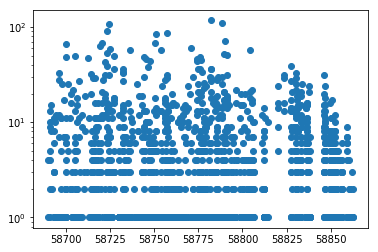

In [106]:
fig, ax = plt.subplots()
ax.scatter(df.first_mjd, df.nobs)
ax.set_yscale("log")

In [107]:
(df.dec < 30).sum() /  (df.dec < 90).sum()

0.6222651222651223

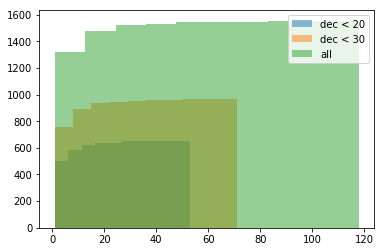

In [108]:
fig, ax = plt.subplots()
mask = df.dmag > 0
ax.hist(df.nobs[df.dec < 15], cumulative=True, alpha=0.5, label = "dec < 20")
ax.hist(df.nobs[df.dec < 30], cumulative=True, alpha=0.5, label = "dec < 30")
ax.hist(df.nobs[df.dec < 90], cumulative=True, alpha=0.5, label = 'all')
plt.legend()

# Obtain TNS stats (scrapping)

In [308]:
#results = {}
#specs = {}
#for name in all_alerce.Name.values:
#    objname = name[3:]
#    print(objname, len(results))
#    url = "https://wis-tns.weizmann.ac.il/object/%s" % objname
#    response = requests.get(url)
#    results[objname] = re.findall("cell-time_received.>(.*?)<.*cell-user_name.>(.*?)<.*cell-source_group_name.>(.*?)<.*cell-discovery_date.>(.*?)<.*", response.text)[1:]
#    specs[objname] = re.findall("spectrum.*?cell-id.>.*?cell-obsdate.>(.*?)<.*cell-tel_inst.>(.*?)<.*cell-exptime.>(.*?)<.*cell-observer.>(.*?)<.*", response.text)[1:]

2019rmo 0
2019rmn 1
2019rmm 2
2019rml 3
2019rmk 4
2019rmj 5
2019rmi 6
2019rmh 7
2019rmg 8
2019rmf 9
2019rme 10
2019rmd 11
2019rmc 12
2019rmb 13
2019rma 14
2019rlz 15
2019rly 16
2019rlx 17
2019rlw 18
2019rlv 19
2019rlu 20
2019rlt 21
2019rls 22
2019rlr 23
2019rlq 24
2019rlp 25
2019rlo 26
2019rln 27
2019rlm 28
2019rij 29
2019rii 30
2019rih 31
2019rig 32
2019rif 33
2019rie 34
2019rid 35
2019ric 36
2019rib 37
2019ria 38
2019rhz 39
2019rhy 40
2019rhx 41
2019rhw 42
2019rhv 43
2019rhu 44
2019rht 45
2019rhs 46
2019rbb 47
2019qxl 48
2019qxk 49
2019qxj 50
2019qxi 51
2019qxh 52
2019qxg 53
2019qxf 54
2019qxe 55
2019qxd 56
2019qxc 57
2019qxb 58
2019qxa 59
2019qwz 60
2019qwy 61
2019qwx 62
2019qww 63
2019qwv 64
2019qwu 65
2019qvr 66
2019qvq 67
2019qvp 68
2019qvo 69
2019qvn 70
2019qvm 71
2019qvl 72
2019qvk 73
2019qvj 74
2019qvi 75
2019qvh 76
2019qvg 77
2019qvf 78
2019qve 79
2019qst 80
2019qss 81
2019qsr 82
2019qsq 83
2019qsp 84
2019qso 85
2019qsn 86
2019qsm 87
2019qsl 88
2019qsk 89
2019qsj 90
2019qsi 9

### Save results

In [499]:
#import pickle
#with open('wis_results.pkl', 'wb') as handle:
#    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
#with open('wis_specs.pkl', 'wb') as handle:
#    pickle.dump(specs, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Load results

In [116]:
import pickle
results = pickle.load(open('wis_results.pkl', 'rb'))
specs = pickle.load(open('wis_specs.pkl', 'rb'))

In [117]:
for SN in list(specs.keys()):
    if specs[SN] == []:
        del specs[SN]

In [118]:
delta_report = []
delta_2ndreport = []
group_2ndreport = []
delta_clf = []
mjd_disc = []
for SN in results.keys():
    #if not SN in specs.keys():
    #    continue
    report_2nd = 1e99
    clf_date = 1e99
    if len(results[SN]) > 0:
        for r in results[SN]:
            report_day = Time(r[0].replace(" ", "T")).mjd
            disc_day = Time(r[3].replace(" ", "T")).mjd
            disc_group = r[1]
            if disc_group == "ALeRCE":
                first_detection = disc_day
                report_ALeRCE = report_day
                delta_report.append(report_day - first_detection)
                mjd_disc.append(disc_day)
                if SN in specs.keys():
                    if specs[SN] != []:
                        clf_day = Time(specs[SN][0][0].replace(" ", "T")).mjd
                        delta_clf.append(clf_day - first_detection)
            else:
                if report_day < report_2nd:# and disc_group[:3] == "ZTF" :
                    report_2nd = report_day
                    report_group = disc_group
    if report_2nd < 1e99:
        delta_2ndreport.append(report_2nd - first_detection)
        group_2ndreport.append((SN, report_group))
                
                
delta_report = np.array(delta_report)
delta_2ndreport = np.array(delta_2ndreport)
mjd_disc = np.array(mjd_disc)

In [119]:
cl, n = np.unique(np.array(group_2ndreport)[:, 1], return_counts=True)

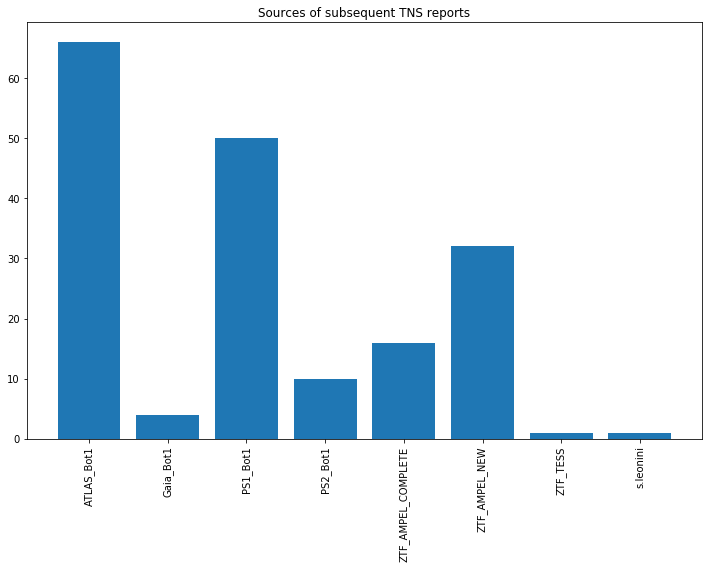

In [120]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.bar(cl, n)
plt.xticks(rotation=90)
ax.set_title("Sources of subsequent TNS reports")
plt.tight_layout()
plt.savefig("plots/OtherSources.png")

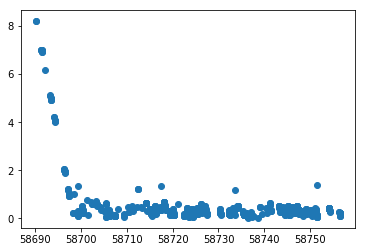

In [121]:
fig, ax = plt.subplots()
ax.scatter(mjd_disc, delta_report)#, bins=100, cumulative=True);

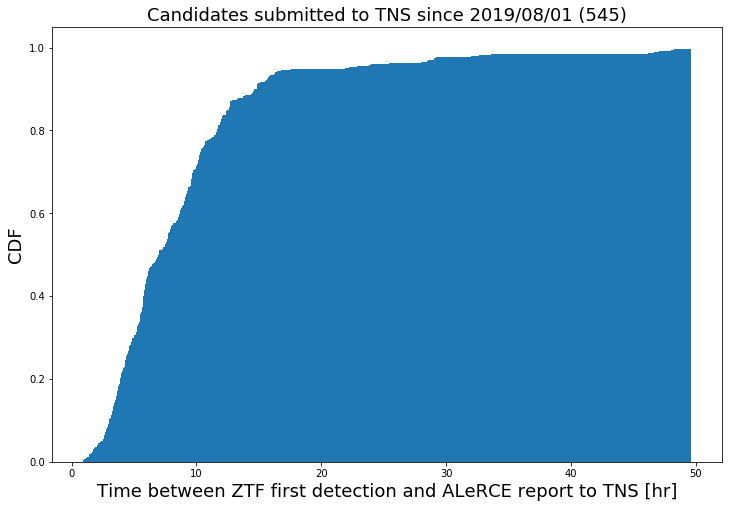

In [122]:
fig, ax = plt.subplots(figsize=(12, 8))
refmjd = 58696
ax.hist(delta_report[mjd_disc > refmjd] * 24., bins=1000, cumulative=True, density=True);
ax.set_title("Candidates submitted to TNS since %i/%02i/%02i (%i)" %
             (Time(refmjd, format='mjd').datetime.year,
              Time(refmjd, format='mjd').datetime.month,
              Time(refmjd, format='mjd').datetime.day,
              len(delta_report[mjd_disc > 58697])), fontsize=18)
ax.set_xlabel("Time between ZTF first detection and ALeRCE report to TNS [hr]", fontsize=18)
ax.set_ylabel("CDF", fontsize=18)
plt.savefig("plots/Report_times.png")

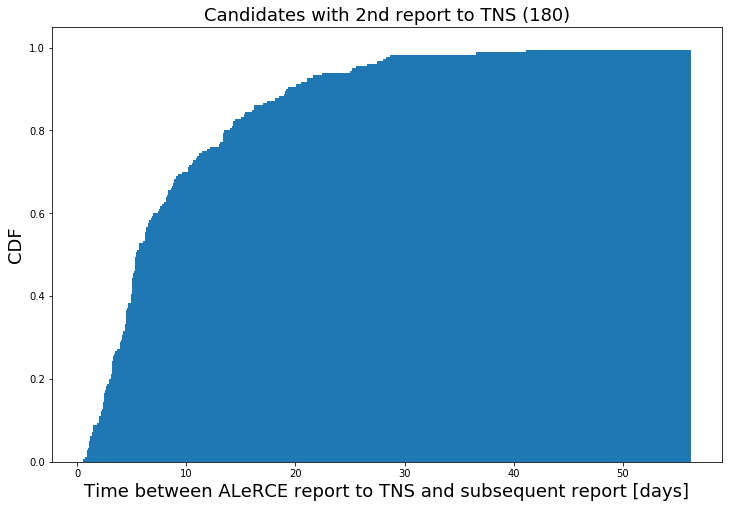

In [123]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.hist(delta_2ndreport, bins=1000, cumulative=True, density=True);
ax.set_title("Candidates with 2nd report to TNS (%i)" % len(delta_2ndreport), fontsize=18)
ax.set_xlabel("Time between ALeRCE report to TNS and subsequent report [days]", fontsize=18)
ax.set_ylabel("CDF", fontsize=18)
plt.savefig("plots/ALeRCE_vs_rest.png")

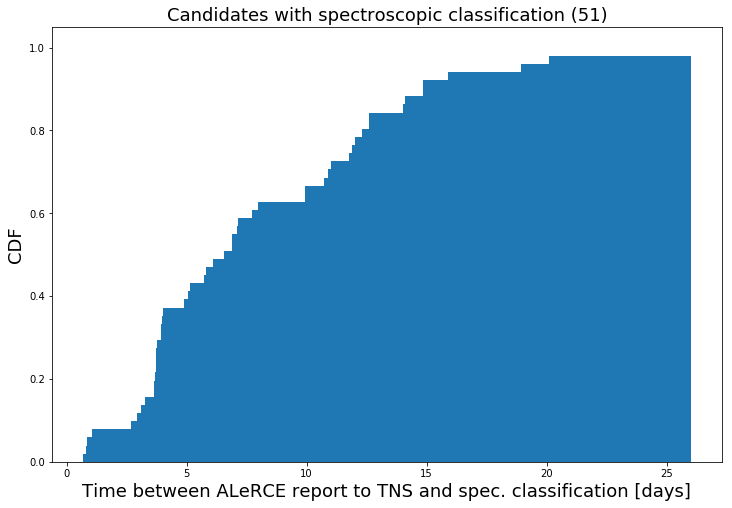

In [124]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.hist(delta_clf, bins=1000, density=True, cumulative=True);
ax.set_title("Candidates with spectroscopic classification (%i)" % len(delta_clf), fontsize=18)
ax.set_xlabel("Time between ALeRCE report to TNS and spec. classification [days]", fontsize=18)
ax.set_ylabel("CDF", fontsize=18)
plt.savefig("plots/ALeRCE_classification.png")

In [125]:
print(np.median(delta_report[mjd_disc > refmjd]))

0.2903356481474475


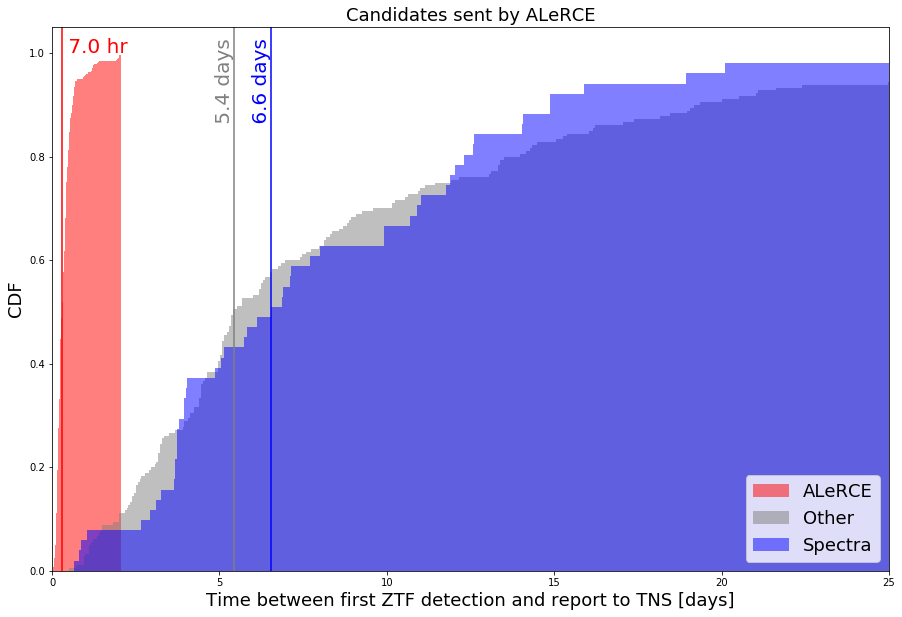

In [126]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.hist(delta_report[mjd_disc > refmjd], bins=1000, density=True, alpha=0.5, cumulative=True, color = 'r', label='ALeRCE');
ax.hist(delta_2ndreport, bins=1000, density=True, alpha=0.5, cumulative=True, label='Other', color = 'gray');
ax.hist(delta_clf, bins=1000, density=True, alpha=0.5, cumulative=True, label='Spectra', color = 'b');
ax.axvline(np.median(delta_report[mjd_disc > refmjd]), c = 'r')
ax.text(np.median(delta_report[mjd_disc > refmjd]), 1.,
        " %.1f hr" % (np.median(delta_report[mjd_disc > refmjd]) * 24.), color = 'r', fontsize=20)
ax.axvline(np.median(delta_2ndreport), c = 'gray')
ax.text(np.median(delta_2ndreport), 1.,
        " %.1f days" % (np.median(delta_2ndreport)), color = 'gray', fontsize=20, rotation=90, ha = 'right')
ax.axvline(np.median(delta_clf), c = 'b')
ax.text(np.median(delta_clf), 1.,
        " %.1f days" % (np.median(delta_clf)), color = 'b', fontsize=20, rotation=90, ha = 'right')
ax.set_title("Candidates sent by ALeRCE", fontsize=18)
ax.set_xlabel("Time between first ZTF detection and report to TNS [days]", fontsize=18)
ax.set_ylabel("CDF", fontsize=18)
ax.set_xlim(0, 25)
ax.legend(fontsize=18, loc=4)
plt.savefig("plots/ALeRCE_Other.pdf")
plt.savefig("plots/ALeRCE_Other.png")

In [53]:
list(zip(group_2ndreport, delta_2ndreport))

[(('2019rij', 'ATLAS_Bot1'), 2.5359722222201526),
 (('2019qvm', 'PS1_Bot1'), 3.10763888888323),
 (('2019qvf', 'Gaia_Bot1'), 6.235150462962338),
 (('2019qsp', 'PS1_Bot1'), 3.6770486111126957),
 (('2019qsg', 'PS1_Bot1'), 5.6986805555497995),
 (('2019qsc', 'Gaia_Bot1'), 3.559988425928168),
 (('2019qqd', 'PS1_Bot1'), 5.386145833334012),
 (('2019qqc', 'ZTF_AMPEL_NEW'), 2.4506018518513883),
 (('2019qpz', 'PS1_Bot1'), 4.5067129629605915),
 (('2019qpy', 'PS1_Bot1'), 5.032465277778101),
 (('2019qnp', 'ZTF_AMPEL_NEW'), 3.3701736111106584),
 (('2019qnk', 'PS1_Bot1'), 7.5820138888884685),
 (('2019qnb', 'PS1_Bot1'), 5.524305555554747),
 (('2019qna', 'PS1_Bot1'), 5.717592592591245),
 (('2019qmx', 'ATLAS_Bot1'), 6.257349537037953),
 (('2019qla', 'ZTF_AMPEL_NEW'), 4.440127314817801),
 (('2019qkz', 'ZTF_AMPEL_NEW'), 4.452893518522615),
 (('2019qky', 'ZTF_AMPEL_NEW'), 4.457037037034752),
 (('2019qkt', 'PS1_Bot1'), 8.865173611113278),
 (('2019qiz', 'ZTF_AMPEL_NEW'), 5.334085648151813),
 (('2019qix', 'ZTF

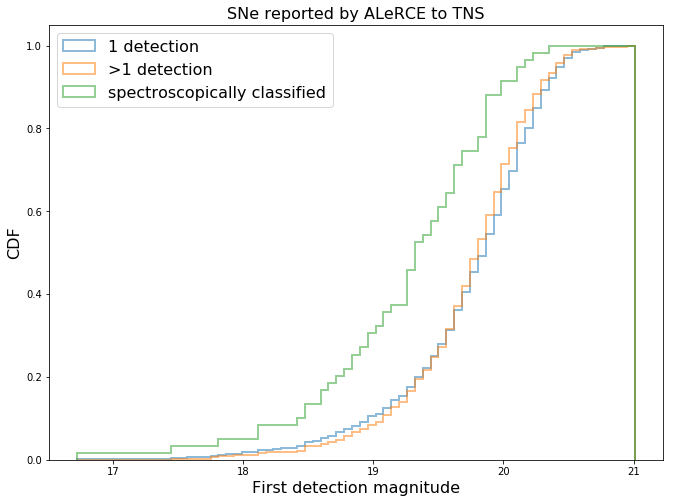

In [55]:
fig, ax = plt.subplots(figsize = (11, 8))
ax.hist(df.first_det_mag, bins = np.linspace(df.first_det_mag.min(), df.first_det_mag.max(), df.nobs.max() + 1),
        cumulative = True, label="1 detection", density=True, alpha = 0.5, histtype='step', lw=2)
ax.hist(df[df.nobs > 1].first_det_mag, bins = np.linspace(df.first_det_mag.min(), df.first_det_mag.max(), df.nobs.max() + 1),
        cumulative = True, label=">1 detection", density=True, alpha = 0.5, histtype='step', lw=2)
ax.hist(all_alerce.loc[classified_mask]["Discovery Mag"], bins = np.linspace(df.first_det_mag.min(), df.first_det_mag.max(), df.nobs.max() + 1),
        cumulative = True, label="spectroscopically classified", density=True, alpha = 0.5, histtype='step', lw=2)
ax.legend(fontsize=16, loc=2)
ax.set_xlabel("First detection magnitude", fontsize = 16)
#ax.grid(which='both')
ax.set_ylabel("CDF", fontsize = 16)
ax.set_title("SNe reported by ALeRCE to TNS", fontsize = 16)
plt.savefig("plots/mags+clf.png")

In [56]:
all_alerce["shortname"] = all_alerce.Name.apply(lambda x: x[3:])

In [57]:
list(all_alerce)

['ID',
 'Name',
 'RA',
 'DEC',
 'Obj. Type',
 'Redshift',
 'Host Name',
 'Host Redshift',
 'Discovering Group/s',
 'Classifying Group/s',
 'Associated Group/s',
 'Disc. Internal Name',
 'Disc. Instrument/s',
 'Class. Instrument/s',
 'TNS AT',
 'Public',
 'End Prop. Period',
 'Discovery Mag',
 'Discovery Mag Filter',
 'Discovery Date (UT)',
 'Sender',
 'Remarks',
 'Ext. catalog/s',
 'url',
 'shortname']

# Do some statistics on ML classified objects

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy import coordinates
from astropy.time import Time
from IPython.display import HTML
from ipywidgets import Layout, Box, widgets

In [59]:
#!pip install psycopg2-binary
import psycopg2

In [63]:
import json
credentials_file = "../usecases/alercereaduser_v2.json"
with open(credentials_file) as jsonfile:
    params = json.load(jsonfile)["params"]

In [64]:
conn = psycopg2.connect(dbname=params['dbname'], user=params['user'], host=params['host'], password=params['password'])

In [65]:
query = "select tablename from pg_tables where schemaname='public';"
tables = pd.read_sql_query(query, conn)
tables.sort_values(by="tablename")

tablename
7                  asassn
16                  class
8               crtsnorth
9               crtssouth
1              detections
14               features
20            features_v2
0              insert_tmp
3   late_probabilities_v2
11                 linear
17                 magref
18         non_detections
2                 objects
12          probabilities
13   stamp_classification
5               tax_class
4                taxonomy
6              temp_probs
19             temp_table
15                    tns
10                 xmatch

In [66]:
alltabs = []
for tab in sorted(tables.tablename):
    cols = pd.DataFrame()
    query = "select column_name, data_type from information_schema.columns where table_name = '%s';" % tab
    results = pd.read_sql_query(query, conn)
    results["table"] = tab
    alltabs.append(results)
dftab = pd.concat(alltabs)
pd.options.display.max_rows = 999
display(dftab[["table", "column_name", "data_type"]])
pd.options.display.max_rows = 101

table                    column_name  \
0                   asassn                   ASAS-SN Name   
1                   asassn                    Other Names   
2                   asassn                           LCID   
3                   asassn                             ra   
4                   asassn                            dec   
5                   asassn                      Mean VMag   
6                   asassn                      Amplitude   
7                   asassn                         Period   
8                   asassn                           Type   
9                   asassn                            Url   
10                  asassn                      Reference   
11                  asassn                           Dist   
12                  asassn                       Parallax   
13                  asassn                 Parallax Error   
14                  asassn                           Gmag   
15                  asassn                          Bpmag   
16                  asassn                          Rpmag   
17                  asassn                           Jmag   
18                  asassn                           Hmag   
19                  asassn                           Kmag   
20                  asassn                          W1mag   
21                  asassn                          W2mag   
22                  asassn                          W3mag   
23                  asassn                          W4mag   
24                  asassn                          BP-RR   
25                  asassn                            J-K   
26                  asassn                          W1-W2   
27                  asassn                          W3-W4   
28                  asassn                 Sllk Statistic   
29                  asassn            RF Regression Score   
30                  asassn     Classification Probability   
31                  asassn                    Epoch (HJD)   
0                    class                             id   
1                    class                           name   
0                crtsnorth            Catalina_Surveys_ID   
1                crtsnorth                   Numerical_ID   
2                crtsnorth                        V_(mag)   
3                crtsnorth                  Period_(days)   
4                crtsnorth                      Amplitude   
5                crtsnorth                     Number_Obs   
6                crtsnorth                       Var_Type   
7                crtsnorth                             ra   
8                crtsnorth                            dec   
0                crtssouth                         SSS_ID   
1                crtssouth                   Numerical_ID   
2                crtssouth                             ra   
3                crtssouth                            dec   
4                crtssouth                         Period   
5                crtssouth                          V_CSS   
6                crtssouth                           Npts   
7                crtssouth                          V_amp   
8                crtssouth                           Type   
0               detections                            oid   
1               detections                         candid   
2               detections                            mjd   
3               detections                            fid   
4               detections                     diffmaglim   
5               detections                         magpsf   
6               detections                          magap   
7               detections                       sigmapsf   
8               detections                       sigmagap   
9               detections                             ra   
10              detections                            dec   
11              detections                        sigmara   
12              detections                       sigmade

In [67]:
query = "select * from class"
classes = pd.read_sql_query(query, conn)
classmapper = dict(zip(classes.name.tolist(), classes.id.tolist()))
classmapper

{'Other': 0,
 'Ceph': 1,
 'LPV': 4,
 'RRL': 5,
 'EB': 3,
 'SNe': 6,
 'DSCT': 2,
 'AGN I': 7,
 'Blazar': 8,
 'CV/Nova': 9,
 'SN Ia': 10,
 'SN Ibc': 11,
 'SN II': 12,
 'SN IIn': 13,
 'SLSN': 14,
 'EB/SD/D': 15,
 'EB/C': 16,
 'Periodic/Other': 17,
 'AGN': 18,
 'SN': 19,
 'Variable Star': 20,
 'Asteroid': 21,
 'Bogus': 22}

Ceph
LPV
RRL
DSCT
AGN I
Blazar
CV/Nova
SN Ia
SN Ibc
SN II
SN IIn
SLSN
EB/SD/D
EB/C
Periodic/Other


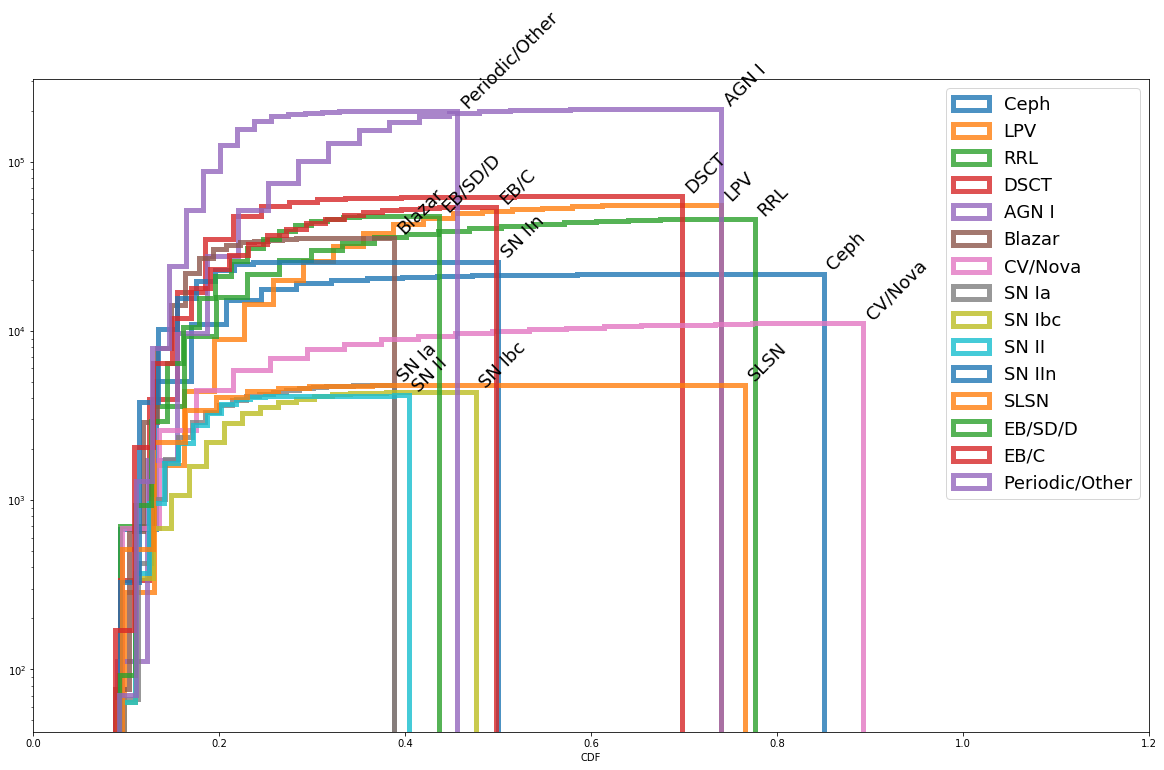

In [117]:
fig, ax = plt.subplots(figsize=(20, 12))
ncl = 0
df_cl = {}
for cl in classmapper.keys():
    if cl in ["Other", "EB", "SNe", "AGN", "SN", "Variable Star", "Asteroid", "Bogus"]:
        continue
    ncl += 1
    print(cl)
    prob_name = "%s_prob" % cl.replace(" ", "")
    if cl == "AGN I":
        prob_name = "AGN-I_prob"
    elif cl == "EB/SD/D":
        prob_name = "EBSD/D_prob"
    elif cl == "EB/C":
        prob_name = "EBC_prob"
    elif cl == "Periodic/Other":
        prob_name = "Periodic-Other_prob"
    query='''
    select late_probabilities_v2."%s"
    from late_probabilities_v2 

    inner join objects
    on late_probabilities_v2.oid=objects.oid

    where objects.classrf=%i
    
    ''' % (prob_name, classmapper[cl])
    # notar que "SNIa_prob" is written between parenthesis, since this is a programatically defined column in SQL

    df_cl[prob_name] = pd.read_sql_query(query, conn)
    ax.hist(df_cl[prob_name][prob_name], histtype='step', cumulative=True, bins=20, lw=5, label=cl, alpha=0.8)
    ax.text(df_cl[prob_name][prob_name].max(), df_cl[prob_name].shape[0], cl, fontsize=18, rotation=45, va='bottom', ha='left')
ax.legend(fontsize=18)
ax.set_xlim(0, 1.2)
ax.set_yscale('log')
ax.set_xlabel("Probability")
ax.set_xlabel("CDF")
plt.savefig("plots/cumulative.png")    

0 Ceph_prob 0.138
1 LPV_prob 0.178
2 RRL_prob 0.15
3 DSCT_prob 0.15199999999999997
4 AGN-I_prob 0.188
5 Blazar_prob 0.126
6 CV/Nova_prob 0.13
7 SNIa_prob 0.12
8 SNIbc_prob 0.12
9 SNII_prob 0.118
10 SNIIn_prob 0.124
11 SLSN_prob 0.118
12 EBSD/D_prob 0.14
13 EBC_prob 0.132
14 Periodic-Other_prob 0.15


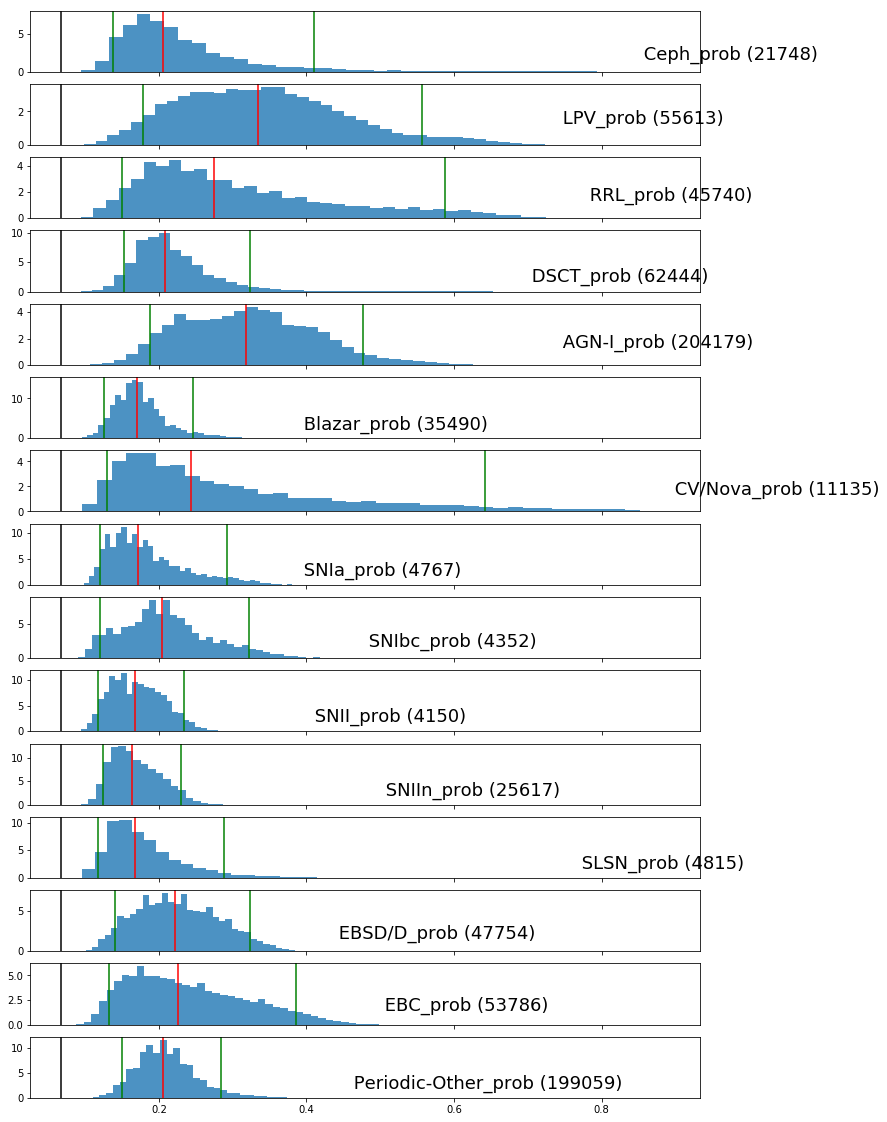

In [184]:
fig, ax = plt.subplots(nrows = len(df_cl.keys()), figsize=(12, 20), sharex=True)
for idx, cl in enumerate(df_cl.keys()):
    print(idx, cl, np.percentile(df_cl[cl][cl], 5.))
    ax[idx].axvline(np.percentile(df_cl[cl][cl], 5.), c='g')
    ax[idx].axvline(np.percentile(df_cl[cl][cl], 50.), c='r')
    ax[idx].axvline(np.percentile(df_cl[cl][cl], 95.), c='g')

    ax[idx].axvline(1/len(df_cl.keys()), c = 'k')
    ax[idx].hist(df_cl[cl][cl], density=True, bins=40, lw=5, label=cl, alpha=0.8)
    ax[idx].text(df_cl[cl][cl].max(), 1., " %s (%i)" % (cl, df_cl[cl].shape[0]), fontsize=18, va='bottom', ha='left')

#ax[-1].set_xlabel("probability")    

# Build histogram given probability cut

In [187]:
class_order = ['AGN-I', 'Blazar', 'CV/Nova', 'LPV', 'SNIa', 'SNIbc', 'SNII', 'SNIIn',
               'SLSN', 'EBSD/D', 'EBC', 'DSCT', 'RRL', 'Ceph', 'Periodic-Other']

/home/fforster/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


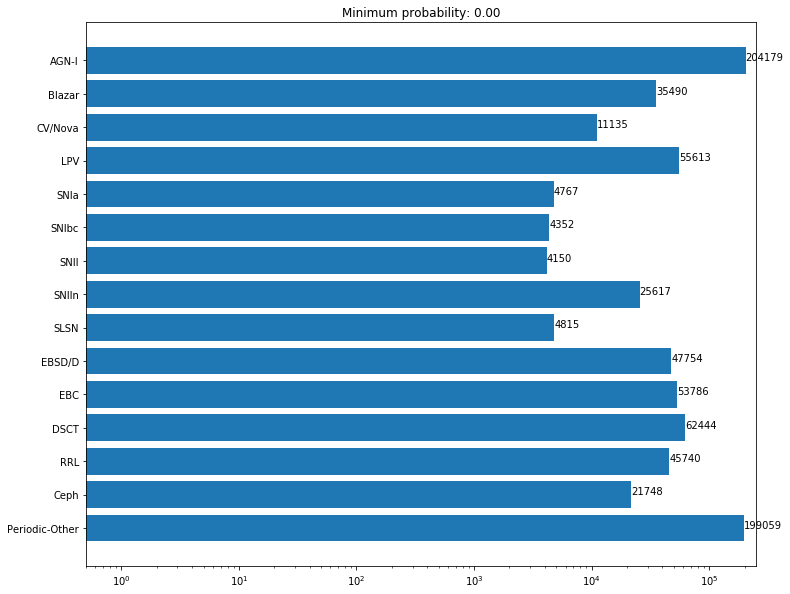

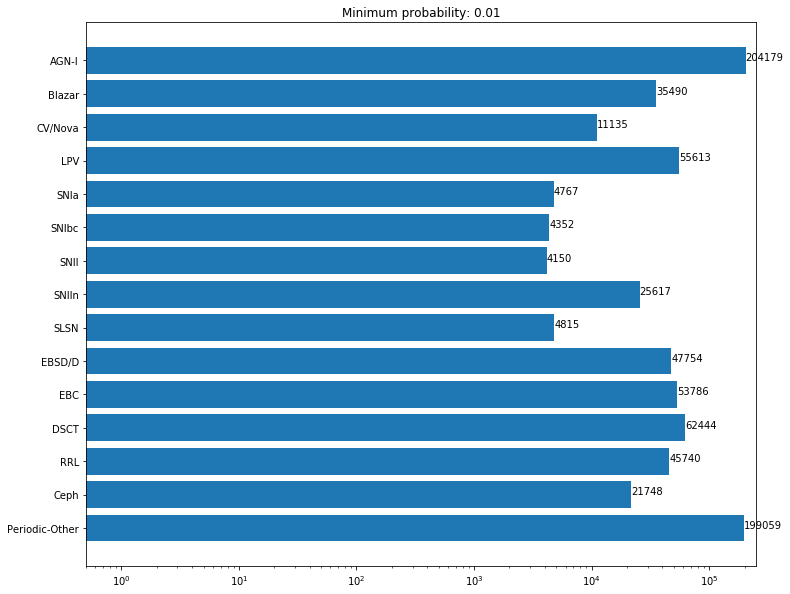

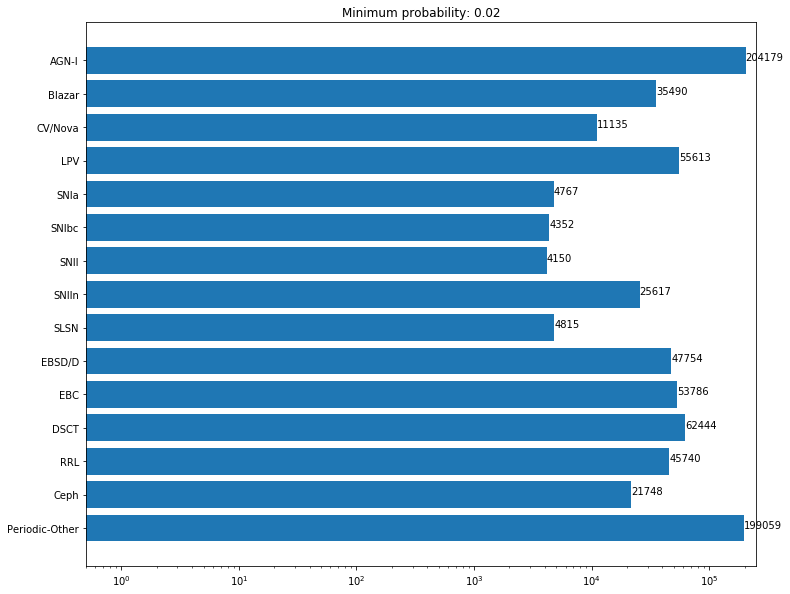

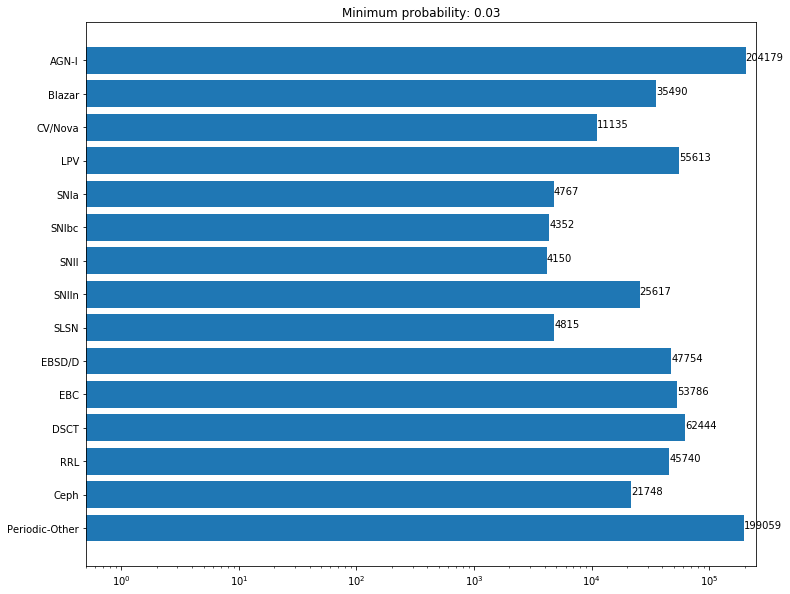

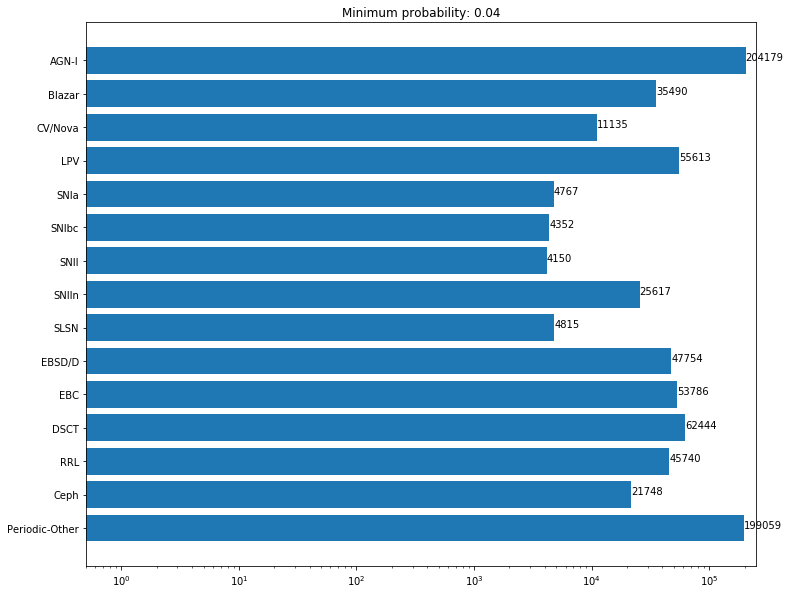

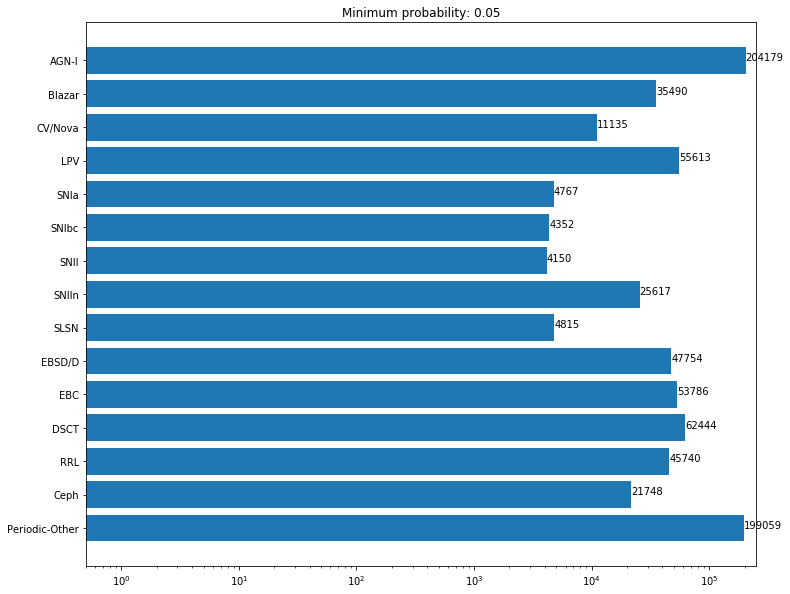

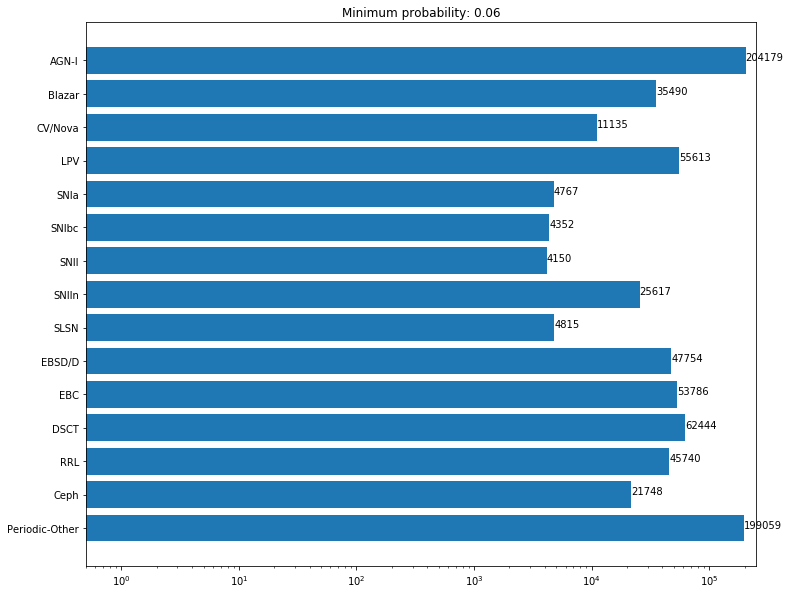

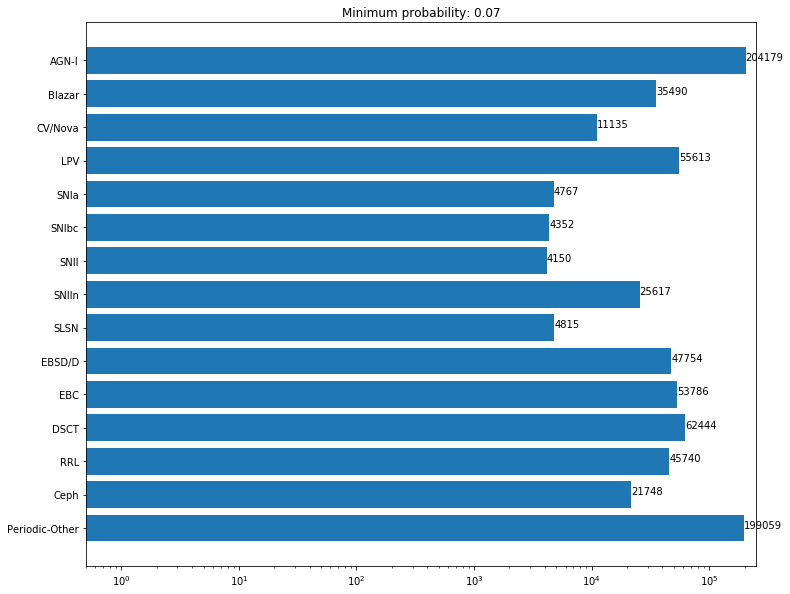

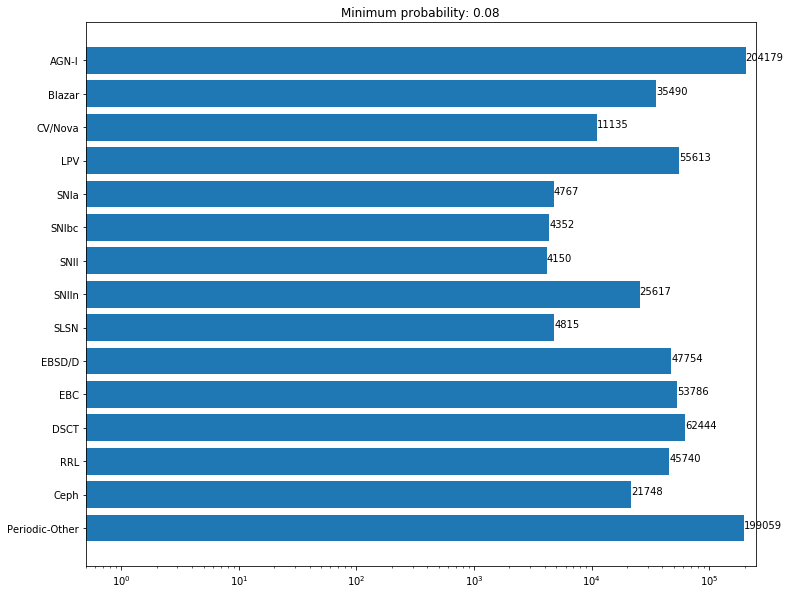

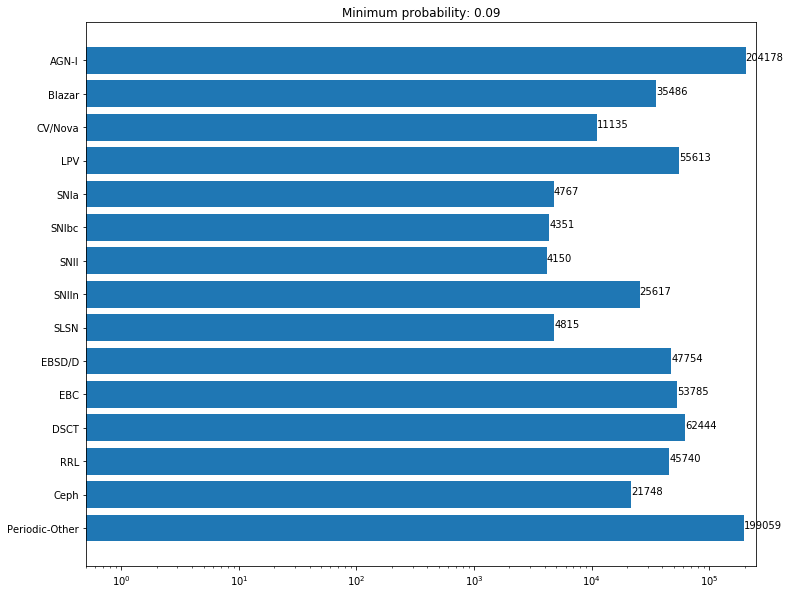

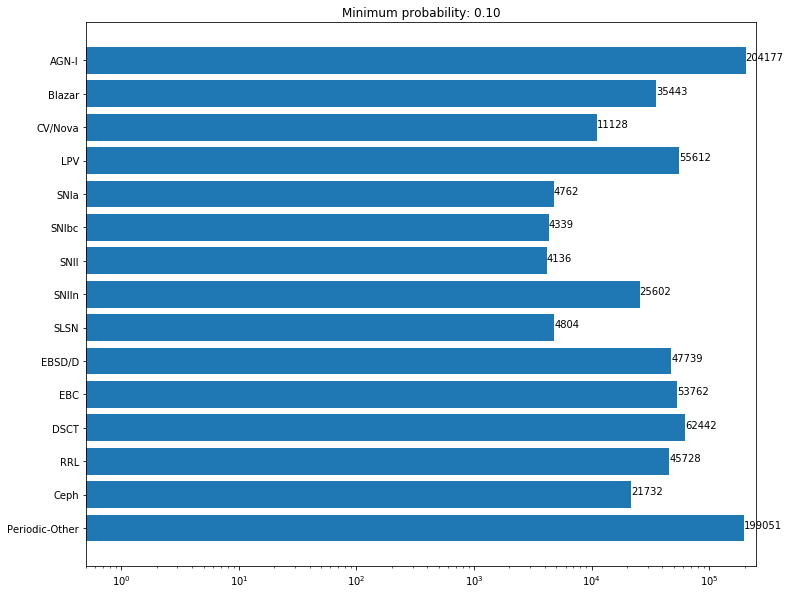

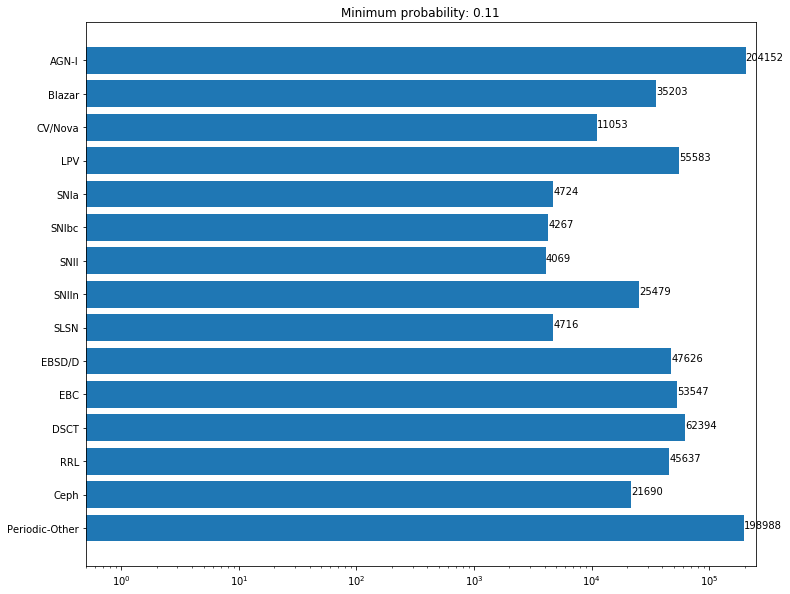

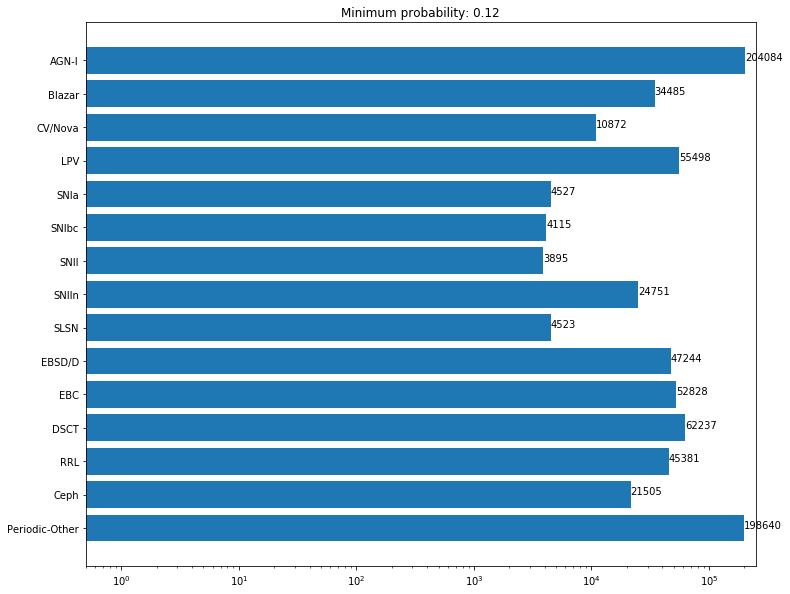

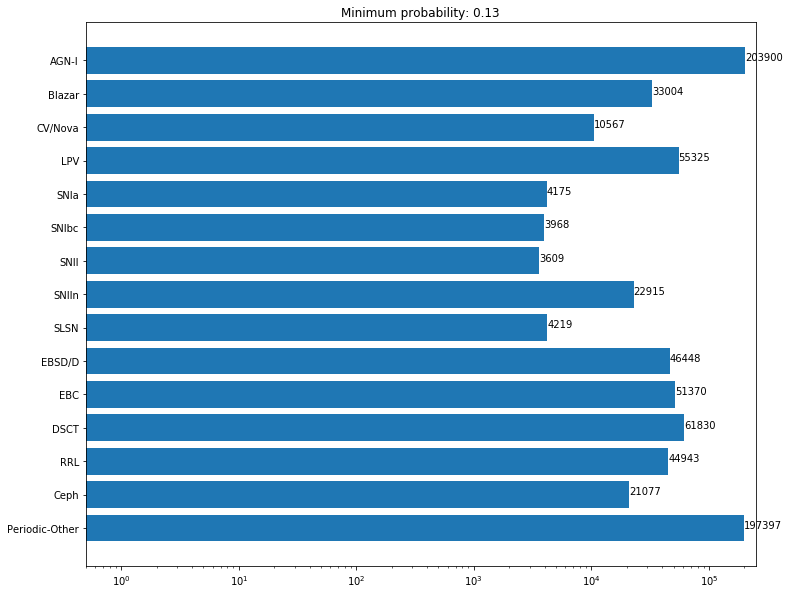

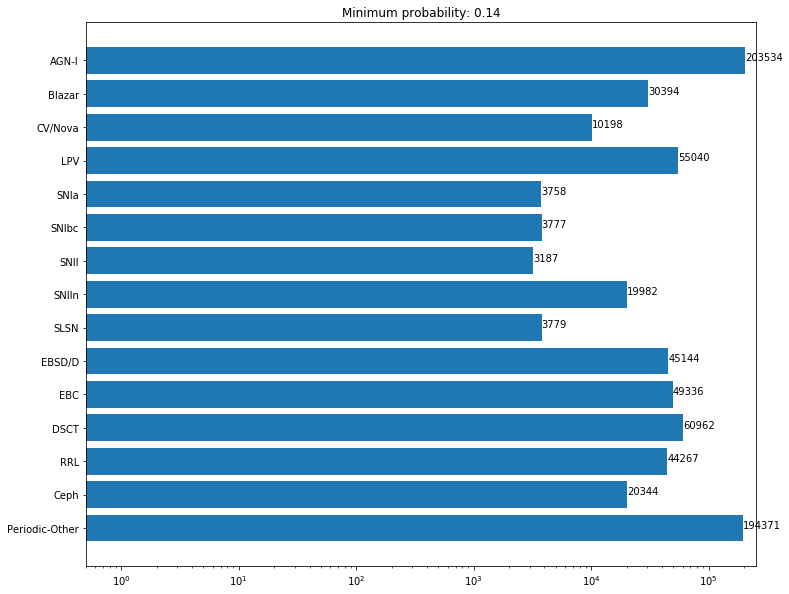

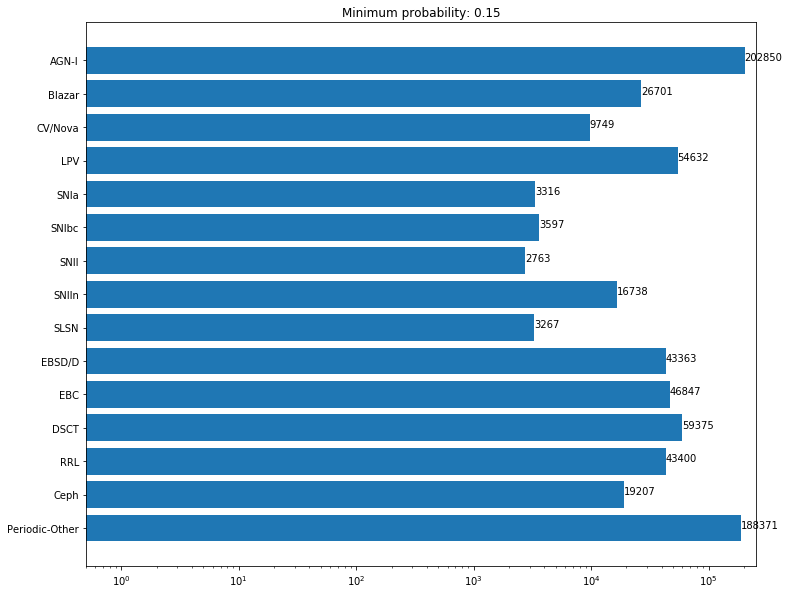

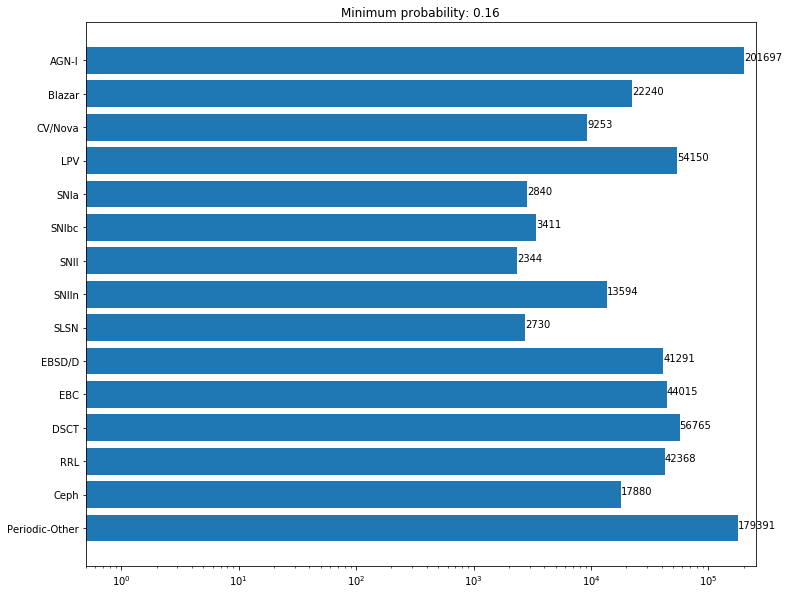

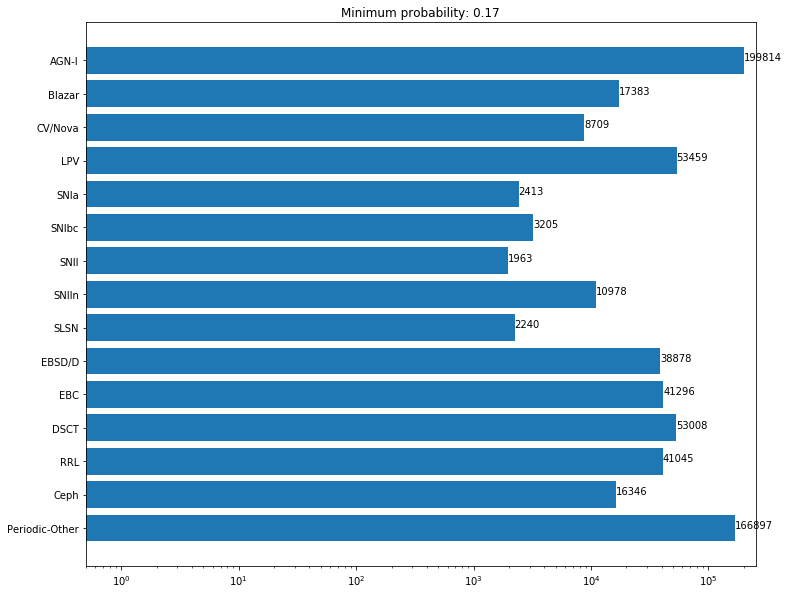

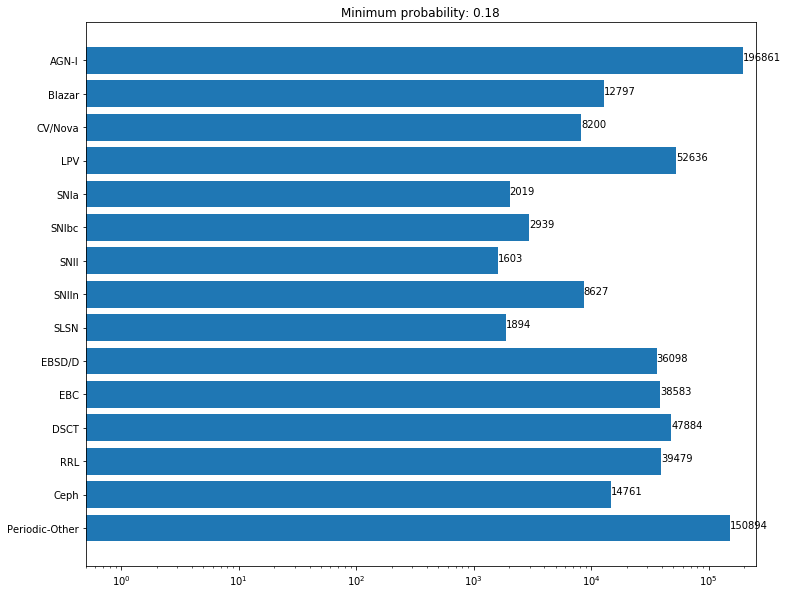

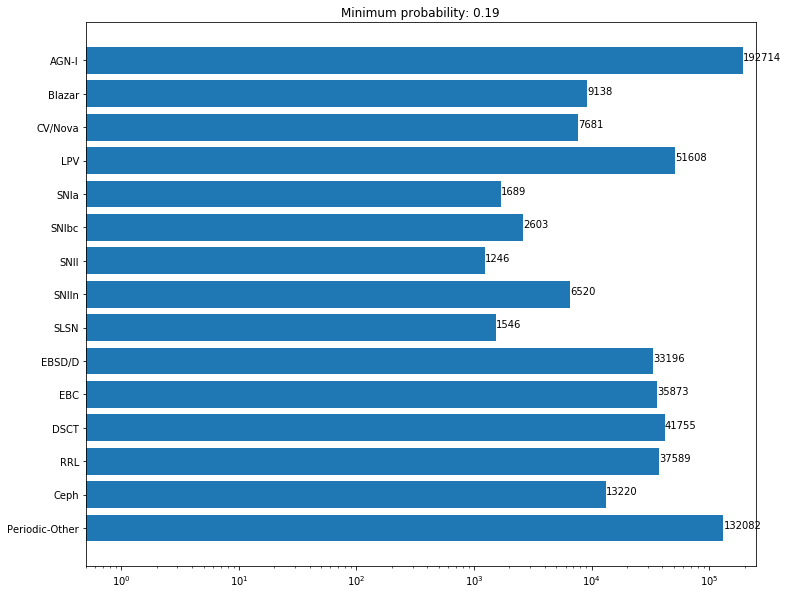

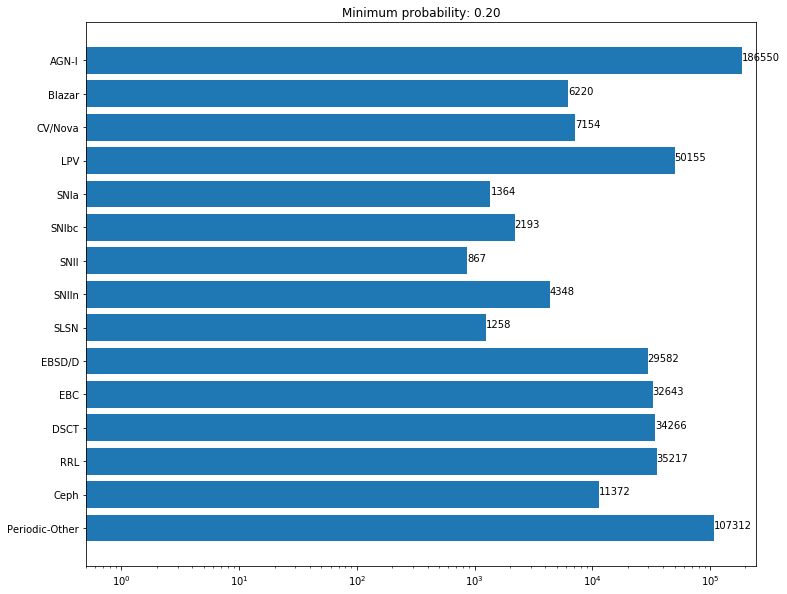

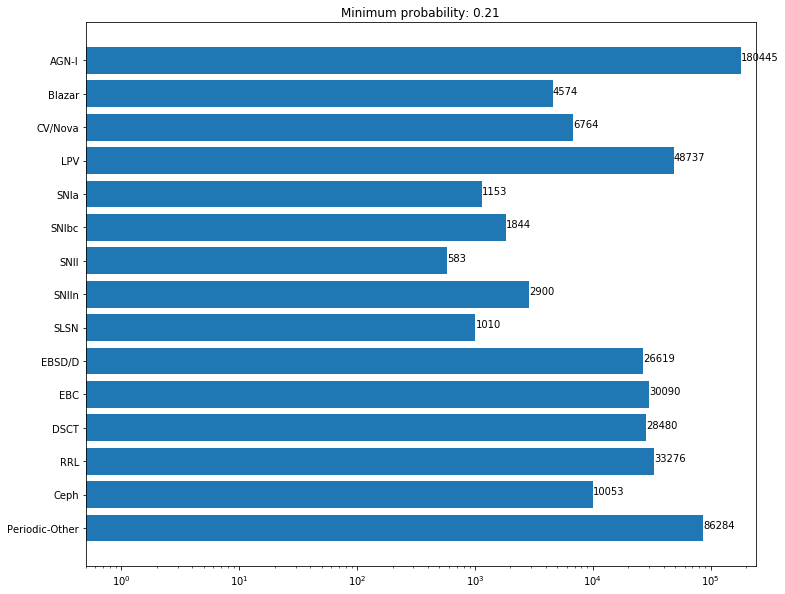

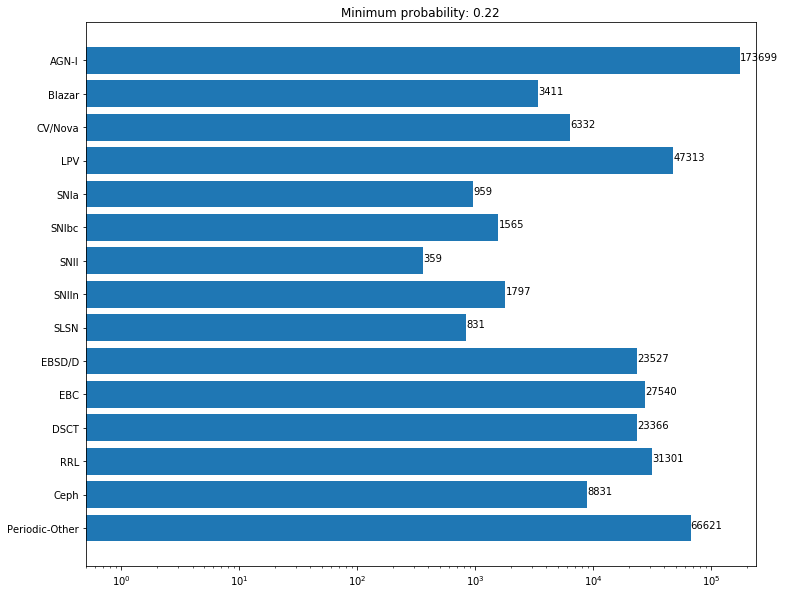

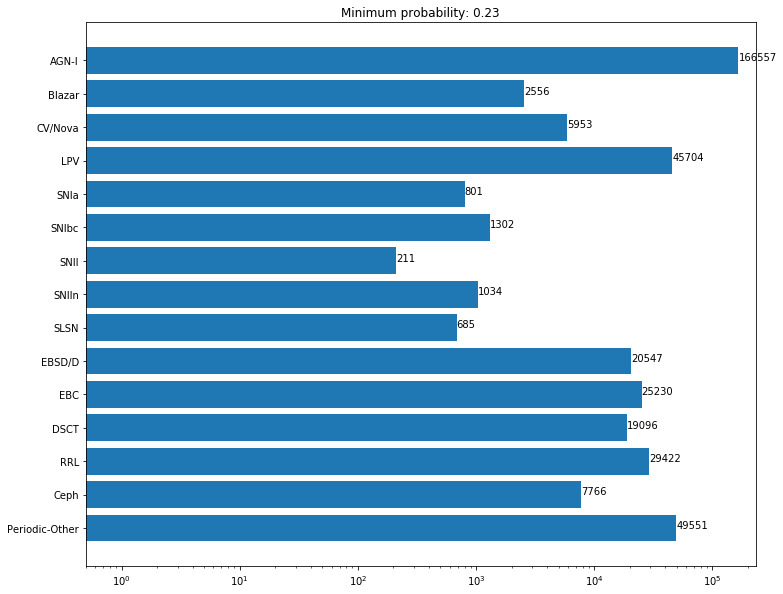

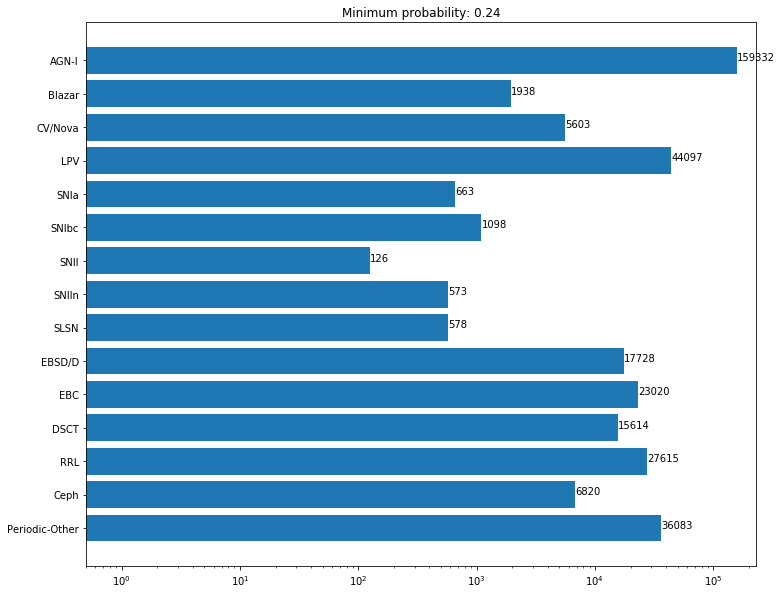

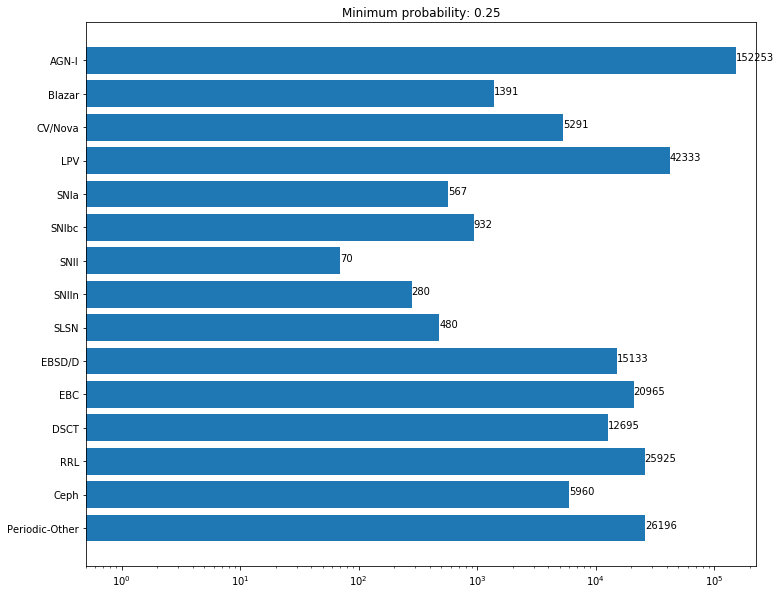

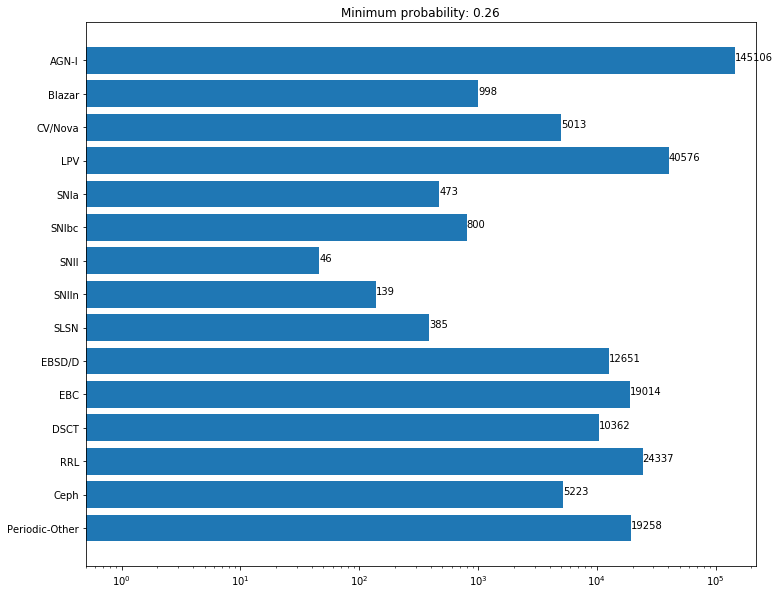

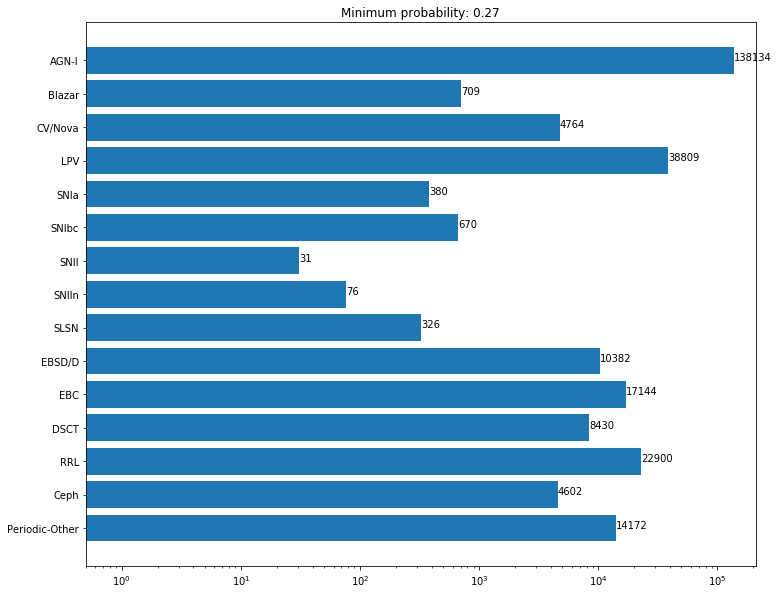

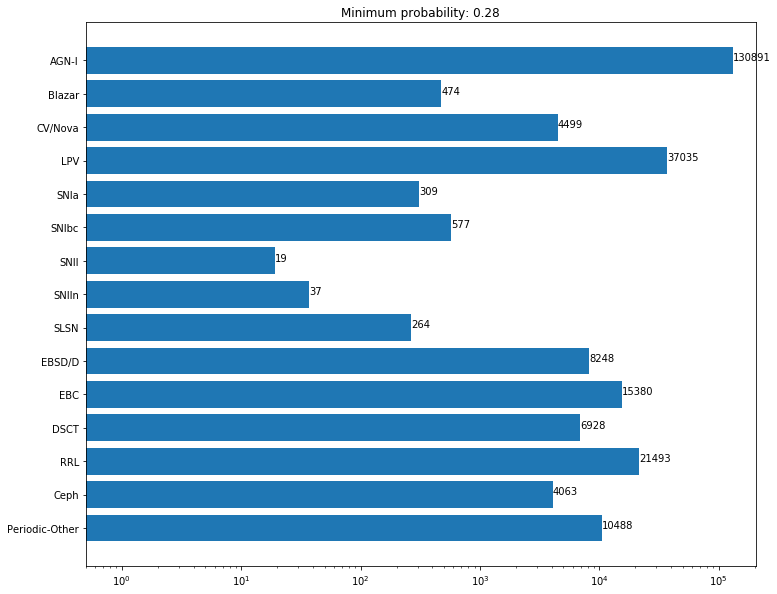

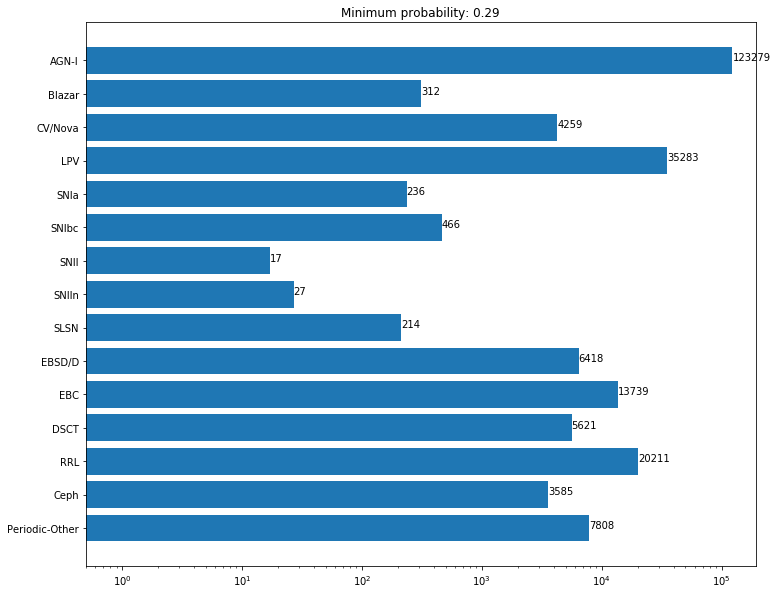

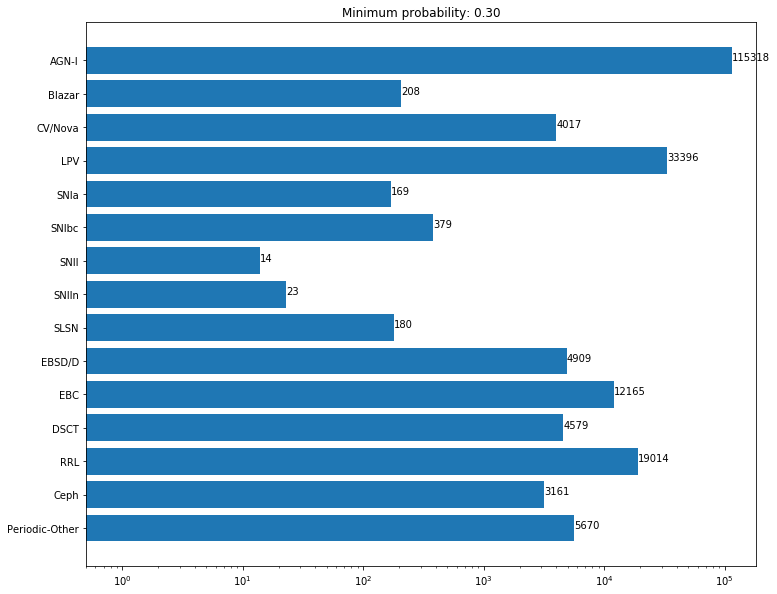

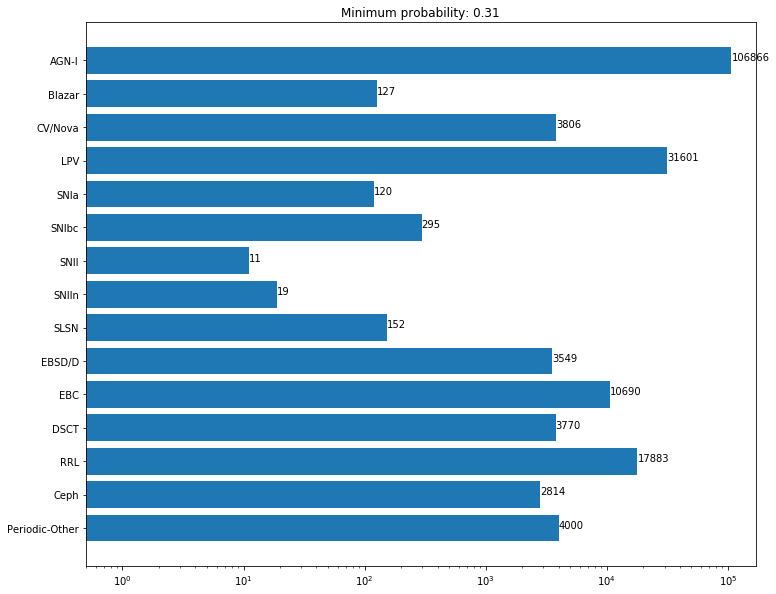

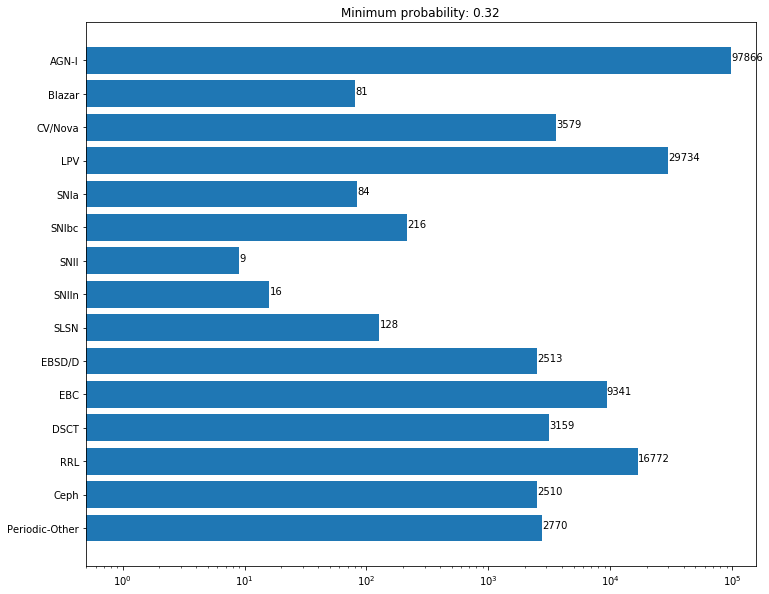

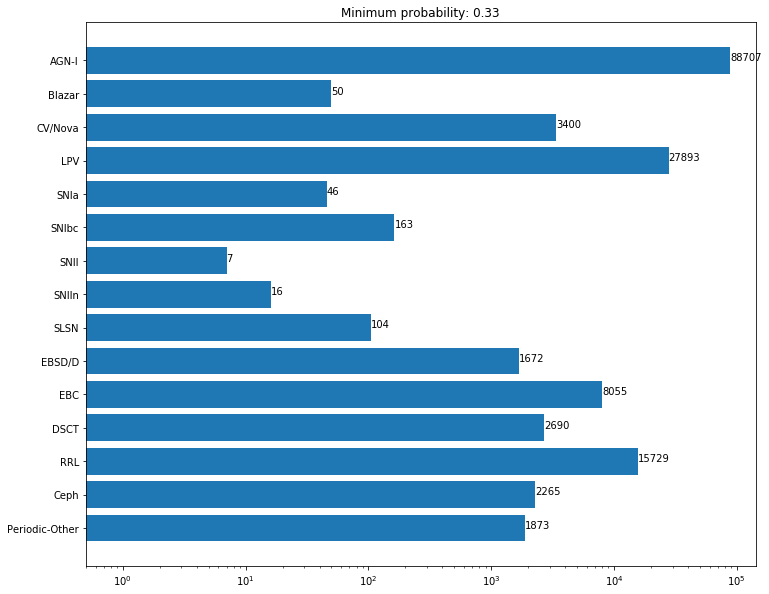

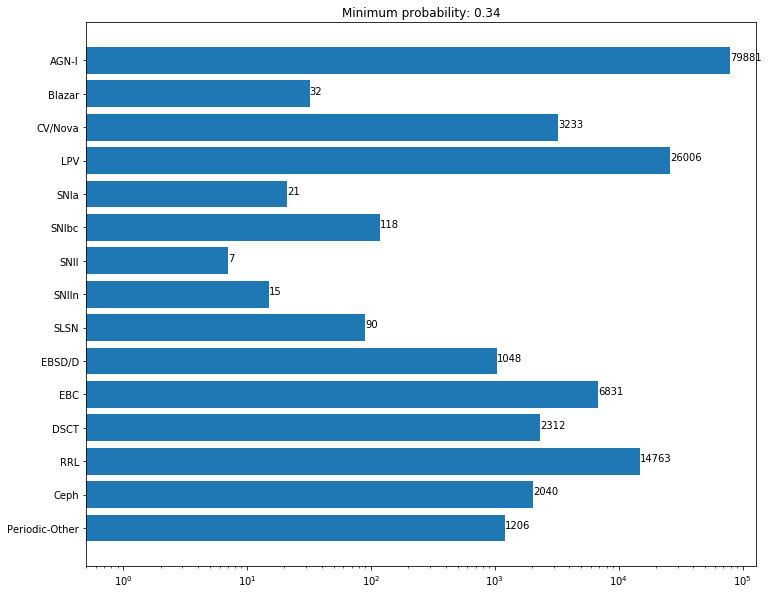

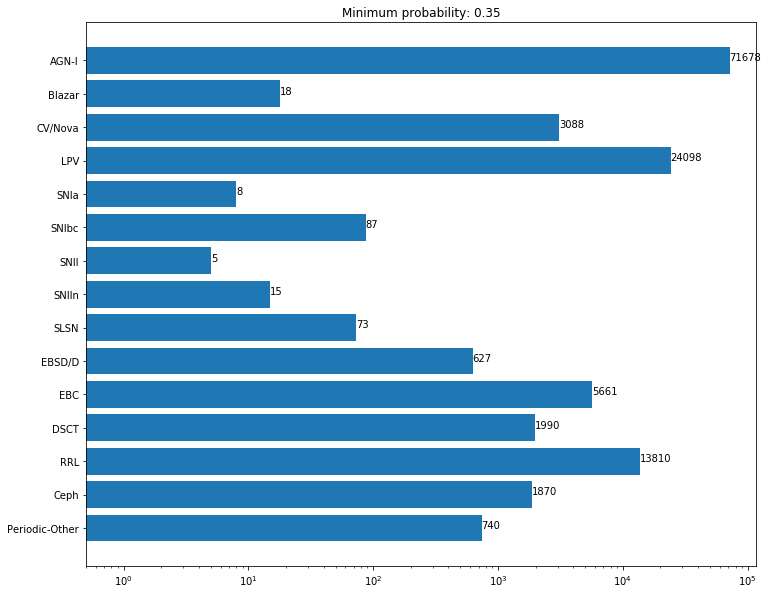

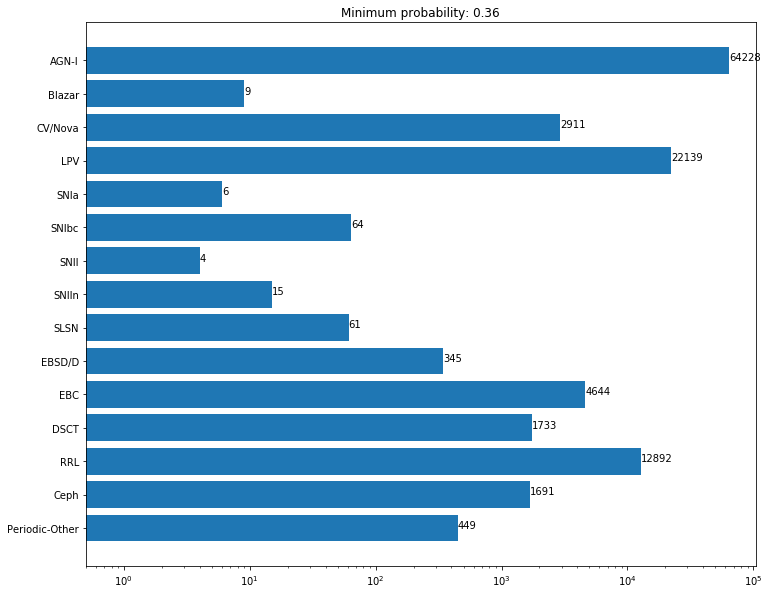

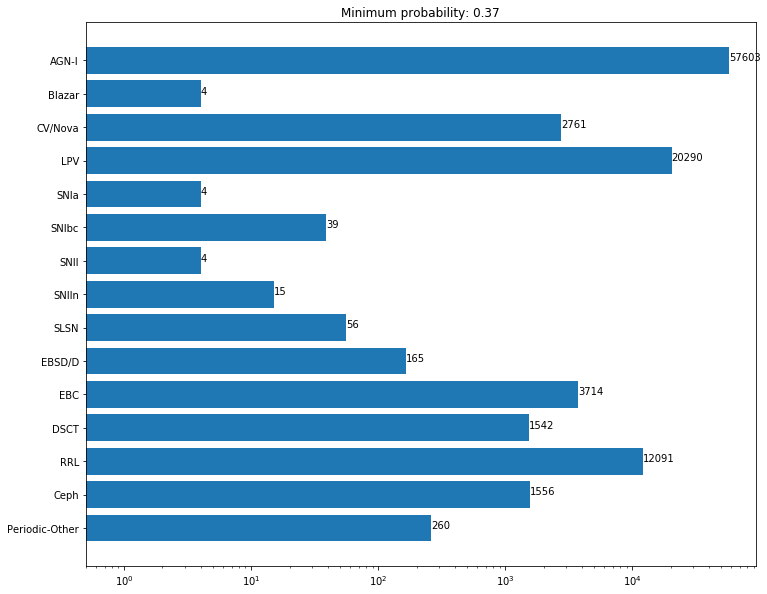

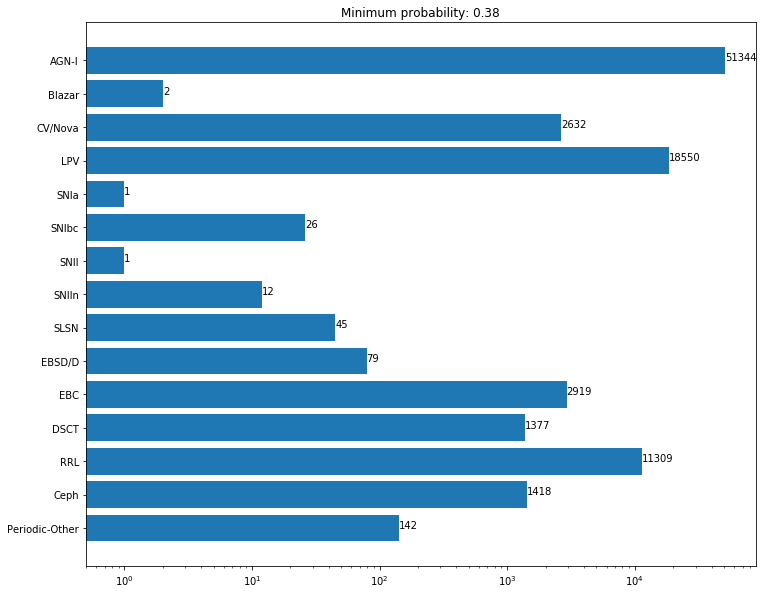

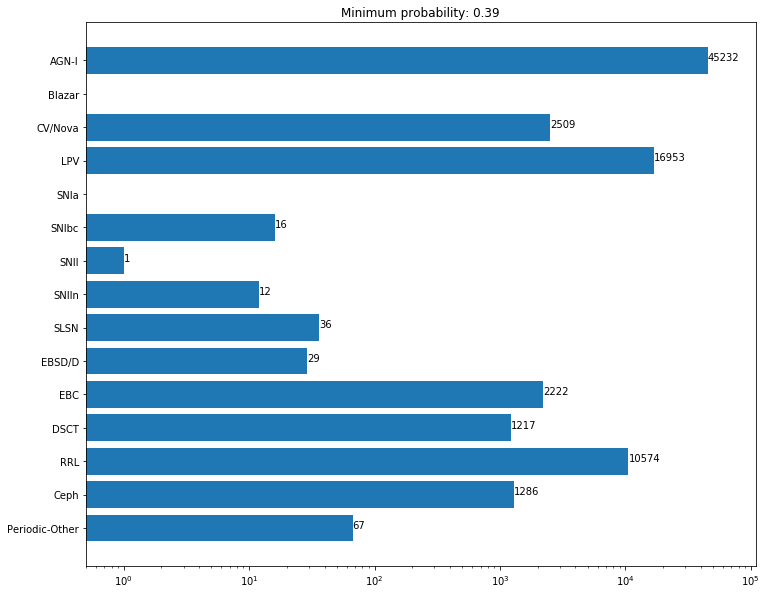

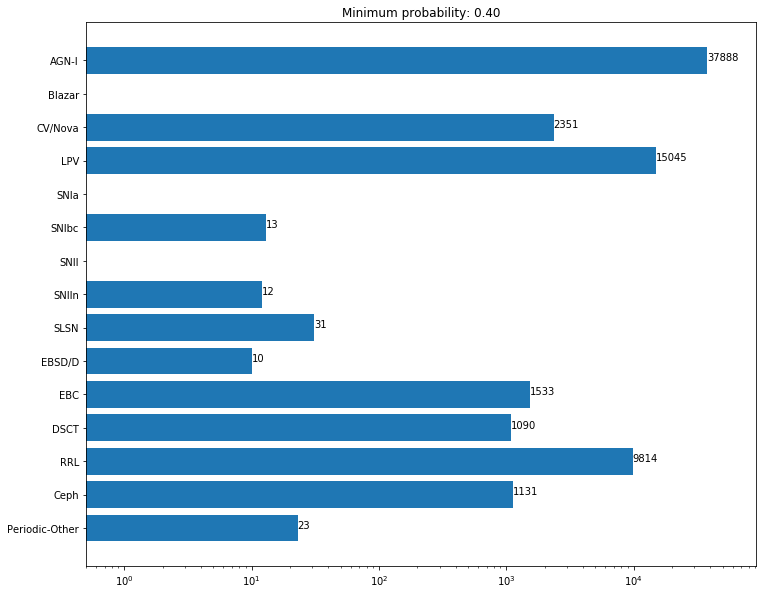

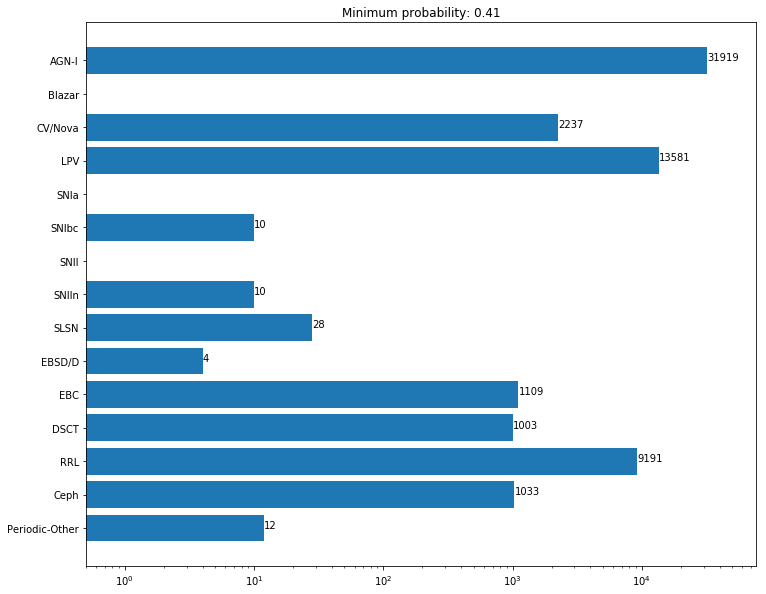

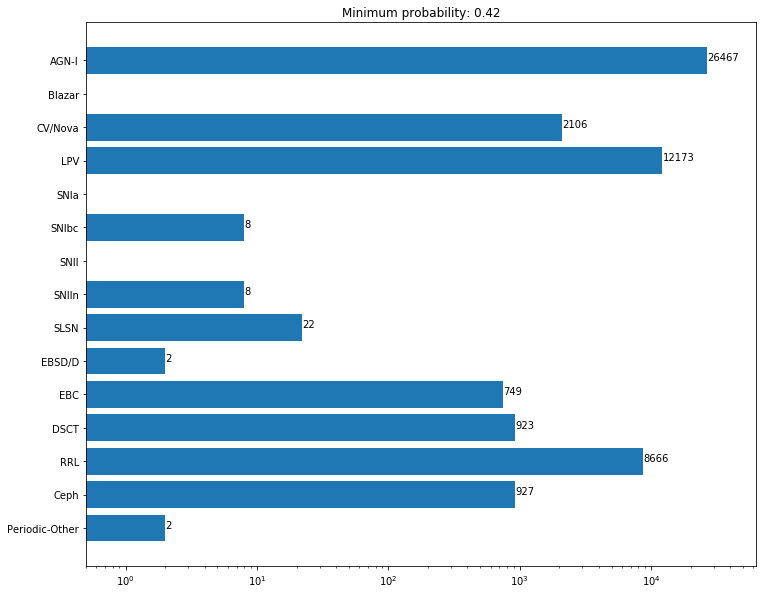

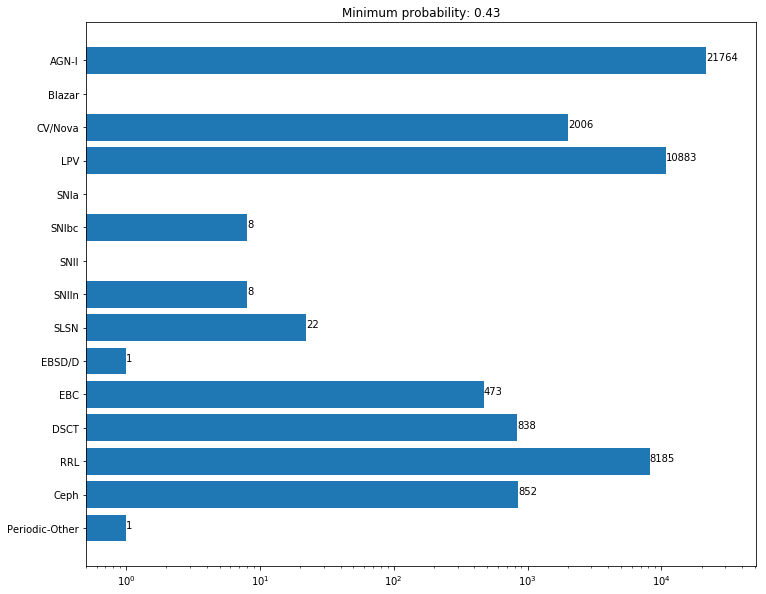

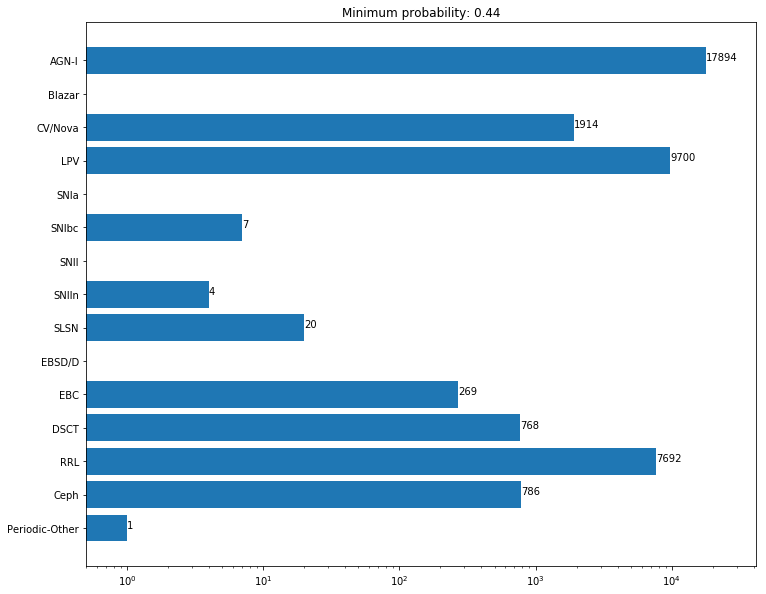

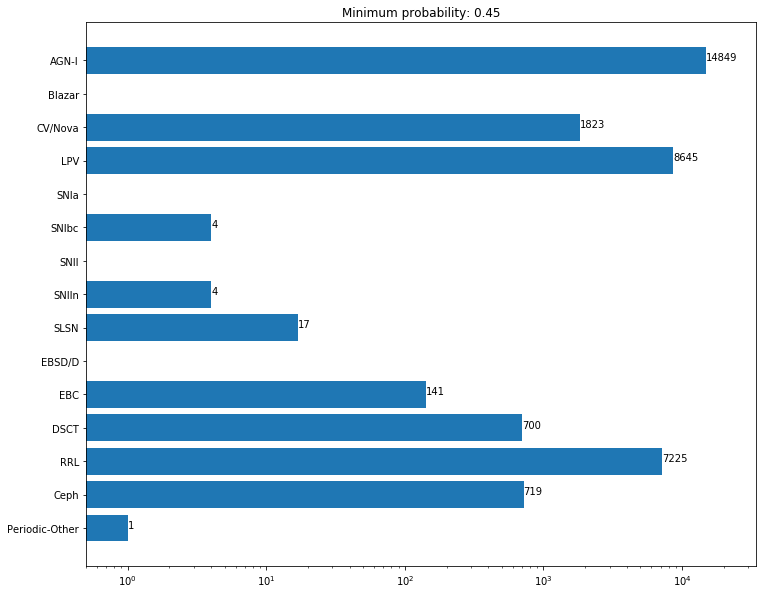

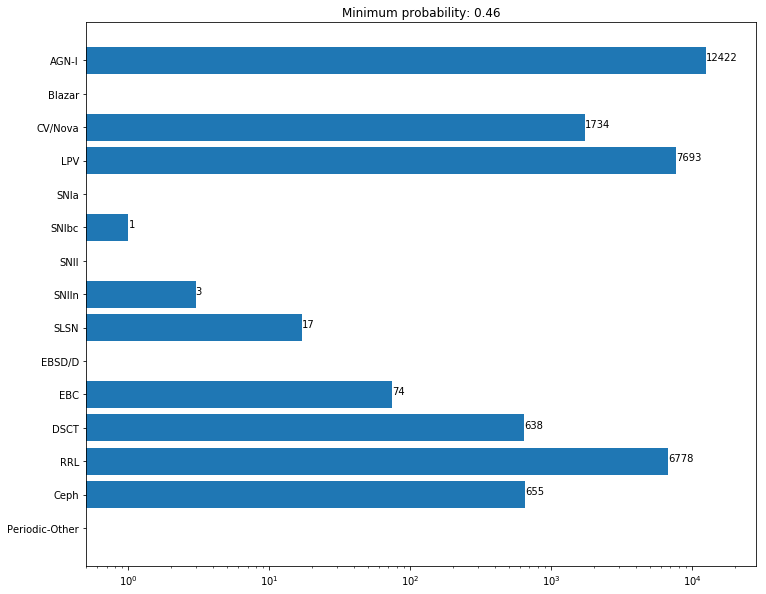

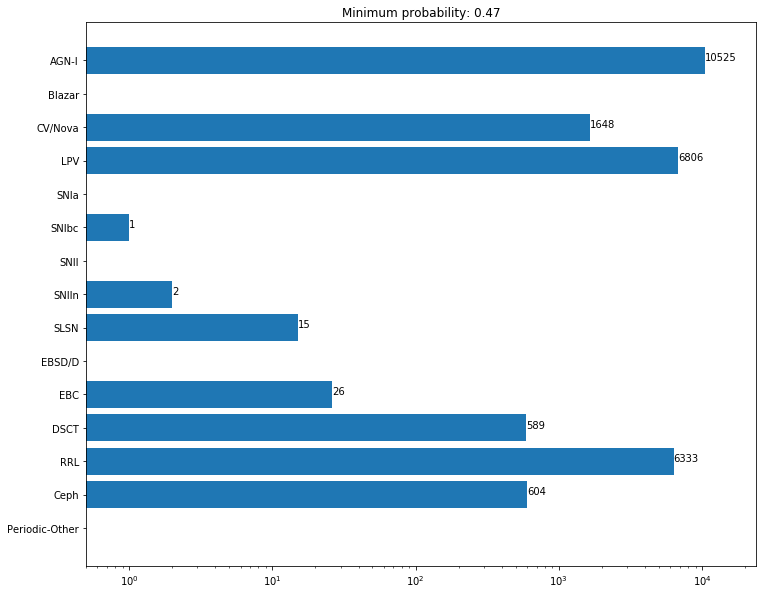

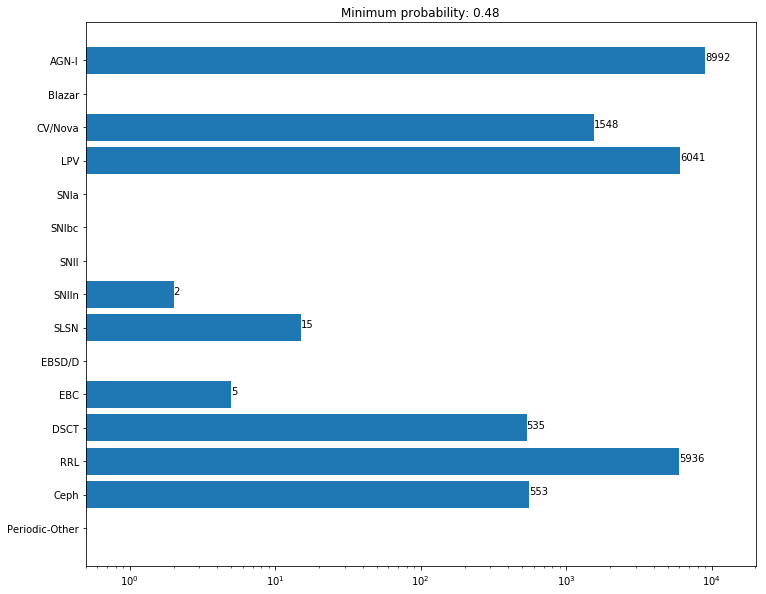

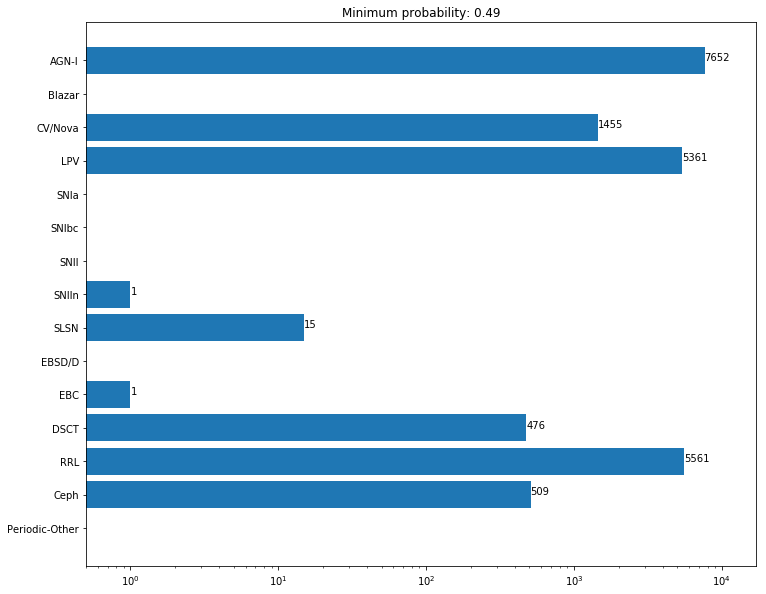

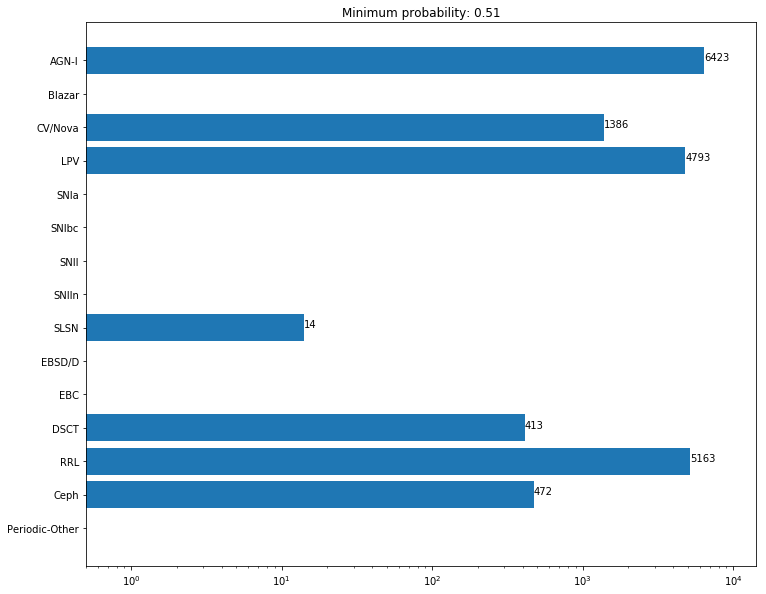

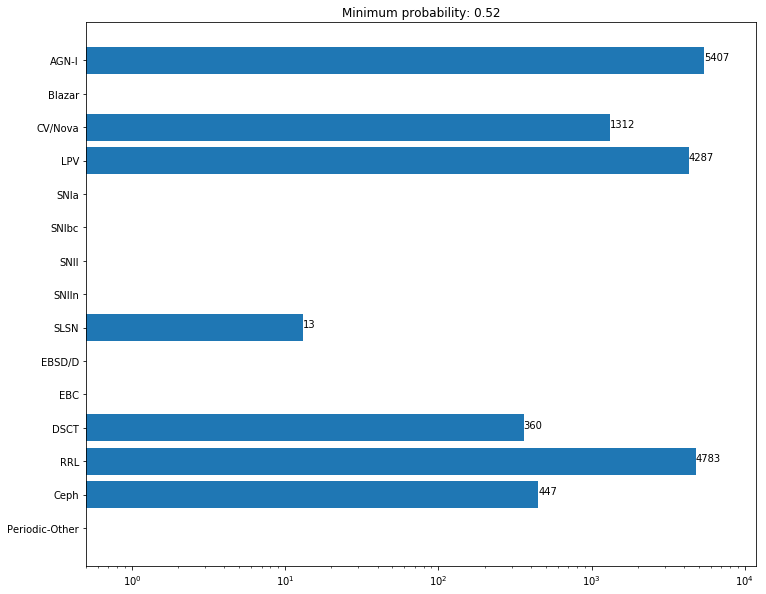

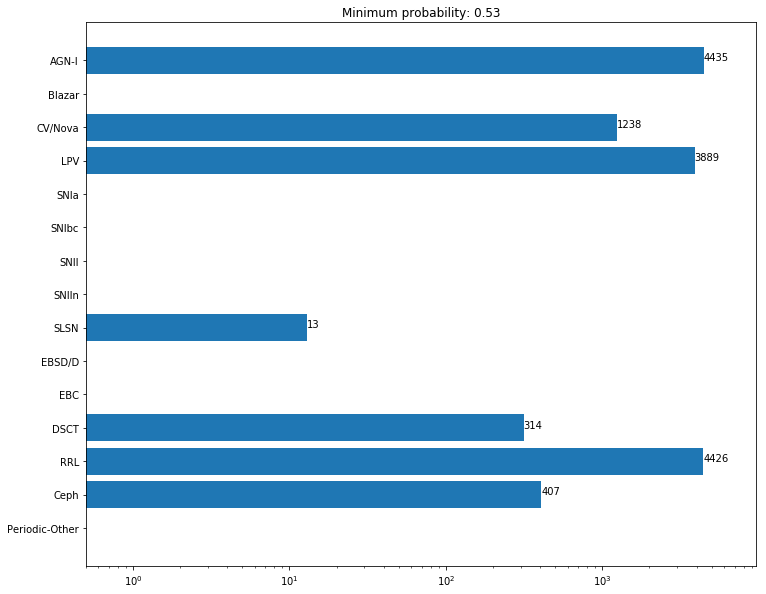

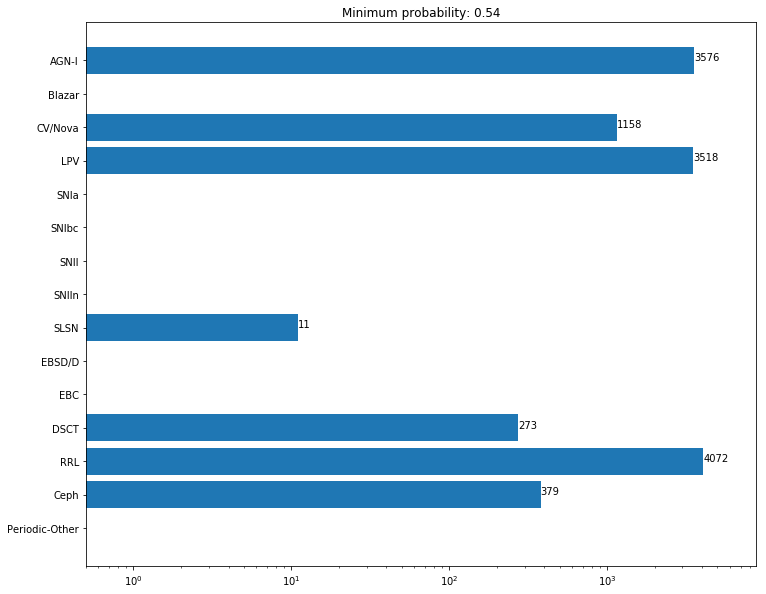

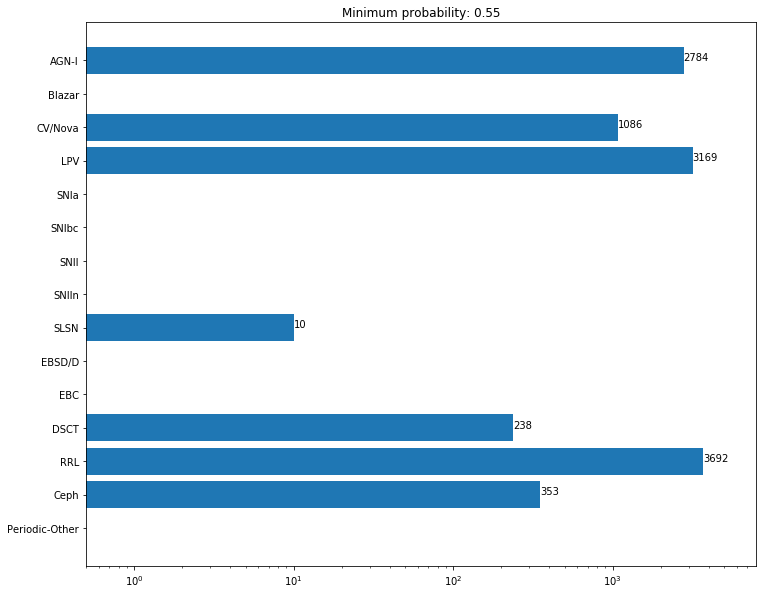

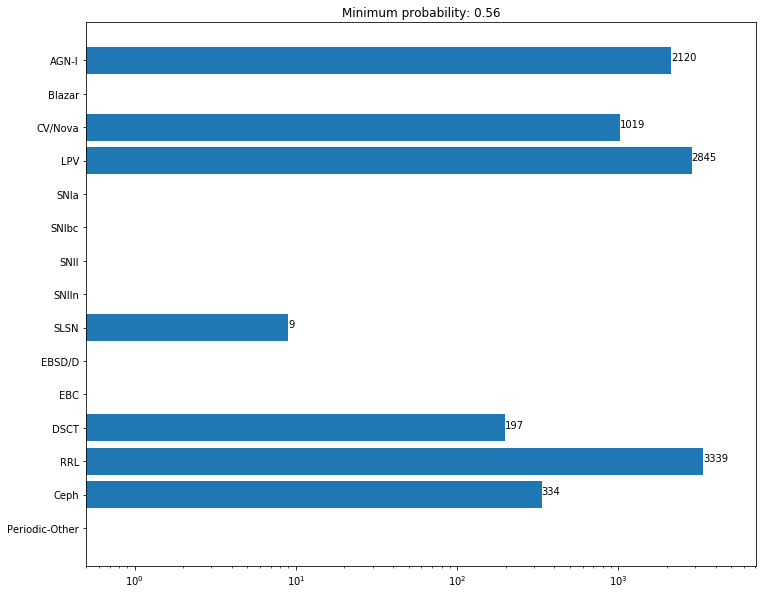

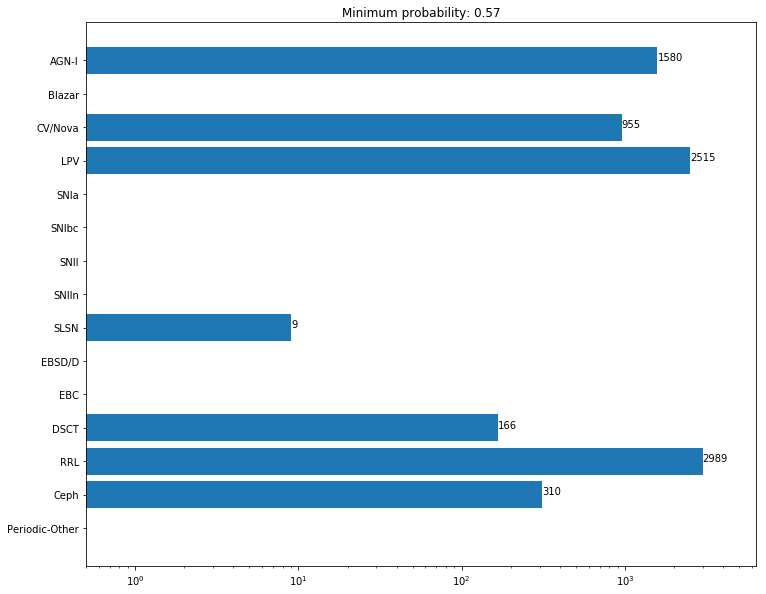

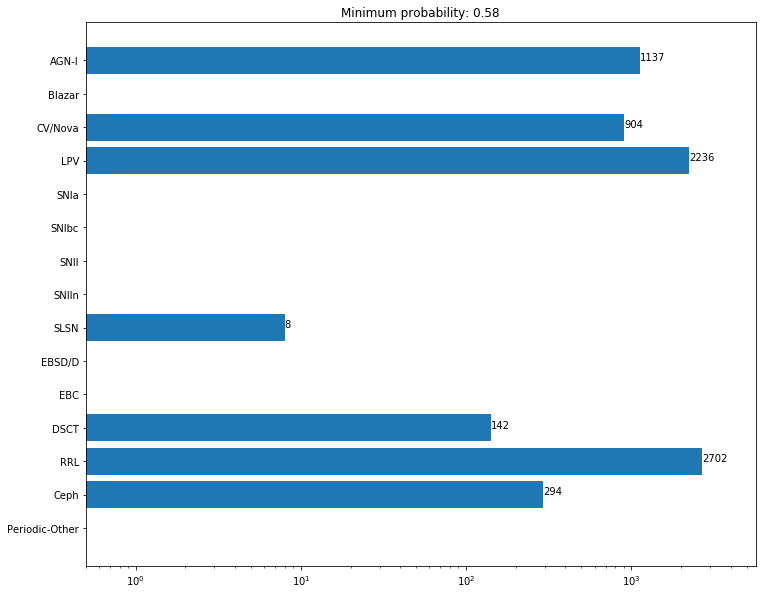

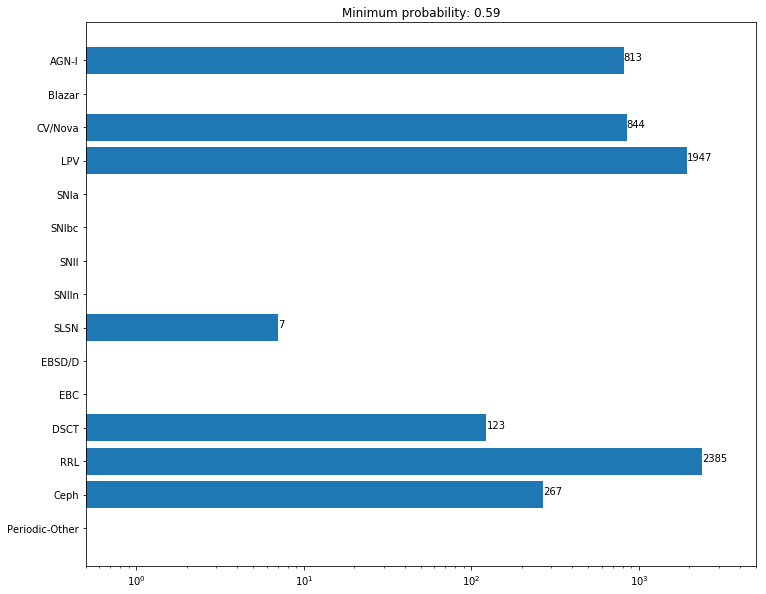

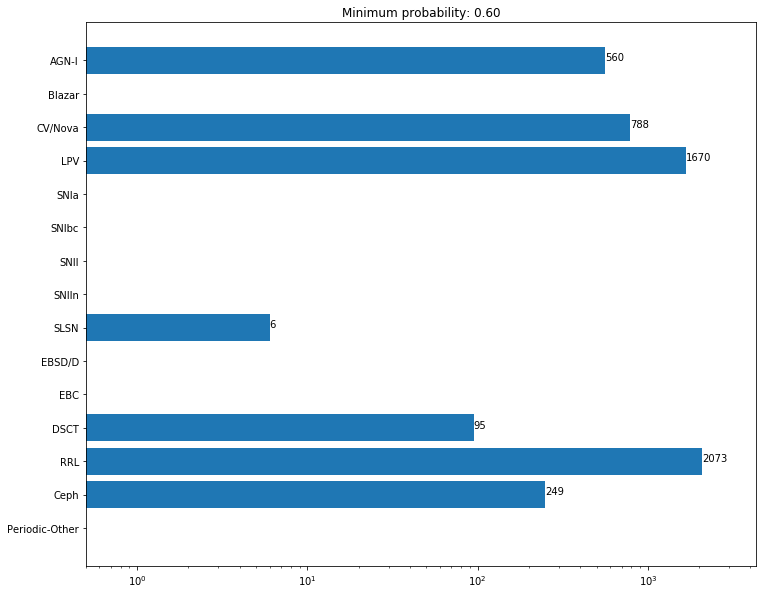

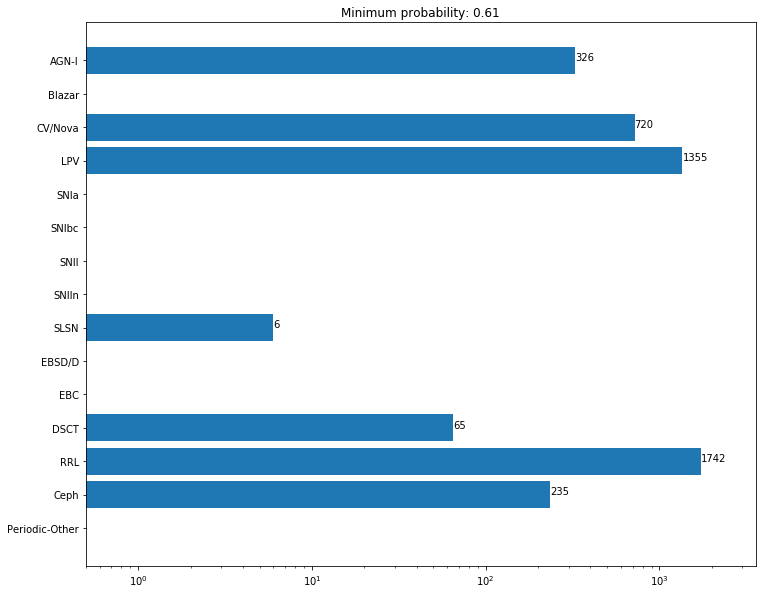

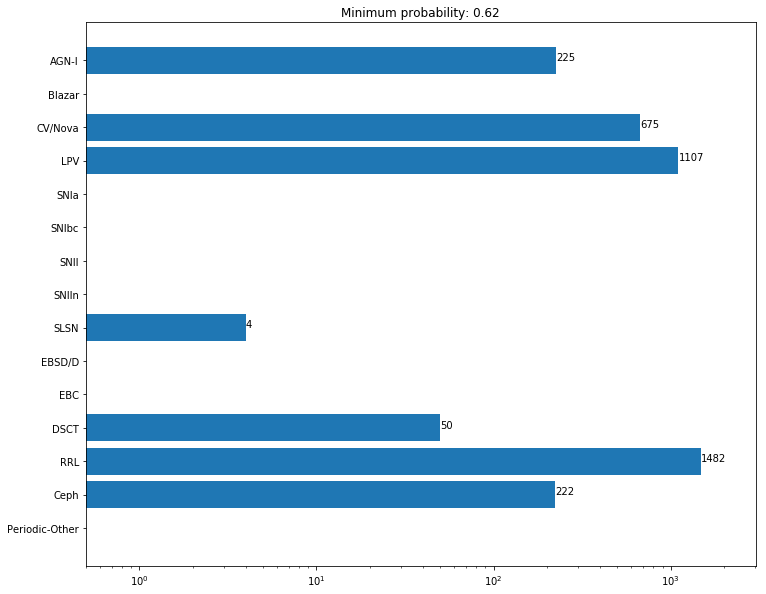

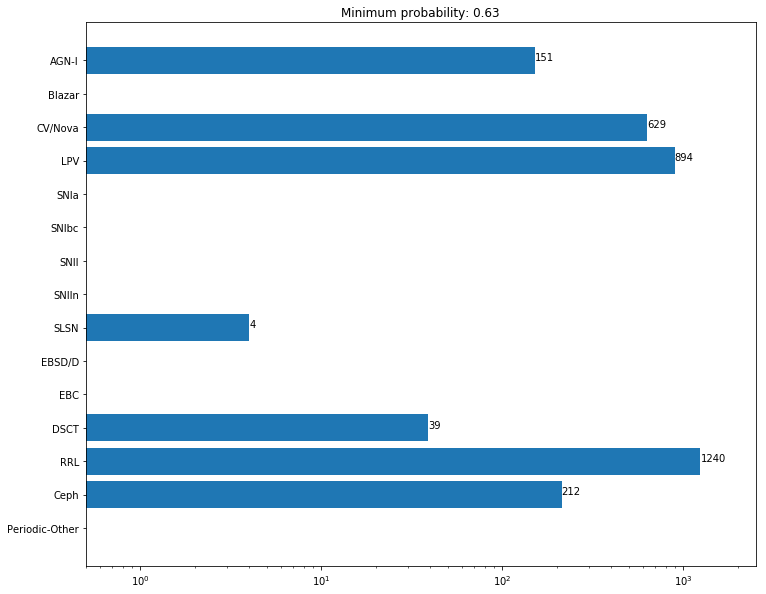

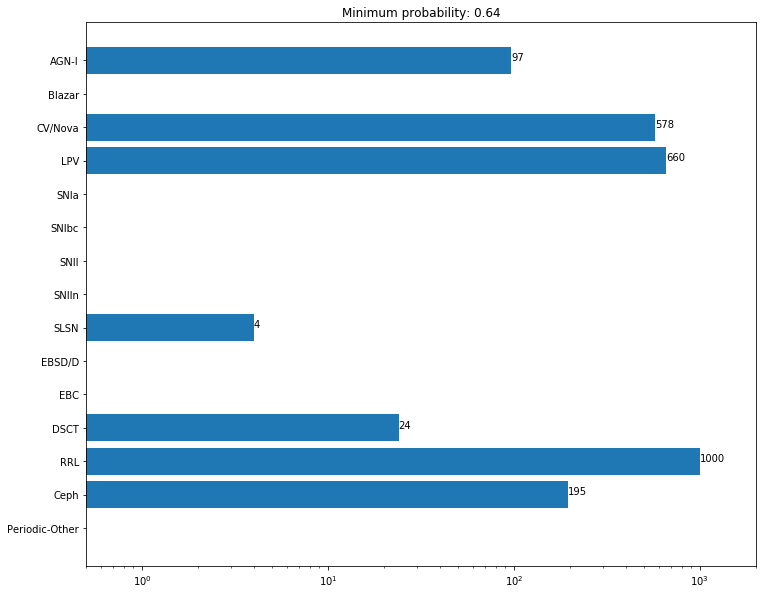

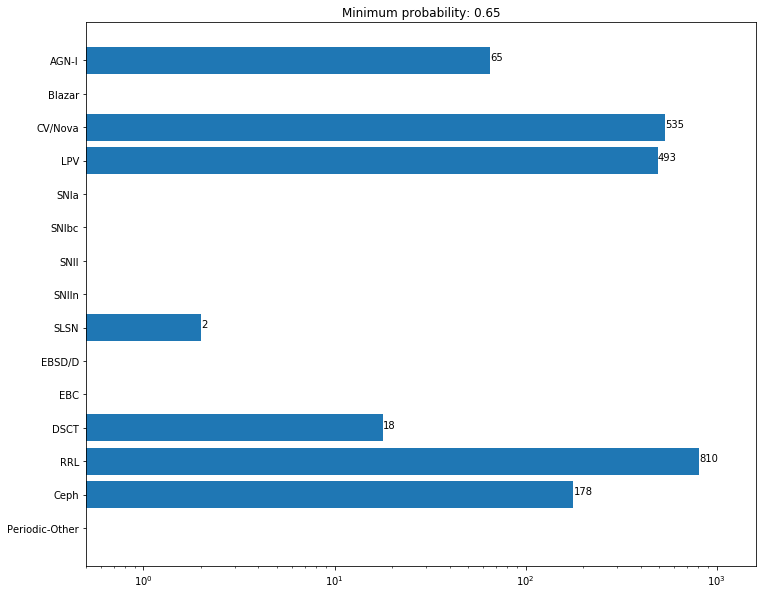

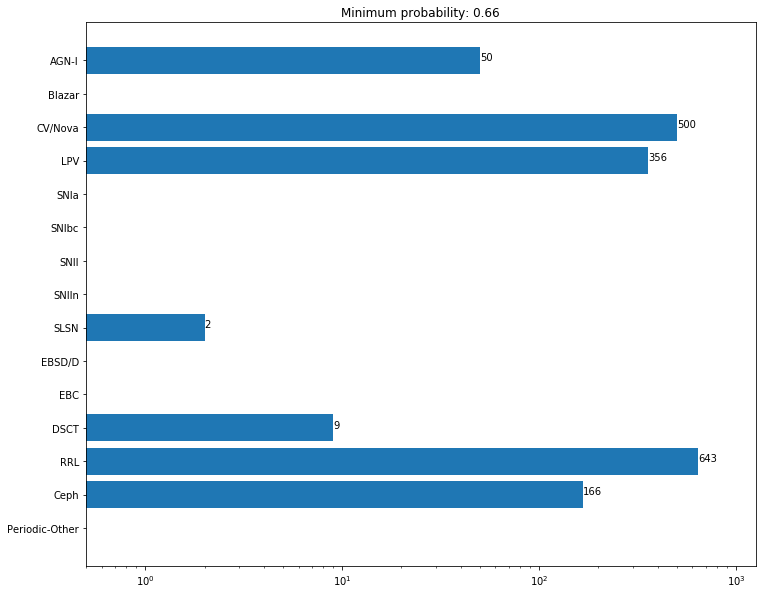

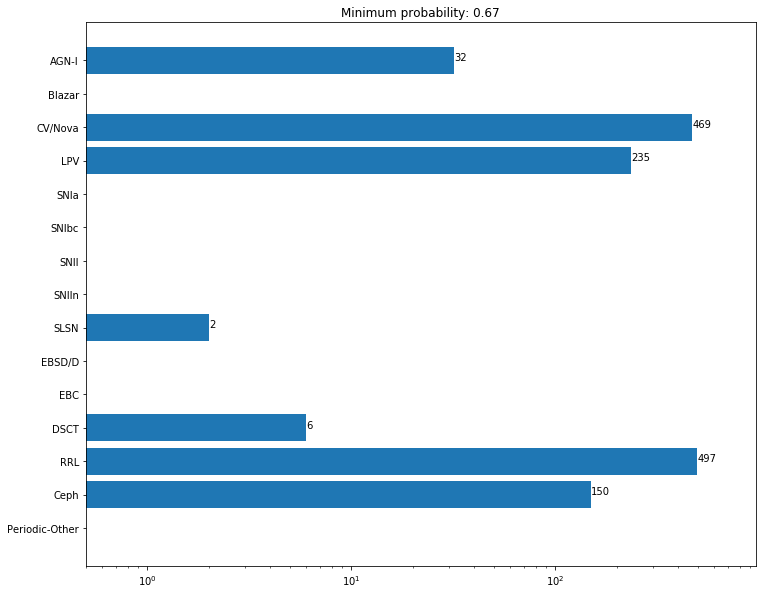

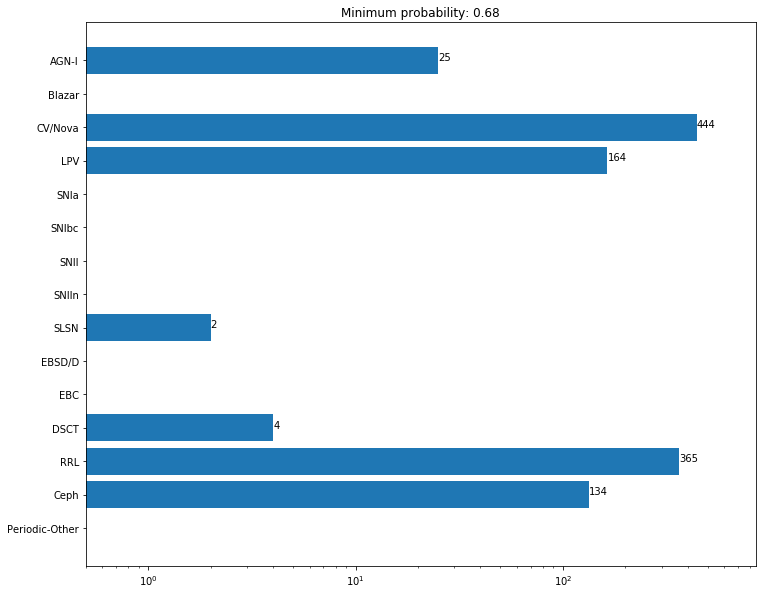

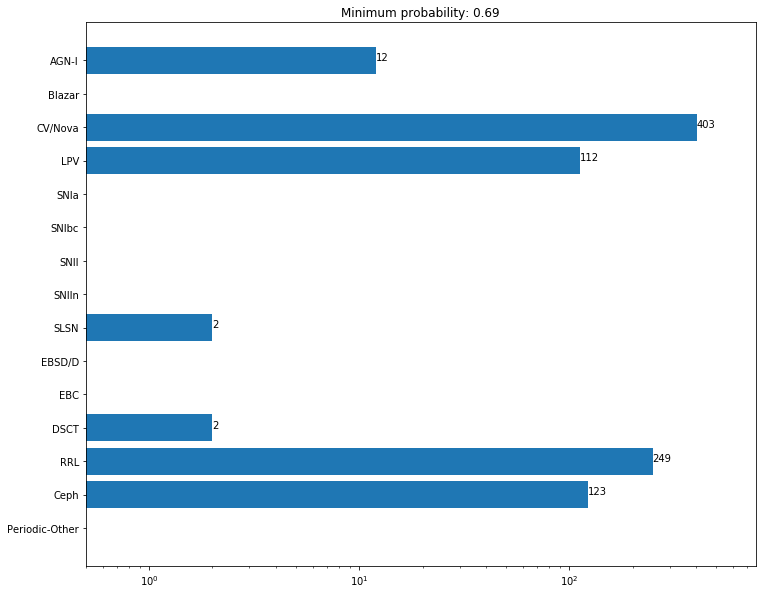

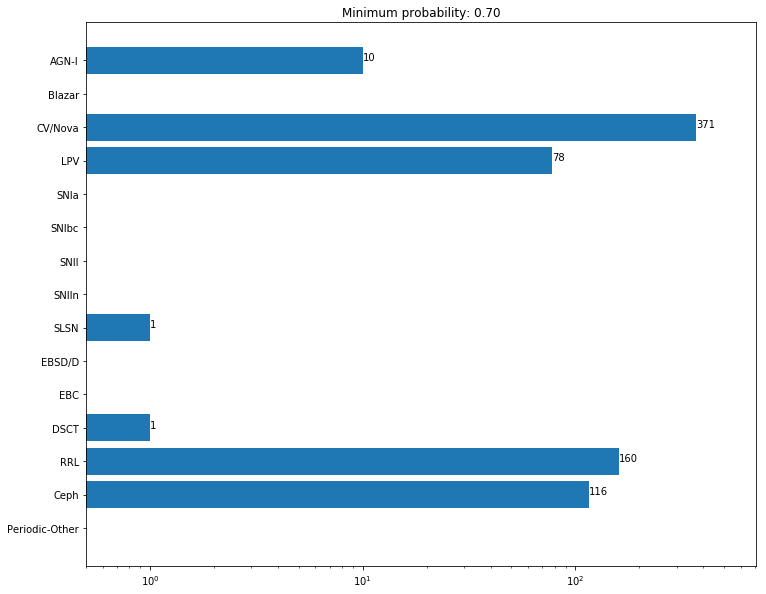

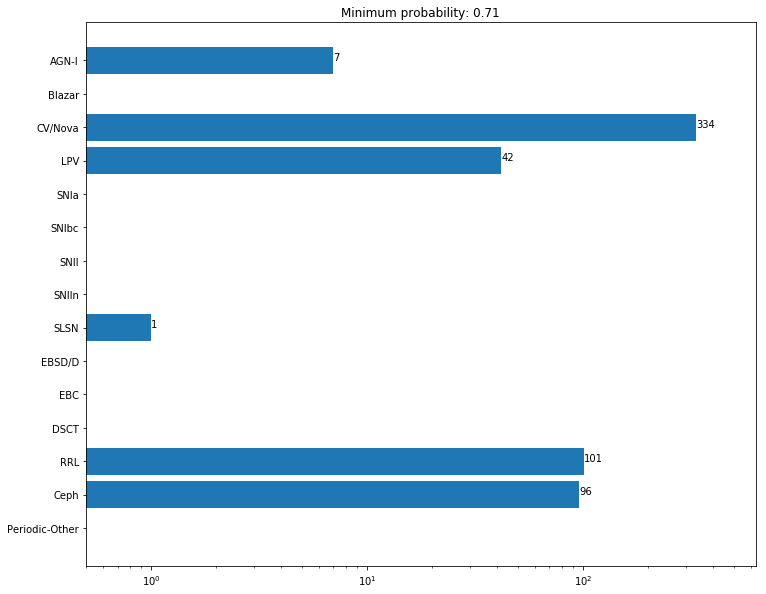

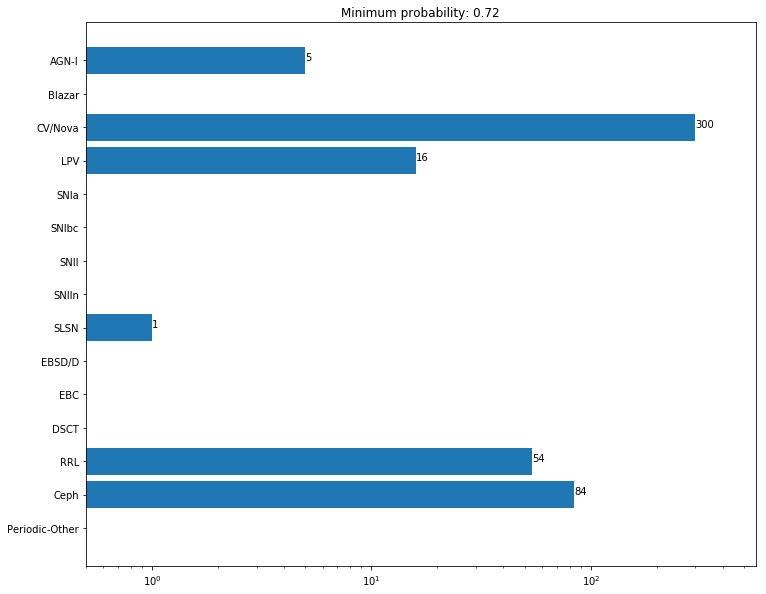

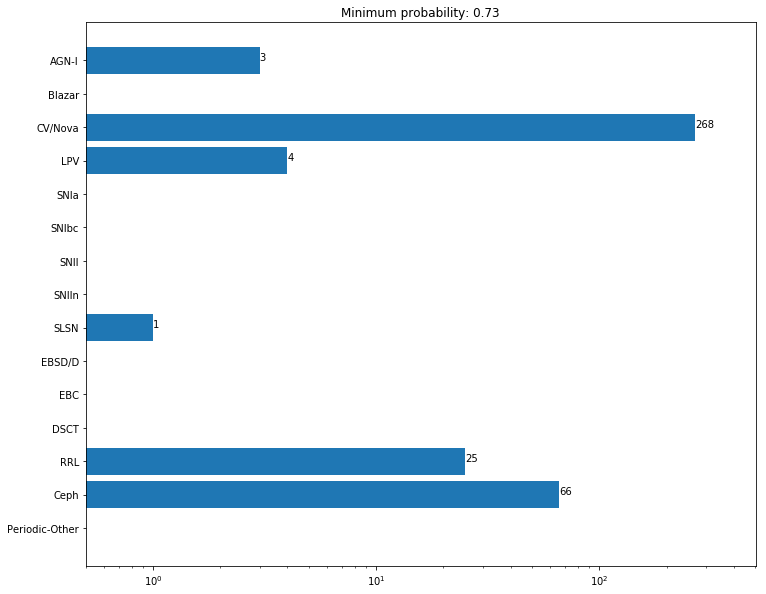

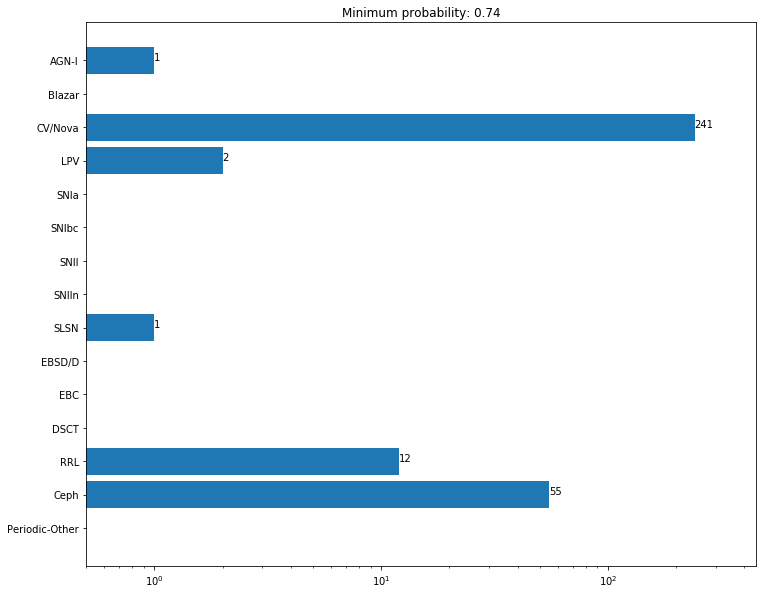

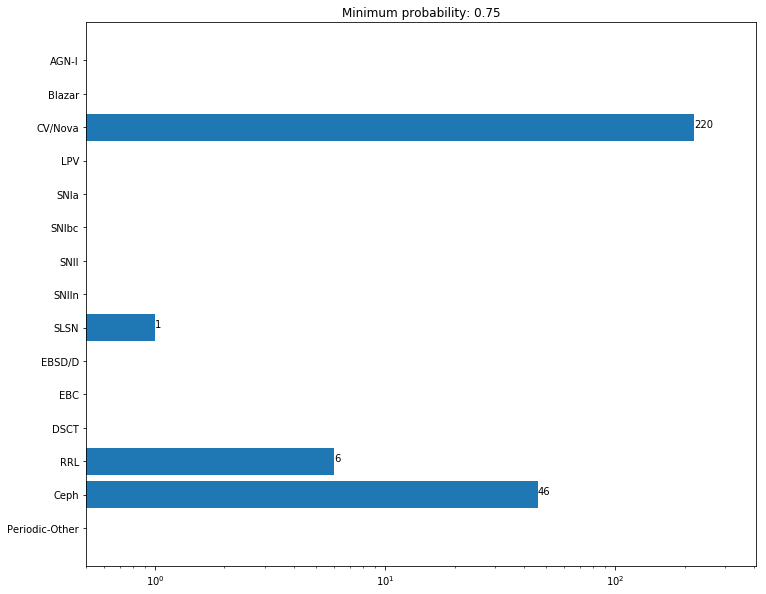

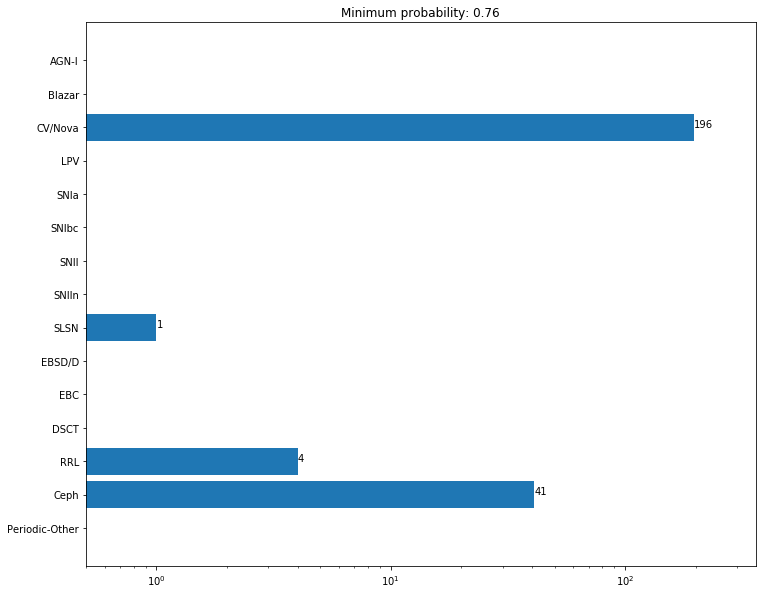

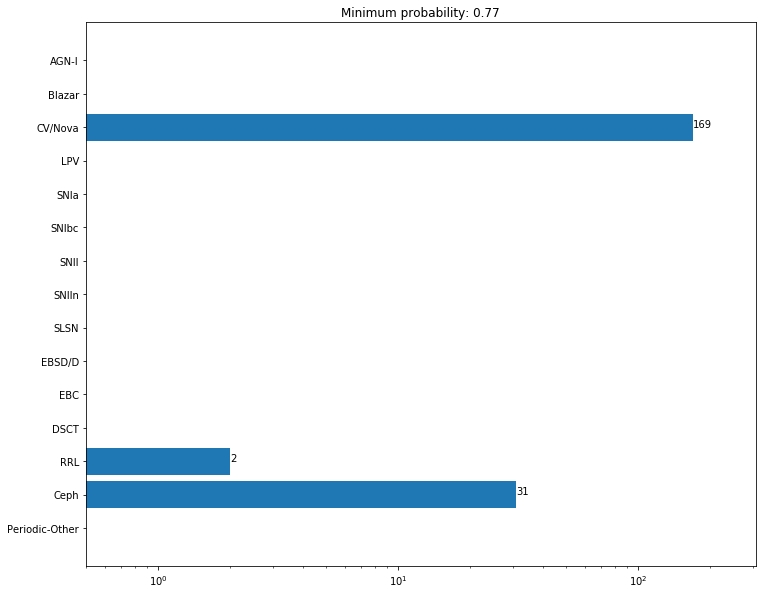

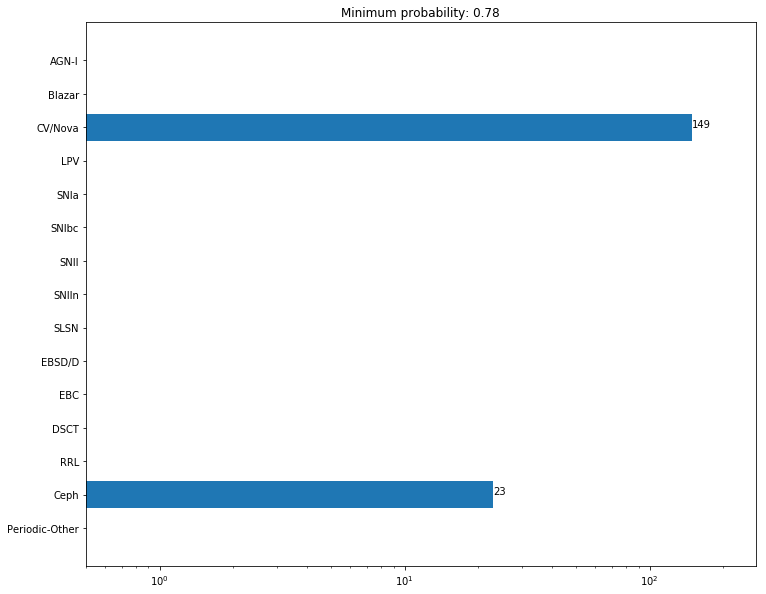

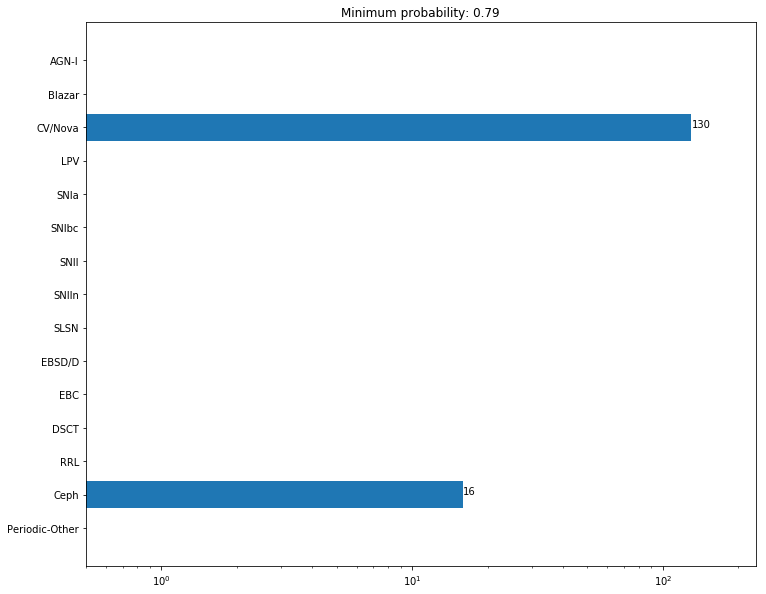

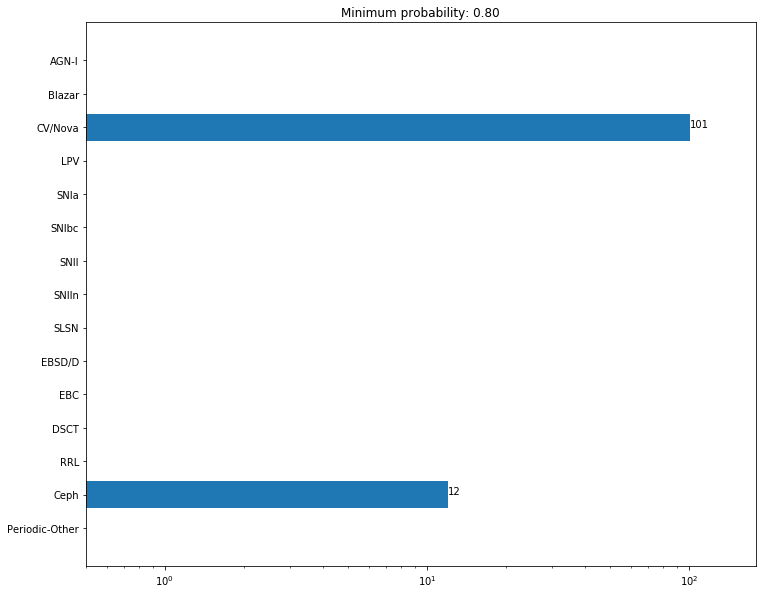

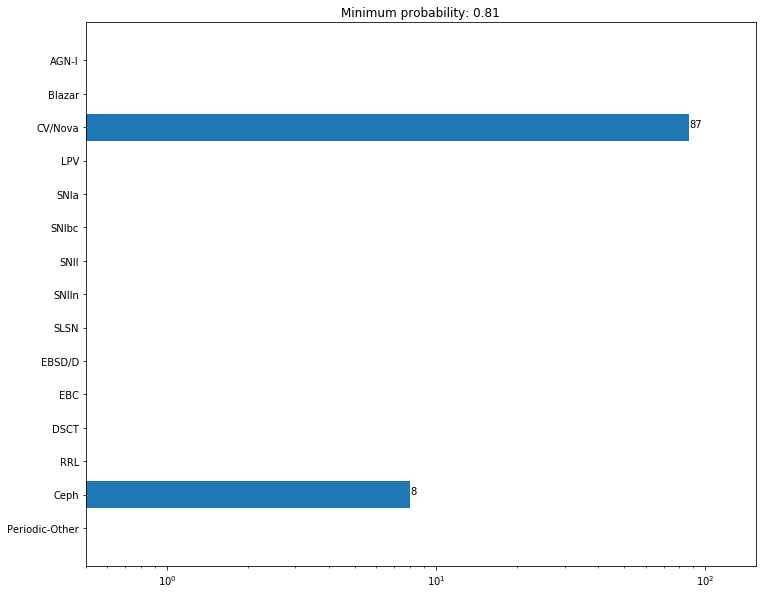

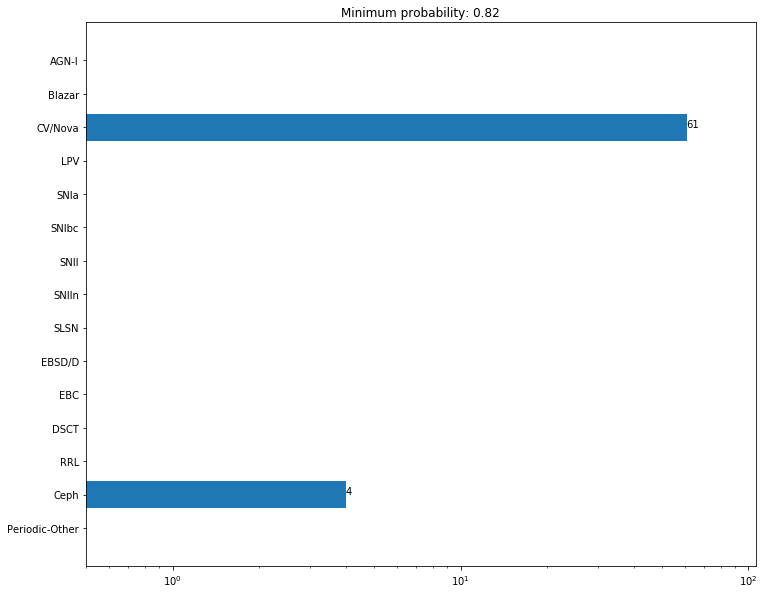

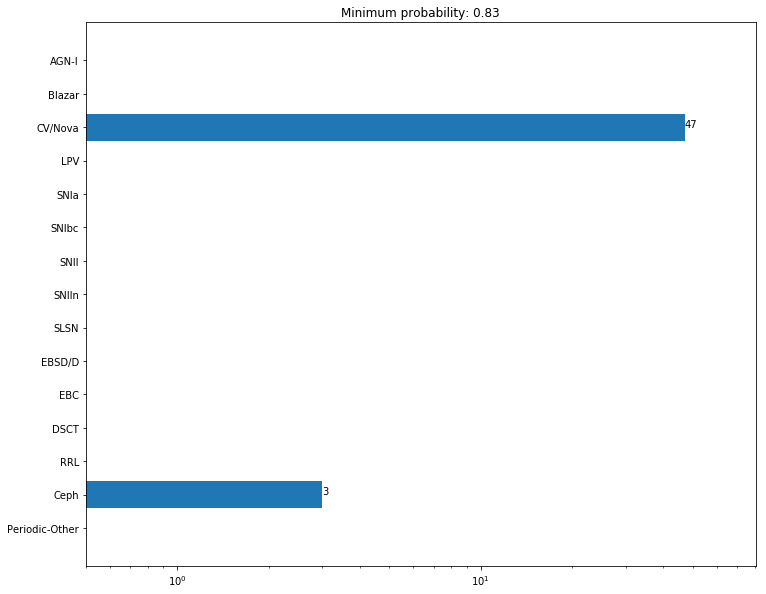

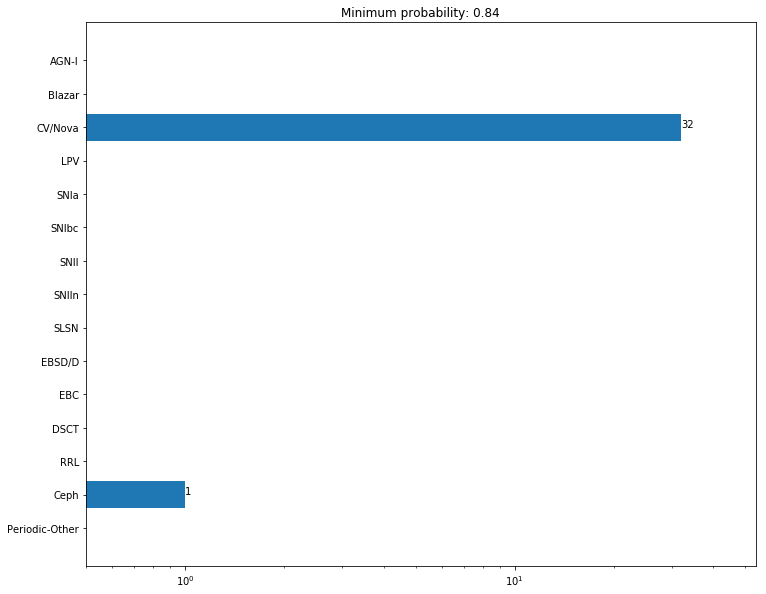

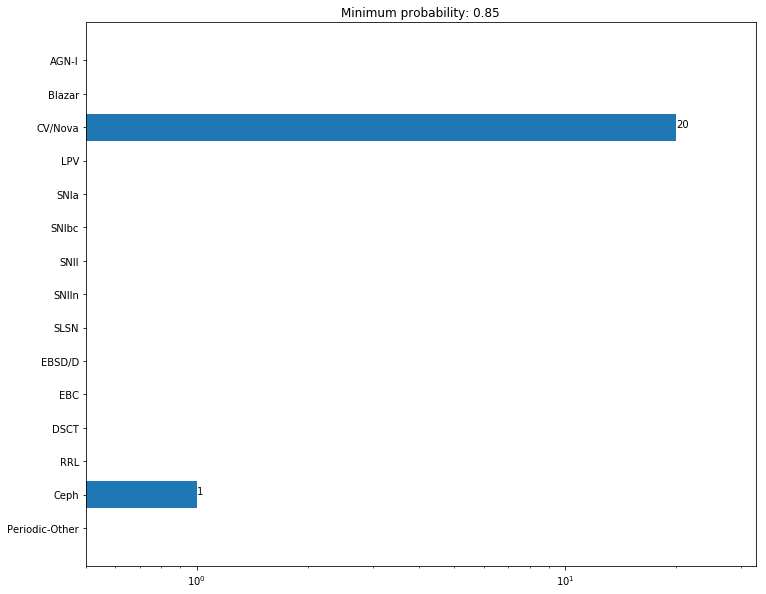

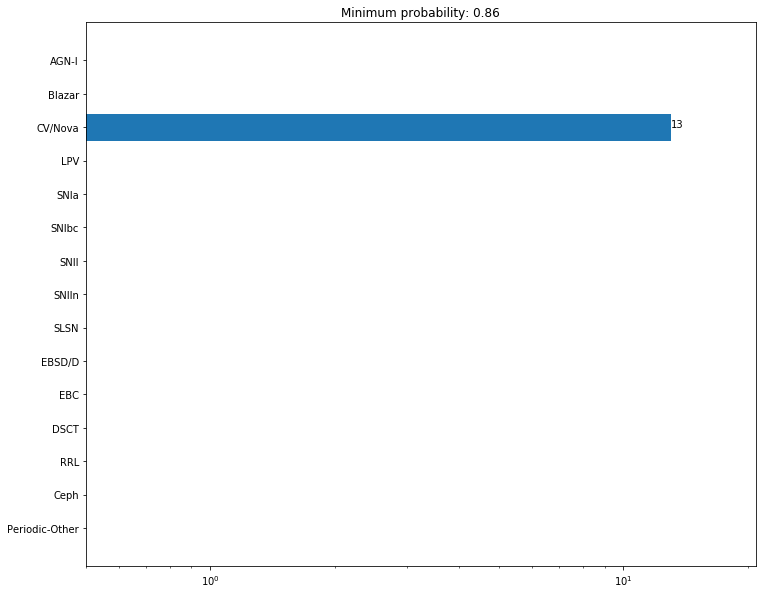

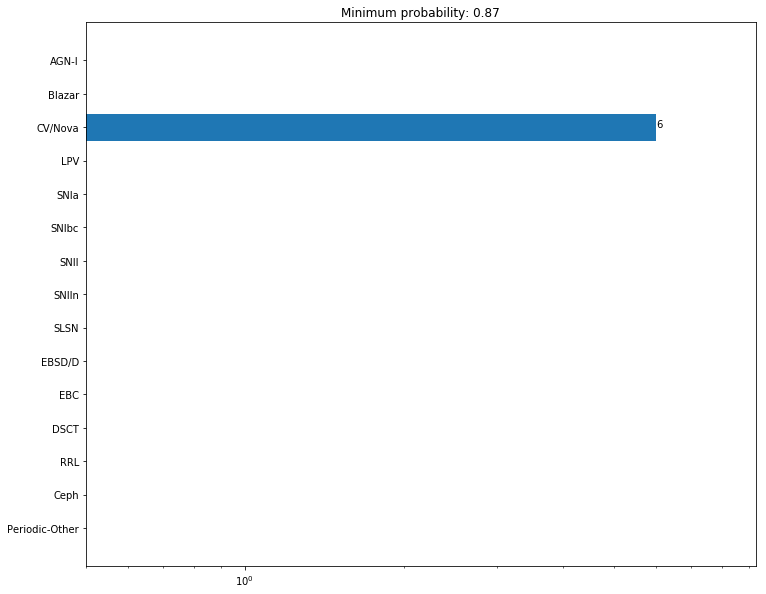

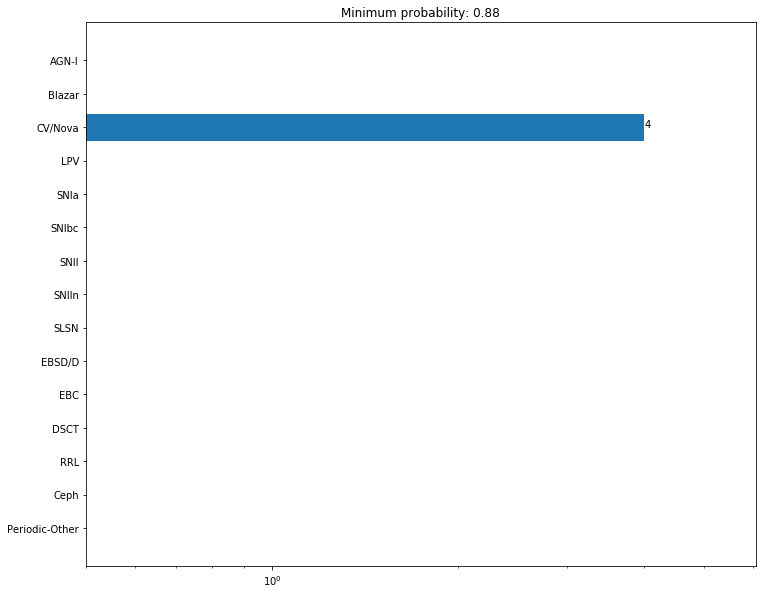

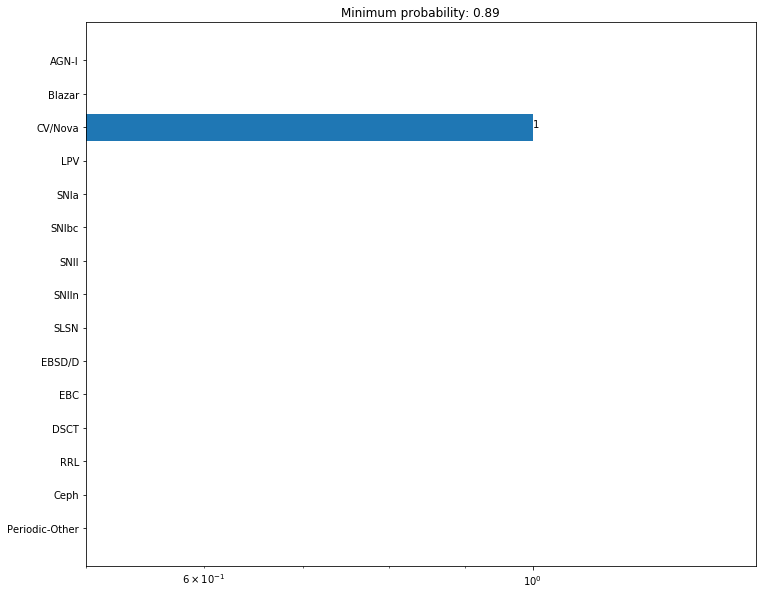

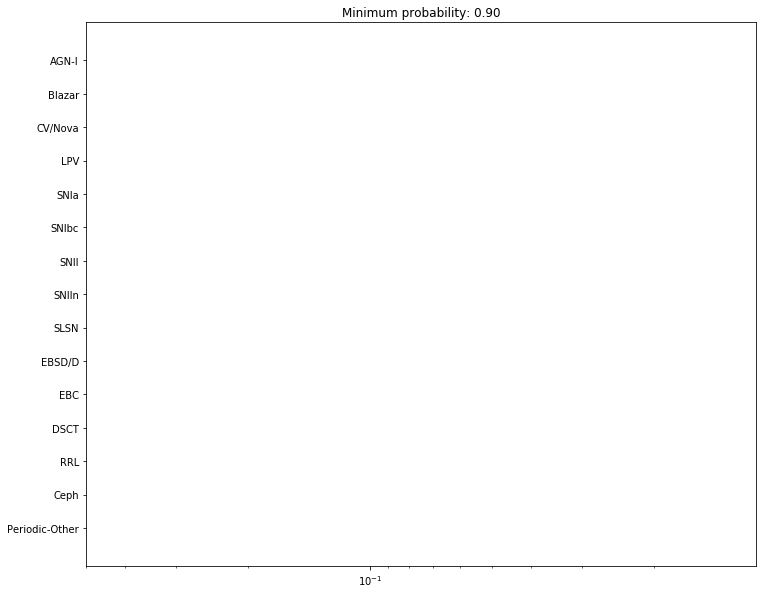

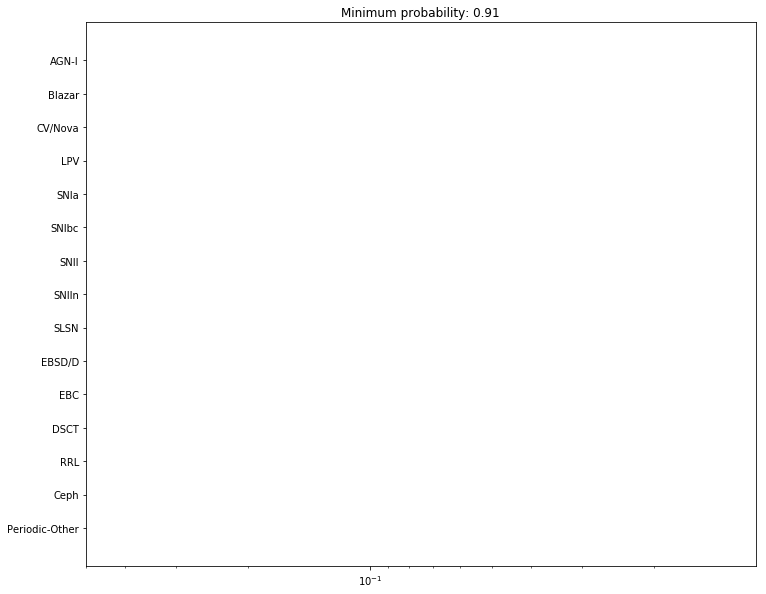

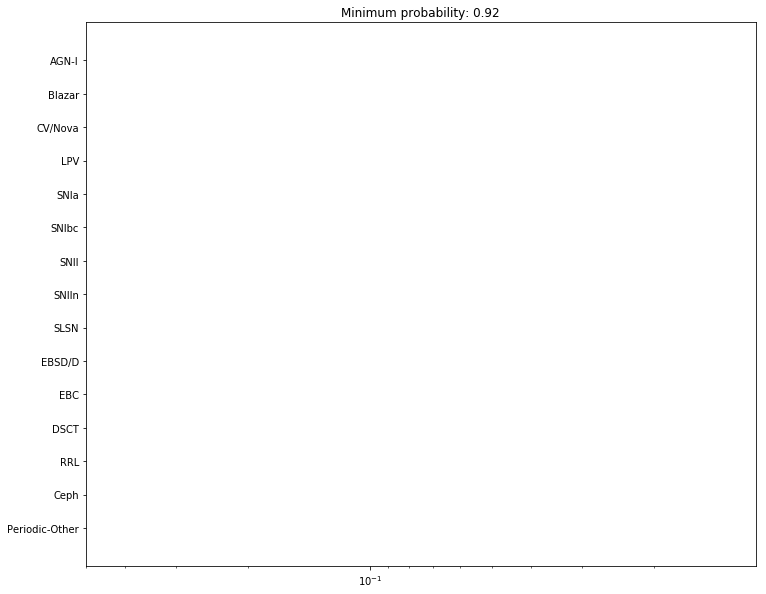

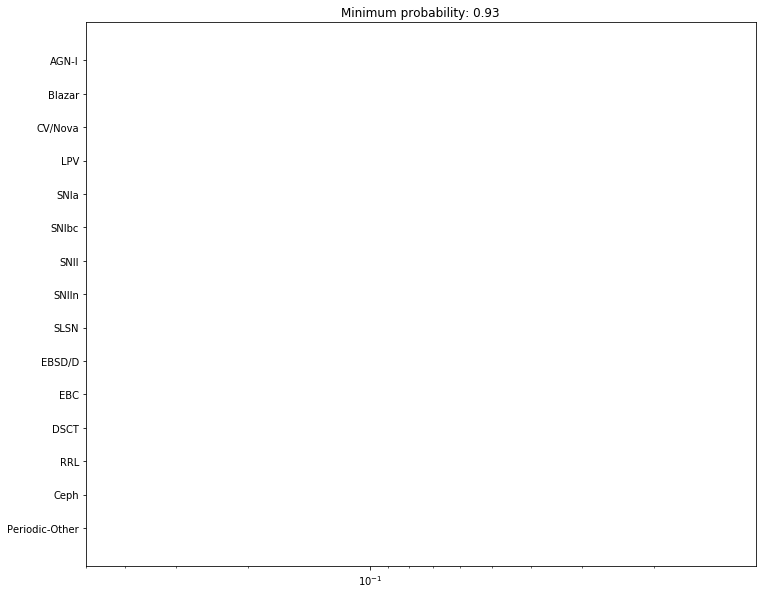

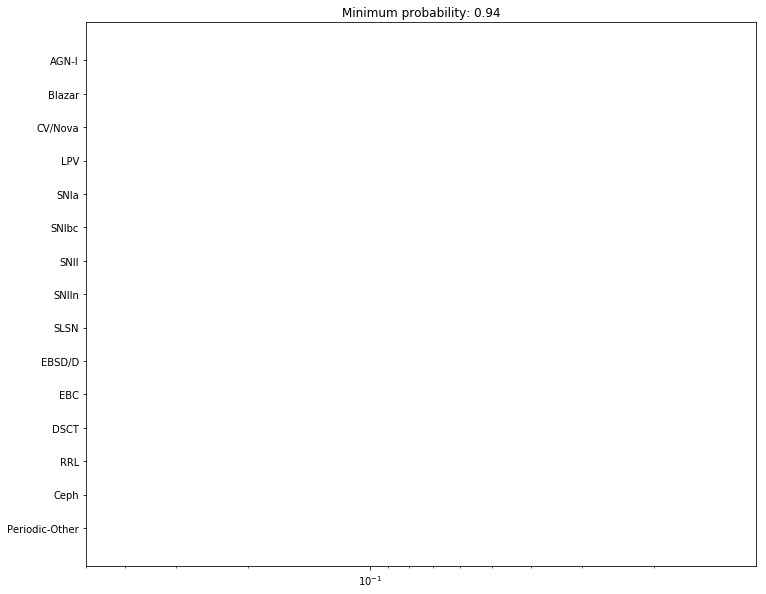

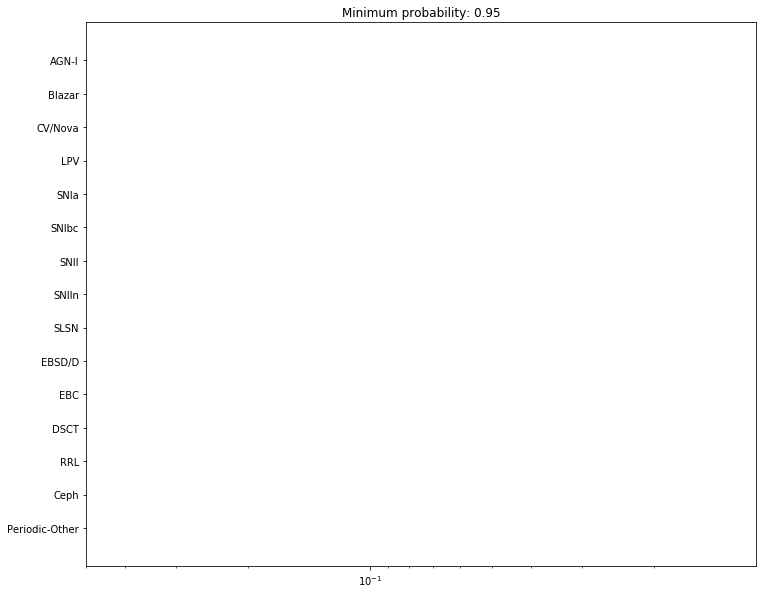

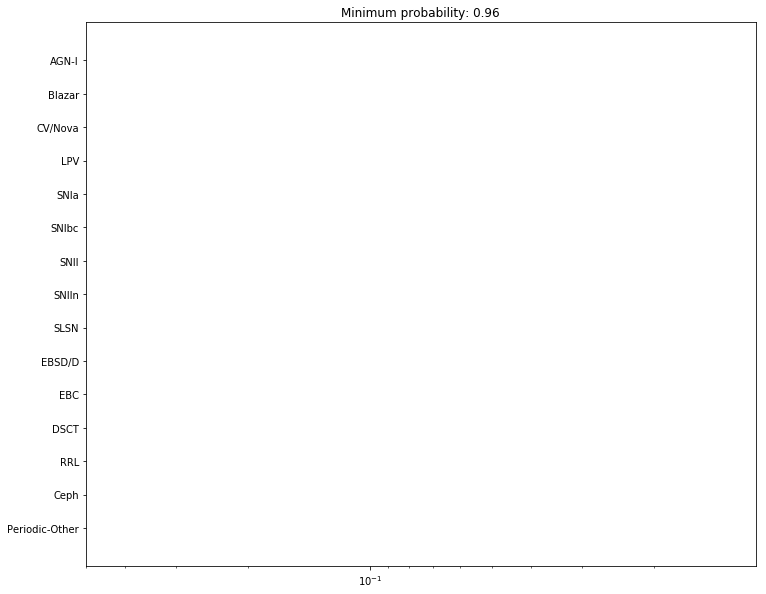

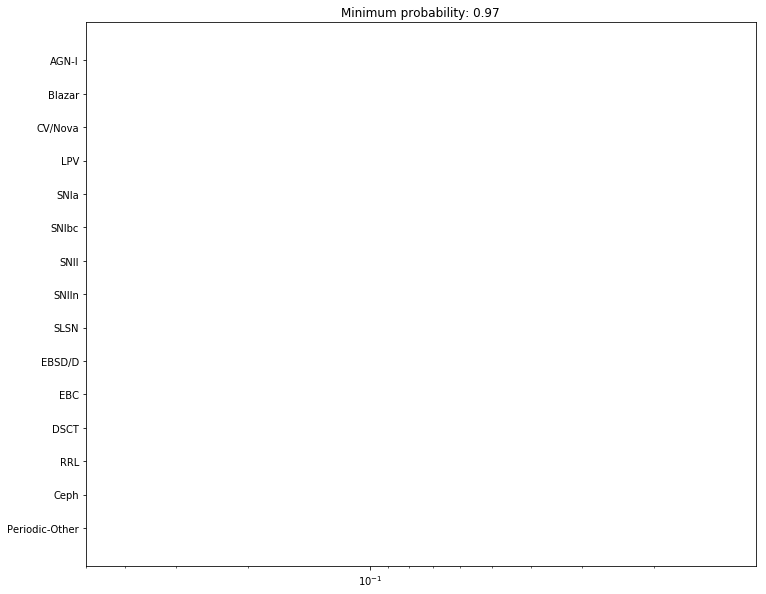

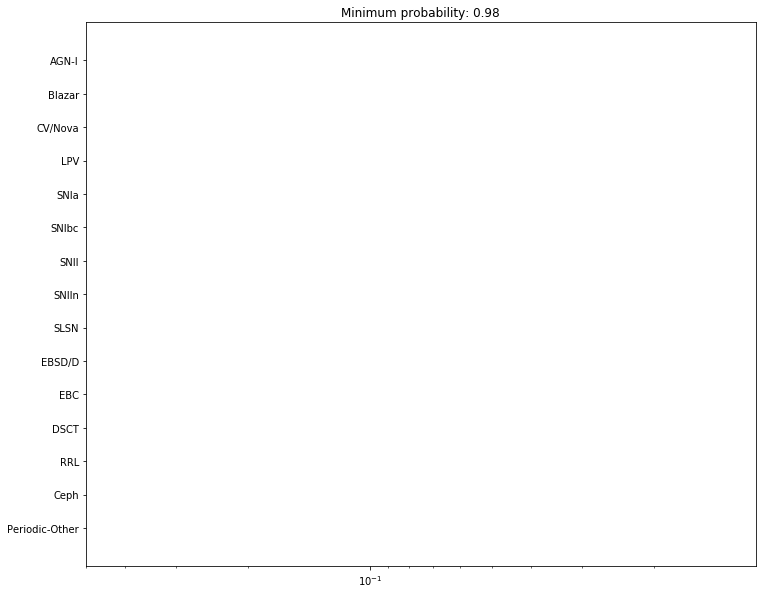

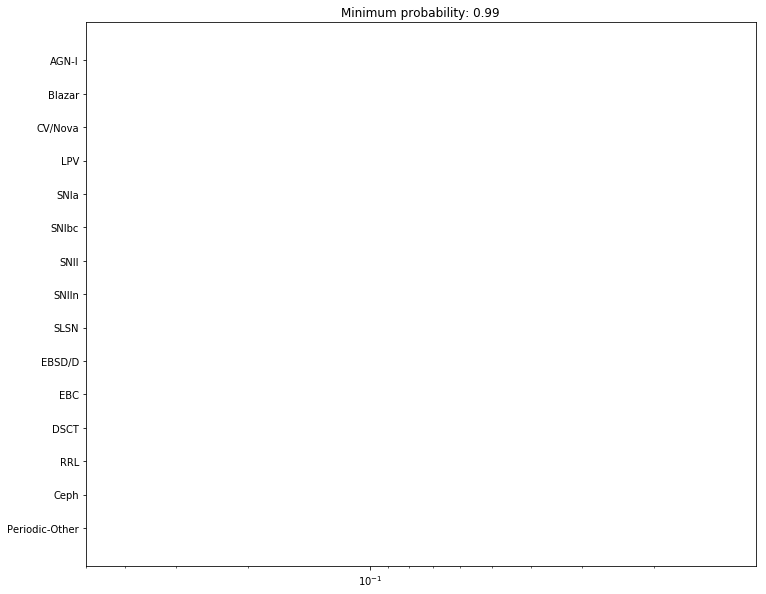

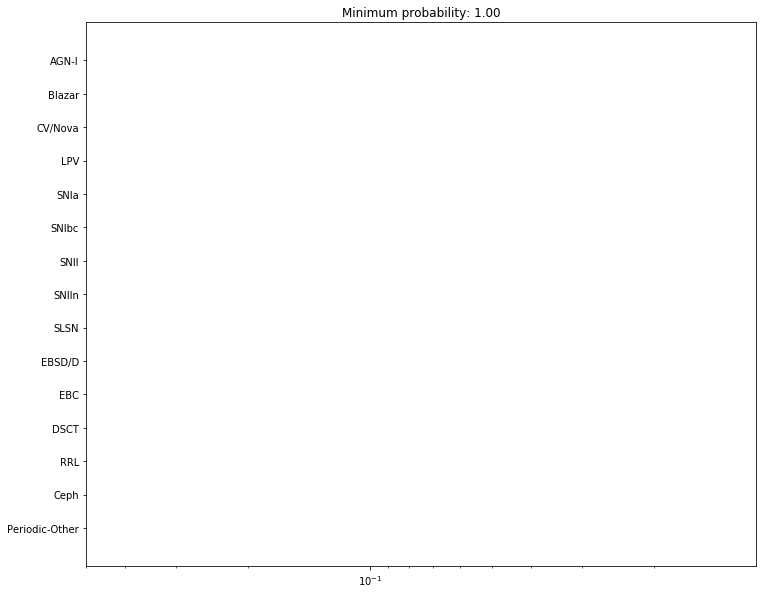

In [222]:
for prob_lim in np.linspace(0, 1, 100):
    fig, ax = plt.subplots(figsize=(12, 10))

    counts = {}
    for idx, cl in enumerate(class_order[::-1]):
        cl = "%s_prob" % cl
        mask = df_cl[cl][cl] > prob_lim
        if mask.sum() > 0:
            counts[cl] = len(df_cl[cl][cl].loc[mask])
            ax.text(counts[cl], idx, counts[cl])
        else:
            counts[cl] = 1e-3

    ax.barh(range(len(counts.keys())), list(counts.values()))
    ax.set_xscale('log')
    ax.set_xlim(0.5, ax.get_xlim()[1])
    ax.yaxis.set_ticks(range(len(counts.keys())))
    ax.yaxis.set_ticklabels([x[:-5] for x in counts.keys()]);
    ax.set_title("Minimum probability: %.2f" % prob_lim)
    
    plt.savefig("histogram_minprob%.2f.png" % prob_lim)

In [154]:
supernova = {
        "internal_name": "ZTF19abyikbv"
        }

# construct list of (key,value) pairs
json_data = [('api_key', (None, api_key)),
            ('data', (None, json.dumps(supernova)))]

json_url = url_tns_api + '/get/search'
response = requests.post(json_url, files = json_data)

objname = response.json()["data"]["reply"][0]["objname"]
data = {
        "objname": objname,
        "photometry": "1",
        "spectra": "0"
        }

# construct list of (key,value) pairs
json_data = [('api_key', (None, api_key)),
            ('data', (None, json.dumps(data)))]

json_url = url_tns_api + '/get/object'
response = requests.post(json_url, files = json_data)

groupname = response.json()["data"]["reply"]["source_group"]["group_name"]
photometry = response.json()["data"]["reply"]["photometry"]

# Extract data from TNS (API approach)

# Sandbox or real

In [51]:
sandbox = False # True: test in sandbox, False: send to real website

# Get API key and url

In [52]:
if sandbox:
    print("Getting API sandbox key...")
    api_key = open("API_sandbox.key", "r").read()
else:
    print("Getting API key...")
    api_key = open("API.key", "r").read()
    
if sandbox:
    url_tns_api="https://sandbox-tns.weizmann.ac.il/api"
else:
    url_tns_api="https://wis-tns.weizmann.ac.il/api"
    
if not sandbox:
    print("WARNING: submitting to real (not sandbox) TNS website")

Getting API key...


In [53]:
# function for changing data to json format
def format_to_json(source):
    # change data to json format and return
    parsed = json.loads(source, object_pairs_hook = OrderedDict)
    result = json.dumps(parsed, indent = 4)
    return result

In [222]:
mask = all_alerce["Discovering Group/s"] != "ALeRCE"

In [232]:
dtALeRCE = {}
telescope_2ndreport = {}

for name in all_alerce.loc[mask].Name.values:
    objname = name[3:]
    data = {
            "objname": objname,
            "photometry": "1",
            "spectra": "0"
            }

    # construct list of (key,value) pairs
    json_data = [('api_key', (None, api_key)),
                ('data', (None, json.dumps(data)))]

    json_url = url_tns_api + '/get/object'
    response = requests.post(json_url, files = json_data)

    groupname = response.json()["data"]["reply"]["source_group"]["group_name"]
    photometry = response.json()["data"]["reply"]["photometry"]
    
    times = []
    telescopes = []
    for i in photometry:
        if i["remarks"][:20] != "[Last non detection]":
            print("   ", objname, i["jd"], i["remarks"], i["telescope"]["name"])
            times.append(float(i["jd"]))
            telescopes.append(i["telescope"]["name"])

    try:
        times = np.array(times)
        telescopes = np.array(telescopes, dtype=str)
        idxsorted = np.argsort(times)
        times = times[idxsorted]
        telescopes = telescopes[idxsorted]
        dtimes = times - times[0]
        mask_rep = (dtimes > 0.5) # remove repetitions within the same night 
        dtimes = dtimes[mask_rep]
        telescopes = telescopes[mask_rep]
        dtALeRCE[objname] = dtimes[0]
        telescope_2ndreport[objname] = telescopes[0]
        print(objname, dtALeRCE[objname], telescope_2ndreport[objname])
        
        if telescope_2ndreport[objname] == "P48":
            print(times, telescopes)
    except:
        print("Error with object %s" % objname)

    2019rij 2458756.92  ATLAS1
    2019rij 2458754.7899306 Data provided by ZTF P48
2019rij 2.130069399718195 ATLAS1
    2019qvm 2458752.985  PS1
    2019qvm 2458750.8140394 Data provided by ZTF P48
2019qvm 2.1709606000222266 PS1
    2019qvf 2458756.7359954  ATLAS1
    2019qvf 2458753.6939931  Gaia
    2019qvf 2458750.6438542 Data provided by ZTF P48
2019qvf 3.0501389000564814 Gaia
    2019qsp 2458750.9359954  PS1
    2019qsp 2458753.9769907  ATLAS1
    2019qsp 2458749.8163542 Data provided by ZTF P48
2019qsp 1.1196412001736462 PS1
    2019qsg 2458754.915  PS1
    2019qsg 2458755.9479977  ATLAS1
    2019qsg 2458749.8163542 Data provided by ZTF P48
    2019qsg 2458749.792963 Data provided by ZTF P48
2019qsg 5.122037000022829 PS1
    2019qsc 2458751.1979977  Gaia
    2019qsc 2458749.6360995 Data provided by ZTF P48
2019qsc 1.5618981998413801 Gaia
    2019qqd 2458753.0859954  PS1
    2019qqd 2458748.9211458 Data provided by ZTF P48
2019qqd 4.164849599823356 PS1
    2019qqc 2458754.0779977

    2019ptb 2458744.7339931  ATLAS1
    2019ptb 2458743.73  Gaia
    2019ptb 2458734.6495833 Data provided by ZTF P48
2019ptb 9.08041669987142 Gaia
    2019pqp 2458744.0649884  PS1
    2019pqp 2458737.0002662  P48
    2019pqp 2458737.0002662  P48
    2019pqp 2458737.0002662  P48
    2019pqp 2458737.0002662  P48
    2019pqp 2458734.005544 Data provided by ZTF P48
    2019pqp 2458734.005544  P48
    2019pqp 2458734.005544  P48
    2019pqp 2458734.005544  P48
    2019pqp 2458734.005544  P48
2019pqp 2.9947222000919282 P48
[2458734.005544  2458734.005544  2458734.005544  2458734.005544
 2458734.005544  2458737.0002662 2458737.0002662 2458737.0002662
 2458737.0002662 2458744.0649884] ['P48' 'P48' 'P48' 'P48' 'PS1']
    2019pqo 2458737.7659954  ATLAS1
    2019pqo 2458733.712419 Data provided by ZTF P48
2019pqo 4.053576400037855 ATLAS1
    2019pqn 2458737.6285301  P48
    2019pqn 2458737.6285301  P48
    2019pqn 2458737.6285301  P48
    2019pqn 2458733.712419  P48
    2019pqn 2458733.712419 Da

    2019ozi 2458728.7985995  P48
    2019ozi 2458725.814213 Data provided by ZTF P48
    2019ozi 2458725.8142245  P48
2019ozi 2.9843865004368126 P48
[2458725.814213  2458725.8142245 2458728.7985995] ['P48']
    2019ozf 2458728.8039931  ATLAS1
    2019ozf 2458737.8091667  P48
    2019ozf 2458737.8091667  P48
    2019ozf 2458737.8091667  P48
    2019ozf 2458725.7897801 Data provided by ZTF P48
    2019ozf 2458725.7897801  P48
    2019ozf 2458737.7875926  P48
    2019ozf 2458737.7875926  P48
    2019ozf 2458737.7875926  P48
    2019ozf 2458725.7639815 Data provided by ZTF P48
    2019ozf 2458725.7639815  P48
2019ozf 3.0400115996599197 ATLAS1
    2019oxv 2458751.0859954  PS1
    2019oxv 2458724.9827431 Data provided by ZTF P48
2019oxv 26.103252300061285 PS1
    2019oxt 2458724.6813079 Data provided by ZTF P48
    2019oxt 2458724.6751968 Data provided by ZTF P48
    2019oxt 2458718.6809606  P48
    2019oxt 2458724.6538079 Data provided by ZTF P48
    2019oxt 2458724.6533565  P48
    2019oxt

    2019oot 2458719.9869907  ATLAS1
    2019oot 2458720.9025694  P48
    2019oot 2458720.9025694  P48
    2019oot 2458720.9025694  P48
    2019oot 2458720.9025579 Data provided by ZTF P48
    2019oot 2458723.8732523  P48
    2019oot 2458723.8732523  P48
    2019oot 2458723.8732523  P48
2019oot 0.915567200165242 P48
[2458719.9869907 2458720.9025579 2458720.9025694 2458720.9025694
 2458720.9025694 2458723.8732523 2458723.8732523 2458723.8732523] ['P48' 'P48' 'P48' 'P48' 'P48' 'P48' 'P48']
    2019oos 2458724.0739931  ATLAS1
    2019oos 2458720.9025694  P48
    2019oos 2458720.9025579 Data provided by ZTF P48
    2019oos 2458723.8732523  P48
2019oos 2.9706943999044597 P48
[2458720.9025579 2458720.9025694 2458723.8732523 2458724.0739931] ['P48' 'ATLAS1']
    2019oop 2458718.9629977  PS1
    2019oop 2458721.9819907  ATLAS1
    2019oop 2458723.8763542  P48
    2019oop 2458720.8913773  P48
    2019oop 2458720.8913657 Data provided by ZTF P48
2019oop 1.9283679998479784 P48
[2458718.9629977 245

    2019njp 2458754.0789931  PS1
    2019njp 2458722.0709954  PS1
    2019njp 2458719.0369907  ATLAS1
    2019njp 2458743.7829977  Gaia
    2019njp 2458711.9262963  P48
    2019njp 2458711.9262963  P48
    2019njp 2458707.9976968  P48
    2019njp 2458707.9976968 Data provided by ZTF P48
    2019njp 2458707.9976968  P48
2019njp 3.928599499631673 P48
[2458707.9976968 2458707.9976968 2458707.9976968 2458711.9262963
 2458711.9262963 2458719.0369907 2458722.0709954 2458743.7829977
 2458754.0789931] ['P48' 'P48' 'ATLAS1' 'PS1' 'Gaia' 'PS1']
    2019njk 2458720.0419907  PS1
    2019njk 2458707.9806944 Data provided by ZTF P48
2019njk 12.061296300031245 PS1
    2019nft 2458752.0209954  PS1
    2019nft 2458723.0589931  PS1
    2019nft 2458727.0609954  ATLAS1
    2019nft 2458706.9638889  P48
    2019nft 2458706.9822338 Data provided by ZTF P48
    2019nft 2458706.9822338  P48
2019nft 16.09510420029983 PS1
    2019new 2458719.9989931  ATLAS1
    2019new 2458706.9371991 Data provided by ZTF P48
20

    2019mix 2458733.0529977  PS1
    2019mix 2458696.9655556 Data provided by ZTF P48
    2019mix 2458693.9824306 Data provided by ZTF P48
2019mix 2.983124999795109 P48
[2458693.9824306 2458696.9655556 2458733.0529977] ['P48' 'PS1']


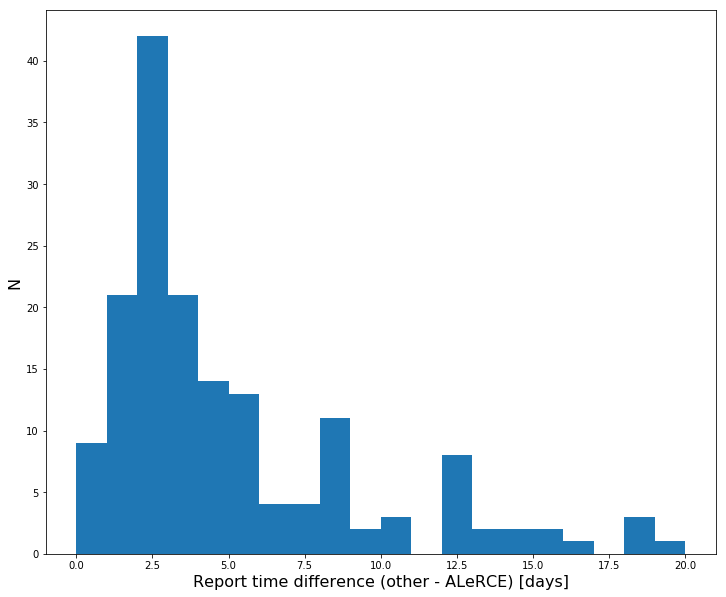

In [251]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.hist(dtALeRCE.values(), bins=np.linspace(0, 20, 21));
ax.set_xlabel("Report time difference (other - ALeRCE) [days]", fontsize=16);
ax.set_ylabel("N", fontsize=16)
plt.savefig("plots/Reportdiff.png")